# 生产企业原材料的订购与运输
## 分析
一年48周，需提前24周制定订购转运计划，每周产能为2.82万 $m^3$ 
### 原材料：
- **A:** 消耗量 $0.6 m^3 / m^3$ ，单价 $120\%$
- **B:** 消耗量 $0.66 m^3 / m^3$ ，单价 $110\%$
- **C:** 消耗量 $0.72 m^3 / m^3$ ，单价 $100\%$

- 附件 1 给出了该企业近 5 年 402 家原材料供应商的订货量和供货量数据。
- 附件 2 给出了 8 家转运商的运输损耗率数据。

## 计算并解决问题1

### 初始化环境

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
warnings.filterwarnings('ignore')

plt.style.use('default')
# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['黑体', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 创建必要的文件夹
if not os.path.exists('DataFrames'):
    os.makedirs('DataFrames')
    print("创建DataFrames文件夹用于存储表格数据")

if not os.path.exists('Pictures'):
    os.makedirs('Pictures')
    print("创建Pictures文件夹用于存储图片")

print("done!")

done!


### 数据读取和简单处理

In [2]:
# ==================== 数据读取与预处理 ====================
print("="*60)
print("步骤1：读取附件1和附件2数据")
print("="*60)

try:
    # 读取附件1：供应商数据
    supplier_order = pd.read_excel('C/附件1 近5年402家供应商的相关数据.xlsx', 
                                   sheet_name='企业的订货量（m³）')
    supplier_supply = pd.read_excel('C/附件1 近5年402家供应商的相关数据.xlsx', 
                                    sheet_name='供应商的供货量（m³）')
    
    # 读取附件2：转运商数据
    transporter_loss = pd.read_excel('C/附件2 近5年8家转运商的相关数据.xlsx', 
                                     sheet_name='运输损耗率（%）')
    
    print("数据读取成功!")
    print(f"  - 供应商订货量数据: {supplier_order.shape}")
    print(f"  - 供应商供货量数据: {supplier_supply.shape}")
    print(f"  - 转运商损耗率数据: {transporter_loss.shape}")
    
except Exception as e:
    print(f"数据读取失败: {e}")
    print("请确保数据文件路径正确！")

步骤1：读取附件1和附件2数据
数据读取成功!
  - 供应商订货量数据: (402, 242)
  - 供应商供货量数据: (402, 242)
  - 转运商损耗率数据: (8, 241)
数据读取成功!
  - 供应商订货量数据: (402, 242)
  - 供应商供货量数据: (402, 242)
  - 转运商损耗率数据: (8, 241)


In [3]:
# ==================== 附件1数据结构分析 ====================
print("\n" + "="*60)
print("步骤2：附件1数据结构分析")
print("="*60)

# 查看数据前几行
print("供应商订货量数据结构:")
print(supplier_order.head())

print("\n供应商供货量数据结构:")
print(supplier_supply.head())

# 提取关键信息
supplier_names = supplier_order.iloc[:, 0].values  # 供应商名称
material_types = supplier_order.iloc[:, 1].values  # 材料类型
order_data = supplier_order.iloc[:, 2:].values     # 订货量数据
supply_data = supplier_supply.iloc[:, 2:].values   # 供货量数据

print(f"\n基本统计信息:")
print(f"  - 供应商总数: {len(supplier_names)}")
print(f"  - 数据周期: {order_data.shape[1]} 周")
print(f"  - 原材料类型分布:")

# 分析材料类型分布
material_counts = pd.Series(material_types).value_counts()
for material, count in material_counts.items():
    percentage = count / len(material_types) * 100
    print(f"    * {material}类: {count}家 ({percentage:.1f}%)")

print(f"\n数据质量检查:")
print(f"  - 订货量数据缺失值: {pd.isna(order_data).sum().sum()}")
print(f"  - 供货量数据缺失值: {pd.isna(supply_data).sum().sum()}")
print(f"  - 订货量数据零值比例: {(order_data == 0).sum().sum() / order_data.size * 100:.1f}%")
print(f"  - 供货量数据零值比例: {(supply_data == 0).sum().sum() / supply_data.size * 100:.1f}%")


步骤2：附件1数据结构分析
供应商订货量数据结构:
  供应商ID 材料分类  W001  W002  W003  W004  W005  W006  W007  W008  ...  W231  W232  \
0  S001    B     0     0     0    43     0     0     0     0  ...     1     0   
1  S002    A     1     1     0     1     0     0     0     0  ...     0     0   
2  S003    C     7     1     0     0     0     1     4    50  ...    10     3   
3  S004    B     0     1     1   100     0    85     0     0  ...     1     0   
4  S005    A    30    60    60    60    70    70    60    70  ...    80    70   

   W233  W234  W235  W236  W237  W238  W239  W240  
0     0     1     0     1     0     0     0     0  
1     1     0     0     0     1     1     0     1  
2    50    20    20     7    10     9    20    10  
3     1     0     0     0     0     1     0     0  
4    70    70    70    70    70    70    70    80  

[5 rows x 242 columns]

供应商供货量数据结构:
  供应商ID 材料分类  W001  W002  W003  W004  W005  W006  W007  W008  ...  W231  W232  \
0  S001    B     0     0     0     0     0     0     0  

### 转运商T1-T8运输损耗率分布图

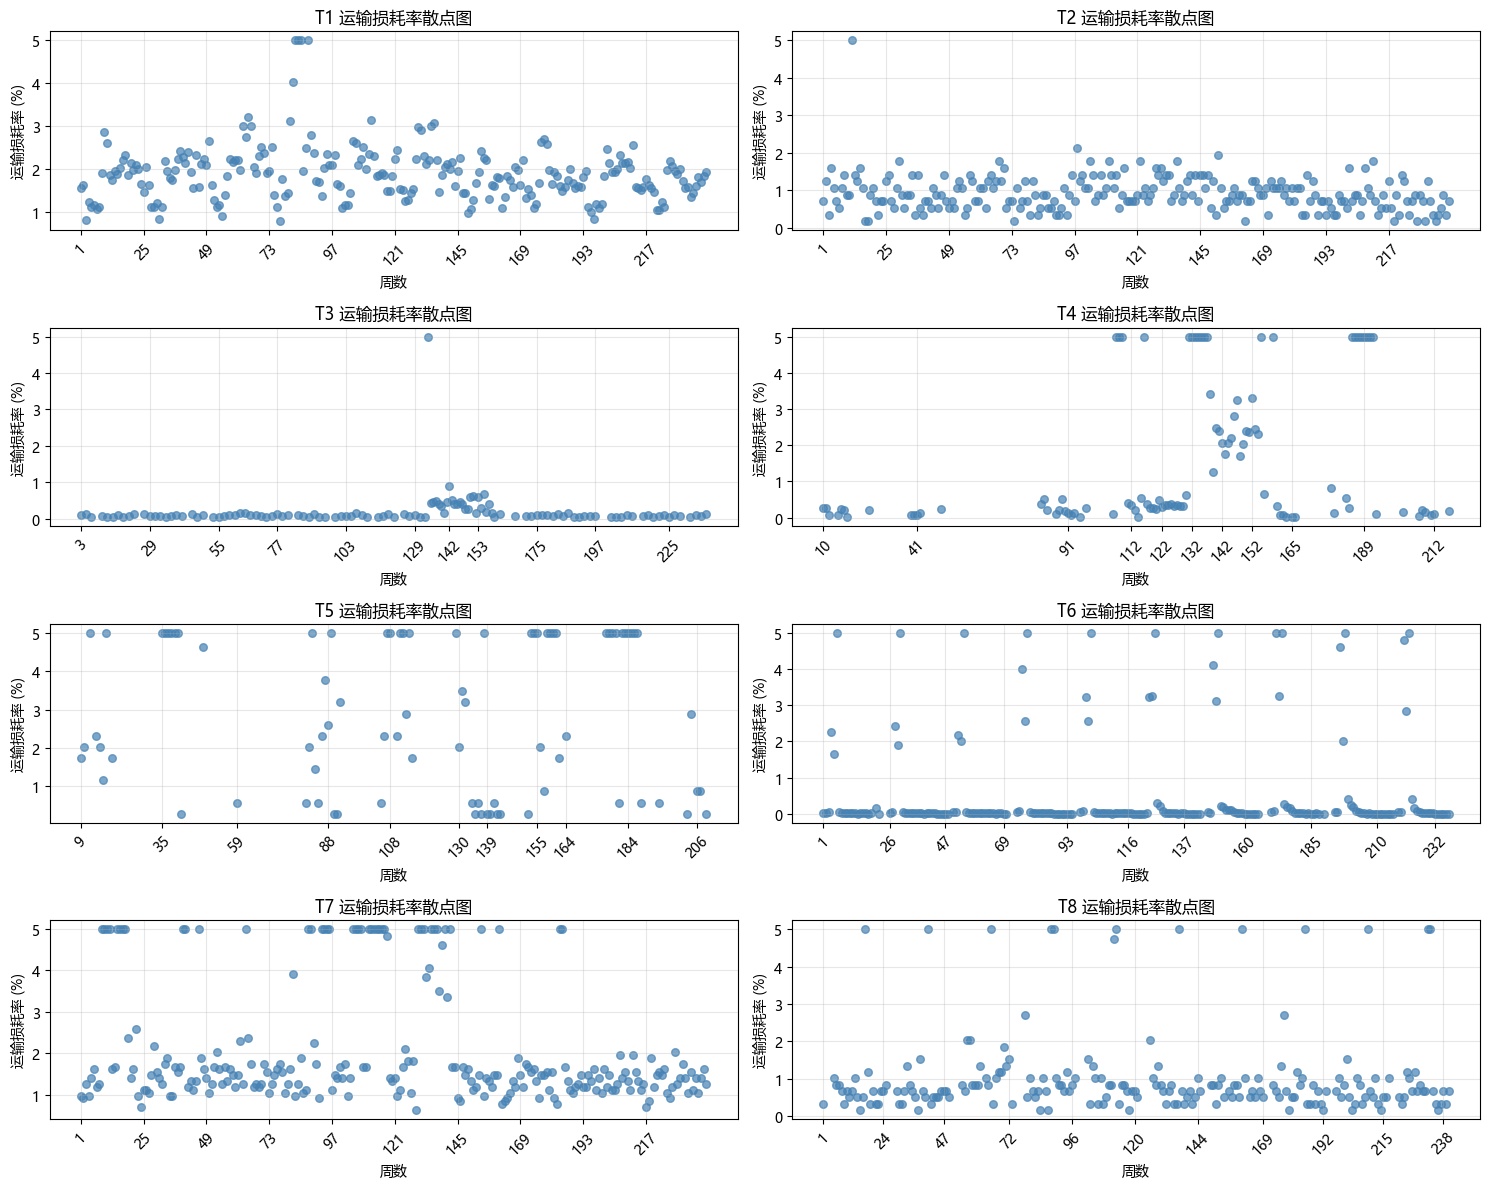

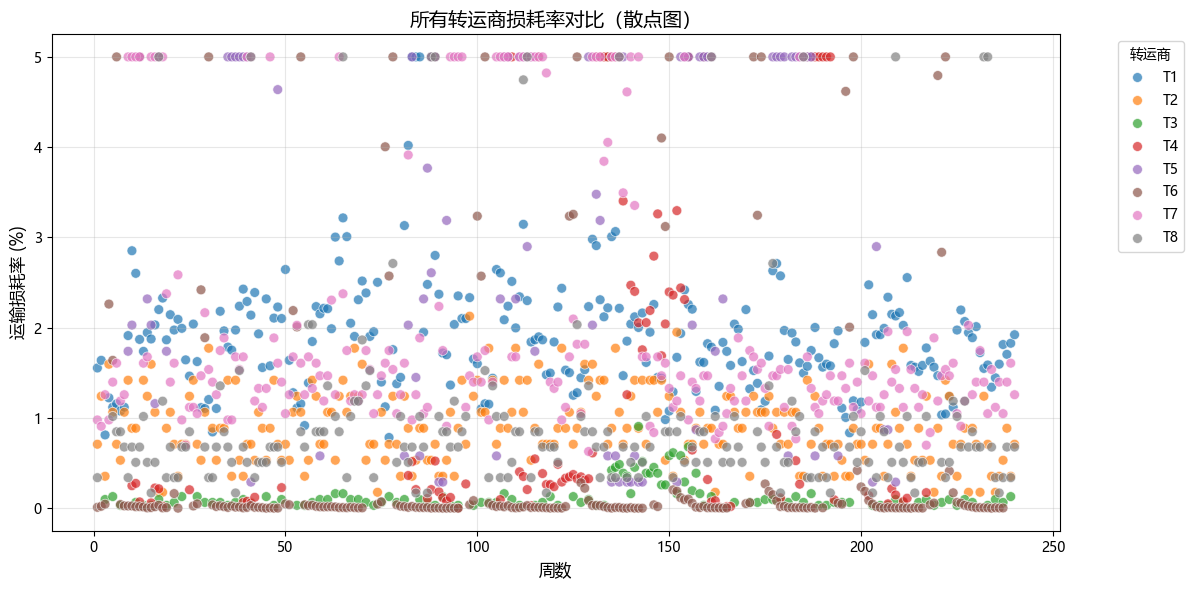

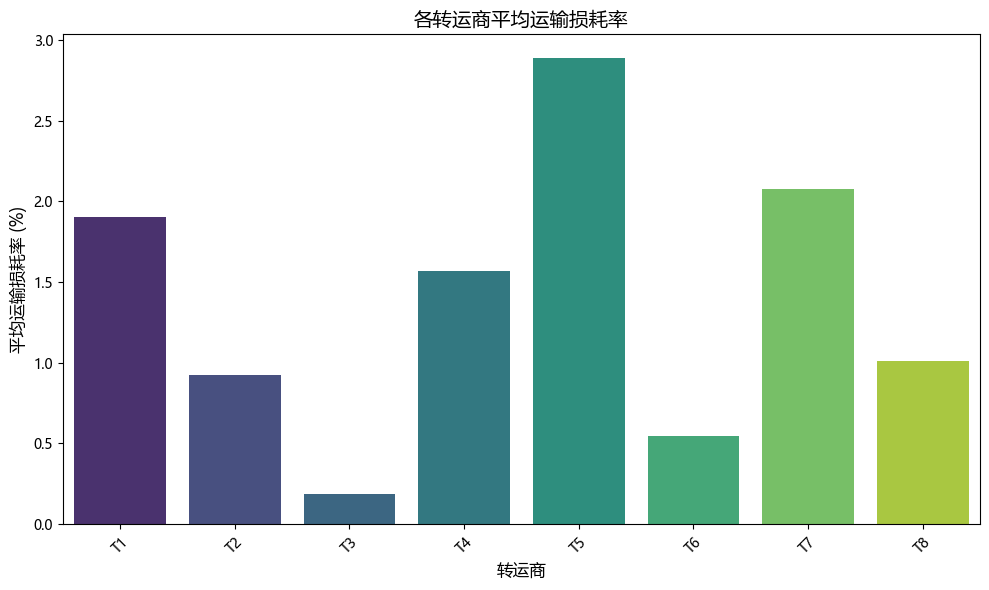

In [4]:
# 绘制转运商T1-T8的损耗率分布图
# 横坐标为周数，纵坐标为运输损耗率（%），每个转运商单独画一张图
fig, axes = plt.subplots(4, 2, figsize=(15, 12))

# 获取周数（列索引）
weeks = range(1, transporter_loss.shape[1])  # 从第2列开始是数据列

transporter_loss_mean = []
for i, transporter_name in enumerate(transporter_loss.iloc[:, 0]):  # 第一列是转运商名称
    row, col = divmod(i, 2)
    
    # 获取该转运商的损耗率数据（排除第一列的名称列）
    loss_rates = transporter_loss.iloc[i, 1:].values
    
    # 过滤掉值为0的点
    non_zero_mask = loss_rates > 0
    filtered_weeks = [w for w, mask in zip(weeks, non_zero_mask) if mask]
    filtered_loss_rates = loss_rates[non_zero_mask]
    
    transporter_loss_mean.append(filtered_loss_rates.mean() if len(filtered_loss_rates) > 0 else 0)
    # 绘制散点图，只绘制非零值
    axes[row, col].scatter(filtered_weeks, filtered_loss_rates, alpha=0.7, s=30, color='steelblue')
    axes[row, col].set_title(f"{transporter_name} 运输损耗率散点图", fontsize=12)
    axes[row, col].set_xlabel("周数", fontsize=10)
    axes[row, col].set_ylabel("运输损耗率 (%)", fontsize=10)
    axes[row, col].grid(True, alpha=0.3)
    
    # 设置x轴标签间隔，避免过于密集
    axes[row, col].tick_params(axis='x', rotation=45)
    if len(filtered_weeks) > 20:
        # 如果周数太多，只显示部分刻度
        step = max(1, len(filtered_weeks) // 10)
        axes[row, col].set_xticks(filtered_weeks[::step])

# 调整布局并保存为矢量图（必须在show()之前）
plt.tight_layout()
plt.savefig('Pictures/transporter_loss_scatter.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

# 额外：使用seaborn绘制所有转运商在一张图上的对比（散点图）
plt.figure(figsize=(12, 6))

# 创建长格式数据用于seaborn，只包含非零值
transporter_long = []

for i, transporter_name in enumerate(transporter_loss.iloc[:, 0]):
    for week, loss_rate in enumerate(transporter_loss.iloc[i, 1:].values, 1):
        if loss_rate > 0:  # 只包含非零值
            transporter_long.append({
                'transporter': transporter_name,
                'week': week,
                'loss_rate': loss_rate
            })

df_long = pd.DataFrame(transporter_long)

# 使用seaborn绘制散点图
sns.scatterplot(data=df_long, x='week', y='loss_rate', hue='transporter', 
                alpha=0.7, s=50)
plt.title('所有转运商损耗率对比（散点图）', fontsize=14)
plt.xlabel('周数', fontsize=12)
plt.ylabel('运输损耗率 (%)', fontsize=12)
plt.legend(title='转运商', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Pictures/transporter_comparison_scatter.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

# 绘制平均损耗率条形图
plt.figure(figsize=(10, 6))
sns.barplot(x=transporter_loss.iloc[:, 0], y=transporter_loss_mean, palette='viridis')
plt.title('各转运商平均运输损耗率', fontsize=14)
plt.xlabel('转运商', fontsize=12)
plt.ylabel('平均运输损耗率 (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Pictures/transporter_average_loss.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

### 分别计算每个供货商每周参数
1. 市场占有率（该供货商占此类型原材料的市场份额）
2. 有效供货率（订单满足率）


#### 市场占有率和有效供货率计算方法说明


##### 核心计算公式

###### 1. 市场占有率计算
**周市场占有率（基于订货量）**
```
周市场占有率[i] = 该供应商第i周订货量 / 该材料类型所有供应商第i周总订货量
```

**周市场占有率（基于供货量）**
```
周市场占有率[i] = 该供应商第i周供货量 / 该材料类型所有供应商第i周总供货量
```

**总市场占有率**
```
总市场占有率 = 该供应商总订货量(或供货量) / 该材料类型所有供应商总订货量(或总供货量)
```

###### 2. 有效供货率计算
**周有效供货率**
```
周有效供货率[i] = 该供应商第i周实际供货量 / 该供应商第i周订货量
```

**总有效供货率**
```
总有效供货率 = 该供应商总实际供货量 / 该供应商总订货量
```

###### 3. 平均值计算
- **平均市场占有率**：只考虑有订货/供货的周数，避免0值影响
- **平均有效供货率**：只考虑有订货的周数

##### 计算步骤
1. **数据分组**：按材料类型（A/B/C）分组所有供应商
2. **市场总量计算**：计算每种材料每周的总订货量和总供货量
3. **逐供应商计算**：计算每个供应商的各项指标
4. **结果存储**：将所有指标保存到字典中供后续分析


In [5]:
# ==================== 供应商供货特征分析 ====================
print("\n" + "="*60)
print("步骤3：供应商供货特征深度分析")
print("="*60)

# 计算每个供应商的关键指标
def analyze_supplier_characteristics():
    """
    分析每个供应商的供货特征
    
    返回：包含所有供应商特征指标的DataFrame
    计算指标：可靠性、稳定性、供货频率、平均周供货量、最大周供货量等
    """
    
    supplier_metrics = []
    
    # 遍历每个供应商进行特征分析
    for i in range(len(supplier_names)):
        # 步骤1：获取基本数据
        orders = order_data[i]      # 该供应商的订货量时间序列
        supplies = supply_data[i]   # 该供应商的供货量时间序列
        
        # 步骤2：数据预处理 - 过滤非零数据用于计算平均值和稳定性
        non_zero_orders = orders[orders > 0]    # 过滤掉零订货量的周数
        non_zero_supplies = supplies[supplies > 0]  # 过滤掉零供货量的周数
        
        # 步骤3：计算总量指标
        total_order = np.sum(orders)    # 总订货量：累计所有周的订货量
        total_supply = np.sum(supplies) # 总供货量：累计所有周的供货量
        
        # 步骤4：计算供货可靠性
        # 公式：reliability = 总实际供货量 / 总订货量
        # 含义：反映供应商整体的订单完成能力，值越接近1越好
        reliability = total_supply / total_order if total_order > 0 else 0
        
        # 步骤5：计算供货稳定性
        # 使用变异系数的倒数来衡量稳定性
        # 变异系数 = 标准差 / 平均值，值越小越稳定
        # 稳定性 = 1 / (变异系数 + 0.001)，值越大越稳定
        if len(non_zero_supplies) > 0:
            supply_cv = np.std(non_zero_supplies) / np.mean(non_zero_supplies)  # 计算变异系数
        else:
            supply_cv = float('inf')  # 无供货记录时设为无穷大
        stability = 1 / (supply_cv + 0.001)  # 转换为稳定性指标，加0.001避免除零
        
        # 步骤6：计算供货频率
        # 公式：supply_frequency = 有供货的周数 / 总周数
        # 含义：反映供应商的活跃程度，值越大说明供货越频繁
        supply_frequency = len(non_zero_supplies) / len(supplies)
        
        # 步骤7：计算平均周供货量
        # 只计算有供货周数的平均值，避免零值影响
        avg_weekly_supply = np.mean(non_zero_supplies) if len(non_zero_supplies) > 0 else 0
        
        # 步骤8：计算最大周供货量
        # 反映供应商的最大供货能力
        max_weekly_supply = np.max(supplies)
        
        # 步骤9：汇总所有指标
        supplier_metrics.append({
            'supplier_name': supplier_names[i],        # 供应商名称
            'material_type': material_types[i],        # 材料类型(A/B/C)
            'total_order': total_order,                # 总订货量
            'total_supply': total_supply,              # 总供货量
            'reliability': reliability,                # 供货可靠性(0-1)
            'stability': stability,                    # 供货稳定性(值越大越稳定)
            'supply_frequency': supply_frequency,      # 供货频率(0-1)
            'avg_weekly_supply': avg_weekly_supply,    # 平均周供货量
            'max_weekly_supply': max_weekly_supply,    # 最大周供货量
            'active_weeks': len(non_zero_supplies)     # 有效供货周数
        })
    
    # 步骤10：返回DataFrame格式的结果
    return pd.DataFrame(supplier_metrics)

# 执行供应商特征分析
supplier_analysis = analyze_supplier_characteristics()

print("\n供应商供货特征分析完成！")
print(f"分析了 {len(supplier_analysis)} 家供应商的供货特征")
print("包含指标：可靠性、稳定性、供货频率、平均周供货量、最大周供货量等")

def calculate_market_share_and_fulfillment():
    """
    计算每个供应商的市场占有率和有效供货率
    
    市场占有率计算公式：
    - 周市场占有率 = 该供应商某周订货量(或供货量) / 该材料类型所有供应商该周总订货量(或总供货量)
    - 总市场占有率 = 该供应商总订货量(或供货量) / 该材料类型所有供应商总订货量(或总供货量)
    
    有效供货率计算公式：
    - 周有效供货率 = 该供应商某周实际供货量 / 该供应商某周订货量
    - 总有效供货率 = 该供应商总实际供货量 / 该供应商总订货量
    """
    # 步骤1：初始化数据结构
    # 创建结果字典存储每个供应商的指标
    supplier_metrics = {}
    
    # 步骤2：按材料类型分组数据
    # 分离三种材料的数据，便于按材料类型计算市场占有率
    material_data = {'A': [], 'B': [], 'C': []}
    
    # 按材料类型分组数据：将每个供应商的数据归类到对应的材料类型中
    for i, material_type in enumerate(material_types):
        material_data[material_type].append({
            'supplier_name': supplier_names[i],
            'order_data': order_data[i],      # 该供应商的周订货量数组
            'supply_data': supply_data[i],    # 该供应商的周供货量数组
            'index': i
        })
    
    print("各材料类型供应商数量统计:")
    for material in ['A', 'B', 'C']:
        print(f"  {material}类材料供应商: {len(material_data[material])}家")
    
    # 步骤3：计算市场总量（分母）
    # 计算每种材料每周的总订货量和总供货量，用于计算市场占有率
    weekly_totals = {}
    for material in ['A', 'B', 'C']:
        suppliers = material_data[material]
        # 初始化该材料类型的周总量数组（长度为总周数）
        weekly_order_total = np.zeros(order_data.shape[1])
        weekly_supply_total = np.zeros(supply_data.shape[1])
        
        # 累加所有供应商的订货量和供货量，得到每周市场总量
        for supplier in suppliers:
            weekly_order_total += supplier['order_data']   # 周订货量累加
            weekly_supply_total += supplier['supply_data'] # 周供货量累加
        
        # 存储该材料类型的市场总量数据
        weekly_totals[material] = {
            'order_total': weekly_order_total,   # 每周总订货量数组
            'supply_total': weekly_supply_total  # 每周总供货量数组
        }
    
    # 步骤4：逐个供应商计算指标
    # 计算每个供应商的各项指标
    for material in ['A', 'B', 'C']:
        suppliers = material_data[material]
        
        for supplier in suppliers:
            supplier_name = supplier['supplier_name']
            orders = supplier['order_data']    # 该供应商的周订货量数组
            supplies = supplier['supply_data'] # 该供应商的周供货量数组
            
            # 计算步骤1：每周市场占有率（基于订货量）
            # 公式：weekly_market_share_order[i] = orders[i] / weekly_totals[material]['order_total'][i]
            # 使用np.divide避免除零错误，当分母为0时结果为0
            weekly_market_share_order = np.divide(
                orders,                                      # 分子：该供应商各周订货量
                weekly_totals[material]['order_total'],      # 分母：该材料类型各周总订货量
                out=np.zeros_like(orders, dtype=float),      # 除零时的输出值
                where=weekly_totals[material]['order_total']!=0  # 只在分母非零时计算
            )
            
            # 计算步骤2：每周市场占有率（基于供货量）
            # 公式：weekly_market_share_supply[i] = supplies[i] / weekly_totals[material]['supply_total'][i]
            weekly_market_share_supply = np.divide(
                supplies,                                    # 分子：该供应商各周供货量
                weekly_totals[material]['supply_total'],     # 分母：该材料类型各周总供货量
                out=np.zeros_like(supplies, dtype=float),    # 除零时的输出值
                where=weekly_totals[material]['supply_total']!=0  # 只在分母非零时计算
            )
            
            # 计算步骤3：总市场占有率
            # 先计算总量，再计算占比
            total_order = np.sum(orders)                     # 该供应商总订货量
            total_supply = np.sum(supplies)                  # 该供应商总供货量
            total_market_order = np.sum(weekly_totals[material]['order_total'])   # 该材料类型总订货量
            total_market_supply = np.sum(weekly_totals[material]['supply_total']) # 该材料类型总供货量
            
            # 公式：total_market_share_order = total_order / total_market_order
            total_market_share_order = total_order / total_market_order if total_market_order > 0 else 0
            # 公式：total_market_share_supply = total_supply / total_market_supply
            total_market_share_supply = total_supply / total_market_supply if total_market_supply > 0 else 0
            
            # 计算步骤4：每周有效供货率（订单满足率）
            # 公式：weekly_fulfillment_rate[i] = supplies[i] / orders[i]
            # 表示该供应商每周实际供货量占其订货量的比例
            weekly_fulfillment_rate = np.divide(
                supplies,                                    # 分子：该供应商各周实际供货量
                orders,                                      # 分母：该供应商各周订货量
                out=np.zeros_like(supplies, dtype=float),    # 除零时的输出值
                where=orders!=0                              # 只在订货量非零时计算
            )
            
            # 计算步骤5：总有效供货率
            # 公式：total_fulfillment_rate = total_supply / total_order
            # 表示该供应商总体实际供货量占其总订货量的比例
            total_fulfillment_rate = total_supply / total_order if total_order > 0 else 0
            
            # 计算步骤6：计算平均市场占有率和有效供货率
            # 只考虑有订货的周数，避免空周对平均值的影响
            active_weeks = orders > 0                        # 找出有订货的周数（布尔数组）
            
            # 平均市场占有率（基于订货量）：只计算有订货周数的平均值
            # 公式：avg_market_share_order = mean(weekly_market_share_order[active_weeks])
            avg_market_share_order = np.mean(weekly_market_share_order[active_weeks]) if np.any(active_weeks) else 0
            
            # 平均市场占有率（基于供货量）：只计算有供货周数的平均值
            # 公式：avg_market_share_supply = mean(weekly_market_share_supply[supplies > 0])
            avg_market_share_supply = np.mean(weekly_market_share_supply[supplies > 0]) if np.any(supplies > 0) else 0
            
            # 平均有效供货率：只计算有订货周数的平均值
            # 公式：avg_fulfillment_rate = mean(weekly_fulfillment_rate[active_weeks])
            avg_fulfillment_rate = np.mean(weekly_fulfillment_rate[active_weeks]) if np.any(active_weeks) else 0
            
            # 步骤7：存储计算结果
            # 将所有计算得到的指标存储到字典中，便于后续分析使用
            supplier_metrics[supplier_name] = {
                'material_type': material,                    # 材料类型（A/B/C）
                'weekly_market_share_order': weekly_market_share_order,     # 周市场占有率（基于订货量）数组
                'weekly_market_share_supply': weekly_market_share_supply,   # 周市场占有率（基于供货量）数组
                'weekly_fulfillment_rate': weekly_fulfillment_rate,         # 周有效供货率数组
                'total_market_share_order': total_market_share_order,       # 总市场占有率（基于订货量）
                'total_market_share_supply': total_market_share_supply,     # 总市场占有率（基于供货量）
                'total_fulfillment_rate': total_fulfillment_rate,           # 总有效供货率
                'avg_market_share_order': avg_market_share_order,           # 平均市场占有率（基于订货量）
                'avg_market_share_supply': avg_market_share_supply,         # 平均市场占有率（基于供货量）
                'avg_fulfillment_rate': avg_fulfillment_rate,               # 平均有效供货率
                'total_order': total_order,                                 # 总订货量
                'total_supply': total_supply,                               # 总供货量
                'active_weeks_count': np.sum(active_weeks)                  # 有效供货周数
            }
    
    # 步骤8：返回计算结果
    # 返回所有供应商的指标字典和各材料类型的市场总量数据
    return supplier_metrics, weekly_totals

# 执行计算
supplier_metrics, weekly_totals = calculate_market_share_and_fulfillment()

print("\n市场占有率和供货率计算完成!")

# 显示各材料类型的市场总体情况
print("\n各材料类型市场总体情况:")
for material in ['A', 'B', 'C']:
    total_order = np.sum(weekly_totals[material]['order_total'])
    total_supply = np.sum(weekly_totals[material]['supply_total'])
    overall_fulfillment = total_supply / total_order if total_order > 0 else 0
    
    print(f"  {material}类材料:")
    print(f"    - 总订货量: {total_order:,.0f} m³")
    print(f"    - 总供货量: {total_supply:,.0f} m³")
    print(f"    - 整体满足率: {overall_fulfillment:.3f} ({overall_fulfillment*100:.1f}%)")

# 显示各材料类型排名前10的供应商
print("\n各材料类型市场占有率TOP 10供应商:")
for material in ['A', 'B', 'C']:
    print(f"\n{material}类材料（按总市场占有率排序）:")
    material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                         if metrics['material_type'] == material]
    material_suppliers.sort(key=lambda x: x[1]['total_market_share_order'], reverse=True)
    
    print(f"{'排名':<4} {'供应商':<12} {'总市场占有率':<12} {'总供货率':<10} {'平均供货率':<10}")
    print("-" * 60)
    
    for i, (name, metrics) in enumerate(material_suppliers[:10], 1):
        print(f"{i:<4} {name:<12} {metrics['total_market_share_order']*100:<12.2f}% "
              f"{metrics['total_fulfillment_rate']:<10.3f} {metrics['avg_fulfillment_rate']:<10.3f}")

# 整体统计信息
all_suppliers = list(supplier_metrics.values())
avg_fulfillment_all = np.mean([s['total_fulfillment_rate'] for s in all_suppliers])
avg_market_share_all = np.mean([s['total_market_share_order'] for s in all_suppliers])

print(f"\n整体统计:")
print(f"  - 所有供应商平均市场占有率: {avg_market_share_all*100:.2f}%")
print(f"  - 所有供应商平均供货满足率: {avg_fulfillment_all:.3f} ({avg_fulfillment_all*100:.1f}%)")
print(f"  - 供应商总数: {len(supplier_metrics)}")

print(f"\n市场占有率和有效供货率计算完成!")
print(f"   数据已存储在 supplier_metrics 字典中，可用于后续分析。")



步骤3：供应商供货特征深度分析

供应商供货特征分析完成！
分析了 402 家供应商的供货特征
包含指标：可靠性、稳定性、供货频率、平均周供货量、最大周供货量等
各材料类型供应商数量统计:
  A类材料供应商: 146家
  B类材料供应商: 134家
  C类材料供应商: 122家

市场占有率和供货率计算完成!

各材料类型市场总体情况:
  A类材料:
    - 总订货量: 2,056,903 m³
    - 总供货量: 1,453,057 m³
    - 整体满足率: 0.706 (70.6%)
  B类材料:
    - 总订货量: 1,917,241 m³
    - 总供货量: 1,498,662 m³
    - 整体满足率: 0.782 (78.2%)
  C类材料:
    - 总订货量: 1,855,279 m³
    - 总供货量: 1,448,287 m³
    - 整体满足率: 0.781 (78.1%)

各材料类型市场占有率TOP 10供应商:

A类材料（按总市场占有率排序）:
排名   供应商          总市场占有率       总供货率       平均供货率     
------------------------------------------------------------
1    S229         17.50       % 0.986      0.994     
2    S201         16.95       % 0.235      0.536     
3    S282         8.19        % 1.005      1.013     
4    S348         8.12        % 0.553      1.070     
5    S275         7.69        % 1.003      1.003     
6    S329         7.60        % 1.001      1.002     
7    S395         5.13        % 0.719      0.918     
8    S307         4.96        % 0.767  

##### 保存计算结果

In [6]:
# ==================== 保存结果到多个Excel文件 ====================
print("\n" + "="*60)
print("保存分析结果到Excel文件")
print("="*60)

def save_analysis_results_to_excel():
    """
    将分析结果保存到多个Excel文件中，每种数据类型单独存储
    """
    from datetime import datetime
    
    # 获取当前时间戳用于文件命名
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    try:
        # ============ 1. 保存供应商基本特征分析结果 ============
        print("正在保存供应商基本特征分析结果...")
        supplier_features_file = f"DataFrames/供应商基本特征分析_{timestamp}.xlsx"
        
        with pd.ExcelWriter(supplier_features_file, engine='openpyxl') as writer:
            # 供应商基本特征表
            supplier_analysis.to_excel(writer, sheet_name='供应商基本特征', index=False)
            
            # 按材料类型分组的汇总统计
            for material in ['A', 'B', 'C']:
                material_data = supplier_analysis[supplier_analysis['material_type'] == material]
                if not material_data.empty:
                    sheet_name = f'{material}类材料供应商特征'
                    material_data.to_excel(writer, sheet_name=sheet_name, index=False)
        
        print(f"  ✓ 已保存到: {supplier_features_file}")
        
        # ============ 2. 保存市场占有率分析结果 ============
        print("正在保存市场占有率分析结果...")
        market_share_file = f"DataFrames/供应商市场占有率分析_{timestamp}.xlsx"
        
        # 准备市场占有率数据
        market_share_data = []
        for supplier_name, metrics in supplier_metrics.items():
            market_share_data.append({
                '供应商名称': supplier_name,
                '材料类型': metrics['material_type'],
                '总订货量': metrics['total_order'],
                '总供货量': metrics['total_supply'],
                '总市场占有率_订货': round(metrics['total_market_share_order'] * 100, 3),
                '总市场占有率_供货': round(metrics['total_market_share_supply'] * 100, 3),
                '平均市场占有率_订货': round(metrics['avg_market_share_order'] * 100, 3),
                '平均市场占有率_供货': round(metrics['avg_market_share_supply'] * 100, 3),
                '有效供货周数': metrics['active_weeks_count']
            })
        
        market_share_df = pd.DataFrame(market_share_data)
        
        with pd.ExcelWriter(market_share_file, engine='openpyxl') as writer:
            # 总体市场占有率表
            market_share_df.to_excel(writer, sheet_name='市场占有率汇总', index=False)
            
            # 按材料类型分组的市场占有率排名
            for material in ['A', 'B', 'C']:
                material_data = market_share_df[market_share_df['材料类型'] == material].copy()
                if not material_data.empty:
                    # 按总市场占有率排序
                    material_data = material_data.sort_values('总市场占有率_订货', ascending=False)
                    material_data.reset_index(drop=True, inplace=True)
                    material_data.index = range(1, len(material_data) + 1)  # 添加排名
                    material_data.index.name = '排名'
                    
                    sheet_name = f'{material}类材料市场占有率'
                    material_data.to_excel(writer, sheet_name=sheet_name)
        
        print(f"  ✓ 已保存到: {market_share_file}")
        
        # ============ 3. 保存供货率分析结果 ============
        print("正在保存供货率分析结果...")
        fulfillment_rate_file = f"DataFrames/供应商供货率分析_{timestamp}.xlsx"
        
        # 准备供货率数据
        fulfillment_data = []
        for supplier_name, metrics in supplier_metrics.items():
            fulfillment_data.append({
                '供应商名称': supplier_name,
                '材料类型': metrics['material_type'],
                '总订货量': metrics['total_order'],
                '总供货量': metrics['total_supply'],
                '总供货率': round(metrics['total_fulfillment_rate'], 4),
                '平均供货率': round(metrics['avg_fulfillment_rate'], 4),
                '有效供货周数': metrics['active_weeks_count']
            })
        
        fulfillment_df = pd.DataFrame(fulfillment_data)
        
        with pd.ExcelWriter(fulfillment_rate_file, engine='openpyxl') as writer:
            # 总体供货率表
            fulfillment_df.to_excel(writer, sheet_name='供货率汇总', index=False)
            
            # 按材料类型分组的供货率排名
            for material in ['A', 'B', 'C']:
                material_data = fulfillment_df[fulfillment_df['材料类型'] == material].copy()
                if not material_data.empty:
                    # 按总供货率排序
                    material_data = material_data.sort_values('总供货率', ascending=False)
                    material_data.reset_index(drop=True, inplace=True)
                    material_data.index = range(1, len(material_data) + 1)  # 添加排名
                    material_data.index.name = '排名'
                    
                    sheet_name = f'{material}类材料供货率'
                    material_data.to_excel(writer, sheet_name=sheet_name)
        
        print(f"  ✓ 已保存到: {fulfillment_rate_file}")
        
        # ============ 4. 保存周数据时间序列 ============
        print("正在保存周数据时间序列...")
        weekly_data_file = f"DataFrames/供应商周数据时间序列_{timestamp}.xlsx"
        
        with pd.ExcelWriter(weekly_data_file, engine='openpyxl') as writer:
            # 为每种材料类型创建周数据表
            for material in ['A', 'B', 'C']:
                # 筛选该材料类型的供应商
                material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                                     if metrics['material_type'] == material]
                
                if not material_suppliers:
                    continue
                
                # 创建周市场占有率数据表
                weeks_count = len(material_suppliers[0][1]['weekly_market_share_order'])
                week_columns = [f'第{i+1}周' for i in range(weeks_count)]
                
                # 周市场订购占有率数据
                market_share_weekly = pd.DataFrame()
                market_share_weekly['供应商名称'] = [name for name, _ in material_suppliers]
                for i, week_col in enumerate(week_columns):
                    market_share_weekly[week_col] = [metrics['weekly_market_share_order'][i] * 100 
                                                   for _, metrics in material_suppliers]
                
                market_share_weekly.to_excel(writer, sheet_name=f'{material}类材料周市场订购占有率', index=False)
                
                # 周市场供货占有率数据
                market_share_supply_weekly = pd.DataFrame()
                market_share_supply_weekly['供应商名称'] = [name for name, _ in material_suppliers]
                for i, week_col in enumerate(week_columns):
                    market_share_supply_weekly[week_col] = [metrics['weekly_market_share_supply'][i] * 100 
                                                           for _, metrics in material_suppliers]
                    
                market_share_supply_weekly.to_excel(writer, sheet_name=f'{material}类材料周市场供货占有率', index=False)
                
                # 周供货率数据
                fulfillment_weekly = pd.DataFrame()
                fulfillment_weekly['供应商名称'] = [name for name, _ in material_suppliers]
                for i, week_col in enumerate(week_columns):
                    fulfillment_weekly[week_col] = [metrics['weekly_fulfillment_rate'][i] 
                                                  for _, metrics in material_suppliers]
                
                fulfillment_weekly.to_excel(writer, sheet_name=f'{material}类材料周供货率', index=False)
        
        print(f"  ✓ 已保存到: {weekly_data_file}")
        
        # ============ 5. 保存市场总体统计数据 ============
        print("正在保存市场总体统计数据...")
        market_summary_file = f"DataFrames/市场总体统计分析_{timestamp}.xlsx"
        
        # 准备市场总体数据
        market_summary_data = []
        for material in ['A', 'B', 'C']:
            total_order = np.sum(weekly_totals[material]['order_total'])
            total_supply = np.sum(weekly_totals[material]['supply_total'])
            overall_fulfillment = total_supply / total_order if total_order > 0 else 0
            
            # 该材料类型的供应商数量
            supplier_count = len([s for s in supplier_metrics.values() if s['material_type'] == material])
            
            # 计算平均周订货量和供货量
            weeks_count = len(weekly_totals[material]['order_total'])
            avg_weekly_order = total_order / weeks_count
            avg_weekly_supply = total_supply / weeks_count
            
            market_summary_data.append({
                '材料类型': material,
                '供应商数量': supplier_count,
                '总周数': weeks_count,
                '总订货量': total_order,
                '总供货量': total_supply,
                '平均周订货量': round(avg_weekly_order, 2),
                '平均周供货量': round(avg_weekly_supply, 2),
                '整体供货率': round(overall_fulfillment, 4),
                '供货率百分比': f"{overall_fulfillment*100:.2f}%"
            })
        
        market_summary_df = pd.DataFrame(market_summary_data)
        
        with pd.ExcelWriter(market_summary_file, engine='openpyxl') as writer:
            # 市场总体统计
            market_summary_df.to_excel(writer, sheet_name='市场总体统计', index=False)
            
            # 每周市场总量数据
            weekly_totals_data = pd.DataFrame()
            weeks_count = len(weekly_totals['A']['order_total'])
            weekly_totals_data['周次'] = [f'第{i+1}周' for i in range(weeks_count)]
            
            for material in ['A', 'B', 'C']:
                weekly_totals_data[f'{material}类订货总量'] = weekly_totals[material]['order_total']
                weekly_totals_data[f'{material}类供货总量'] = weekly_totals[material]['supply_total']
                weekly_totals_data[f'{material}类周供货率'] = np.divide(
                    weekly_totals[material]['supply_total'],
                    weekly_totals[material]['order_total'],
                    out=np.zeros_like(weekly_totals[material]['supply_total']),
                    where=weekly_totals[material]['order_total']!=0
                )
            
            weekly_totals_data.to_excel(writer, sheet_name='每周市场总量', index=False)
        
        print(f"  ✓ 已保存到: {market_summary_file}")
        
        # ============ 输出保存成功信息 ============
        print("\n" + "="*60)
        print("数据保存完成！已创建以下Excel文件：")
        print("="*60)
        print(f"1. 供应商基本特征分析: {supplier_features_file}")
        print(f"2. 供应商市场占有率分析: {market_share_file}")
        print(f"3. 供应商供货率分析: {fulfillment_rate_file}")
        print(f"4. 供应商周数据时间序列: {weekly_data_file}")
        print(f"5. 市场总体统计分析: {market_summary_file}")
        print("\n每个文件都包含多个工作表，按不同维度组织数据")
        print("文件已保存在DataFrames文件夹中")
        
        return {
            'supplier_features': supplier_features_file,
            'market_share': market_share_file,
            'fulfillment_rate': fulfillment_rate_file,
            'weekly_data': weekly_data_file,
            'market_summary': market_summary_file
        }
        
    except Exception as e:
        print(f"保存文件时发生错误: {str(e)}")
        return None

# 执行保存操作
saved_files = save_analysis_results_to_excel()

if saved_files:
    print(f"\n✓ 所有分析结果已成功保存到5个不同的Excel文件中")
    print(f"✓ 共包含 {len(['A', 'B', 'C']) * 4 + 2} 个工作表的详细数据")
else:
    print("\n✗ 文件保存失败，请检查错误信息")


保存分析结果到Excel文件
正在保存供应商基本特征分析结果...
  ✓ 已保存到: DataFrames/供应商基本特征分析_20250802_125420.xlsx
正在保存市场占有率分析结果...
  ✓ 已保存到: DataFrames/供应商市场占有率分析_20250802_125420.xlsx
正在保存供货率分析结果...
  ✓ 已保存到: DataFrames/供应商市场占有率分析_20250802_125420.xlsx
正在保存供货率分析结果...
  ✓ 已保存到: DataFrames/供应商供货率分析_20250802_125420.xlsx
正在保存周数据时间序列...
  ✓ 已保存到: DataFrames/供应商供货率分析_20250802_125420.xlsx
正在保存周数据时间序列...
  ✓ 已保存到: DataFrames/供应商周数据时间序列_20250802_125420.xlsx
正在保存市场总体统计数据...
  ✓ 已保存到: DataFrames/市场总体统计分析_20250802_125420.xlsx

数据保存完成！已创建以下Excel文件：
1. 供应商基本特征分析: DataFrames/供应商基本特征分析_20250802_125420.xlsx
2. 供应商市场占有率分析: DataFrames/供应商市场占有率分析_20250802_125420.xlsx
3. 供应商供货率分析: DataFrames/供应商供货率分析_20250802_125420.xlsx
4. 供应商周数据时间序列: DataFrames/供应商周数据时间序列_20250802_125420.xlsx
5. 市场总体统计分析: DataFrames/市场总体统计分析_20250802_125420.xlsx

每个文件都包含多个工作表，按不同维度组织数据
文件已保存在DataFrames文件夹中

✓ 所有分析结果已成功保存到5个不同的Excel文件中
✓ 共包含 14 个工作表的详细数据
  ✓ 已保存到: DataFrames/供应商周数据时间序列_20250802_125420.xlsx
正在保存市场总体统计数据...
  ✓ 已保存到: DataFrames/市场总体统计分析_20250802_12542

#### 市场占有率热力图绘制

##### 绘制每周占有率

In [7]:
def plot_market_share_heatmap(top_n_detail=20, top_n_comparison=10):
    """
    绘制供应商在对应材料类型的市场占有率热力分布图（周数据）
    
    参数:
    top_n_detail: 详细热力图显示的供应商数量 (默认20)
    top_n_comparison: 对比图显示的供应商数量 (默认10)
    """
    
    print("\n" + "="*60)
    print("绘制市场占有率热力分布图（周数据）")
    print("="*60)
    
    # 为每种材料类型绘制热力图
    for material in ['A', 'B', 'C']:
        print(f"\n正在绘制 {material} 类材料供应商市场占有率热力图...")
        
        # 筛选该材料类型的供应商
        material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                             if metrics['material_type'] == material]
        
        # 按总市场占有率排序，选择前N名供应商以便可视化
        material_suppliers.sort(key=lambda x: x[1]['avg_market_share_order'], reverse=True)
        top_suppliers = material_suppliers[:top_n_detail]  # 使用参数控制显示数量
        
        if not top_suppliers:
            print(f"  {material} 类材料没有找到供应商数据")
            continue
        
        # 创建市场占有率矩阵
        weeks = len(top_suppliers[0][1]['weekly_market_share_order'])
        heatmap_data = np.zeros((len(top_suppliers), weeks))
        supplier_names_list = []
        
        for i, (supplier_name, metrics) in enumerate(top_suppliers):
            weekly_data = metrics['weekly_market_share_order'] * 100  # 转换为百分比
            # 将0值设置为np.nan，这样在热力图中会显示为白色
            heatmap_data[i, :] = np.where(weekly_data == 0, np.nan, weekly_data)
            supplier_names_list.append(supplier_name)
        
        # 创建图表
        plt.figure(figsize=(16, 10))
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap('YlOrRd').copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest')
        
        # 设置标题和标签
        plt.title(f'{material}类材料供应商市场占有率热力图（TOP {top_n_detail}）', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('周数', fontsize=12)
        plt.ylabel('供应商', fontsize=12)
        
        # 设置y轴标签
        plt.yticks(range(len(supplier_names_list)), supplier_names_list, fontsize=10)
        
        # 设置x轴标签（每隔10周显示一次，避免过于拥挤）
        x_ticks = range(0, weeks, max(1, weeks//10))
        plt.xticks(x_ticks, [f'第{i+1}周' for i in x_ticks], rotation=45, fontsize=10)
        
        # 添加颜色条
        cbar = plt.colorbar(im, shrink=0.8)
        cbar.set_label('市场占有率 (%)', fontsize=12)
        
        # 在热力图上添加数值（只在数值较大的地方显示，避免过于拥挤）
        for i in range(len(supplier_names_list)):
            for j in range(0, weeks, max(1, weeks//20)):  # 只显示部分数值
                if not np.isnan(heatmap_data[i, j]) and heatmap_data[i, j] > 1:  # 只显示大于1%的市场占有率
                    plt.text(j, i, f'{heatmap_data[i, j]:.1f}', 
                            ha='center', va='center', fontsize=8, color='white' if heatmap_data[i, j] > 5 else 'black')
        
        plt.tight_layout()
        plt.savefig(f'Pictures/market_share_heatmap_{material}.svg', format='svg', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 显示该材料类型的统计信息
        total_weeks = heatmap_data.shape[1]
        # 计算统计信息时排除NaN值
        valid_data = heatmap_data[~np.isnan(heatmap_data)]
        avg_market_share = np.mean(valid_data) if len(valid_data) > 0 else 0
        max_market_share = np.nanmax(heatmap_data)
        top_supplier = supplier_names_list[np.nanargmax(np.nanmax(heatmap_data, axis=1))]
        
        print(f"  {material} 类材料市场占有率统计:")
        print(f"    - 数据周数: {total_weeks}")
        print(f"    - 平均市场占有率: {avg_market_share:.2f}%")
        print(f"    - 最高市场占有率: {max_market_share:.2f}%")
        print(f"    - 最高市场占有率的供应商: {top_supplier}")
    
    # 绘制综合对比图
    plt.figure(figsize=(18, 8))
    
    # 创建子图用于显示三种材料的对比
    material_colors = {'A': 'Reds', 'B': 'Blues', 'C': 'Greens'}
    
    for idx, material in enumerate(['A', 'B', 'C'], 1):
        plt.subplot(1, 3, idx)
        
        # 筛选该材料类型的供应商
        material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                             if metrics['material_type'] == material]
        
        # 按总市场占有率排序，选择前N名
        material_suppliers.sort(key=lambda x: x[1]['avg_market_share_order'], reverse=True)
        top_suppliers = material_suppliers[:top_n_comparison]  # 使用参数控制显示数量
        
        if not top_suppliers:
            continue
        
        # 创建数据矩阵
        weeks = len(top_suppliers[0][1]['weekly_market_share_order'])
        heatmap_data = np.zeros((len(top_suppliers), weeks))
        supplier_names_list = []
        
        for i, (supplier_name, metrics) in enumerate(top_suppliers):
            weekly_data = metrics['weekly_market_share_order'] * 100
            # 将0值设置为np.nan，这样在热力图中会显示为白色
            heatmap_data[i, :] = np.where(weekly_data == 0, np.nan, weekly_data)
            supplier_names_list.append(supplier_name[:8])  # 截断名称避免过长
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap(material_colors[material]).copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest')
        
        plt.title(f'{material}类材料（TOP {top_n_comparison}）', fontsize=14, fontweight='bold')
        plt.xlabel('周数', fontsize=10)
        if idx == 1:  # 只在第一个子图显示y轴标签
            plt.ylabel('供应商', fontsize=10)
        
        plt.yticks(range(len(supplier_names_list)), supplier_names_list, fontsize=8)
        
        # 设置x轴标签
        x_ticks = range(0, weeks, max(1, weeks//5))
        plt.xticks(x_ticks, [f'{i+1}' for i in x_ticks], fontsize=8)
        
        # 添加颜色条
        plt.colorbar(im, shrink=0.8, label='市场占有率(%)')
    
    plt.suptitle('各类材料供应商市场占有率热力图对比（周数据）', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('Pictures/market_share_heatmap_comparison.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n周市场占有率热力分布图绘制完成!")
    print("   已保存为SVG格式的矢量图文件")

##### 绘制每年占有率

In [8]:
def plot_yearly_market_share_heatmap(top_n=15):
    """
    绘制年平均市场占有率热力分布图（每48周为一年）
    
    参数:
    top_n: 显示的供应商数量 (默认15)
    """
    
    print("\n" + "="*60)
    print("绘制年平均市场占有率热力分布图")
    print("="*60)
    
    # 计算年数和每年的数据
    def calculate_yearly_data():
        """计算每年的市场占有率数据"""
        
        # 获取总周数
        first_supplier = list(supplier_metrics.values())[0]
        total_weeks = len(first_supplier['weekly_market_share_order'])
        weeks_per_year = 48
        years = total_weeks // weeks_per_year
        
        print(f"数据分析:")
        print(f"  - 总周数: {total_weeks}")
        print(f"  - 每年周数: {weeks_per_year}")
        print(f"  - 完整年数: {years}")
        print(f"  - 剩余周数: {total_weeks % weeks_per_year}")
        
        yearly_data = {}
        
        for material in ['A', 'B', 'C']:
            # 筛选该材料类型的供应商
            material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                                 if metrics['material_type'] == material]
            
            # 按总市场占有率排序，选择前N名
            material_suppliers.sort(key=lambda x: x[1]['avg_market_share_order'], reverse=True)
            top_suppliers = material_suppliers[:top_n]  # 使用参数控制显示数量
            
            if not top_suppliers:
                continue
            
            # 计算每年的平均市场占有率
            supplier_yearly_data = []
            supplier_names = []
            
            for supplier_name, metrics in top_suppliers:
                weekly_data = metrics['weekly_market_share_order'] * 100  # 转换为百分比
                yearly_averages = []
                
                for year in range(years):
                    start_week = year * weeks_per_year
                    end_week = (year + 1) * weeks_per_year
                    year_data = weekly_data[start_week:end_week]
                    
                    # 计算该年的平均市场占有率（只考虑非零值）
                    non_zero_data = year_data[year_data > 0]
                    if len(non_zero_data) > 0:
                        yearly_avg = np.mean(non_zero_data)
                    else:
                        yearly_avg = 0
                    
                    yearly_averages.append(yearly_avg)
                
                supplier_yearly_data.append(yearly_averages)
                supplier_names.append(supplier_name)
            
            yearly_data[material] = {
                'data': np.array(supplier_yearly_data),
                'suppliers': supplier_names,
                'years': years
            }
        
        return yearly_data, years
    
    # 计算年度数据
    yearly_data, years = calculate_yearly_data()
    
    if years < 1:
        print("数据不足一年，无法绘制年度热力图")
        return
    
    # 为每种材料绘制年度热力图
    for material in ['A', 'B', 'C']:
        if material not in yearly_data:
            continue
            
        data = yearly_data[material]['data']
        suppliers = yearly_data[material]['suppliers']
        
        print(f"\n正在绘制 {material} 类材料年平均市场占有率热力图...")
        
        # 将0值设置为np.nan，这样在热力图中会显示为白色
        data_with_nan = np.where(data == 0, np.nan, data)
        
        # 创建图表
        plt.figure(figsize=(12, 10))
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap('YlOrRd').copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(data_with_nan, cmap=cmap, aspect='auto', interpolation='nearest')
        
        # 设置标题和标签
        plt.title(f'{material}类材料供应商年平均市场占有率热力图（TOP {top_n}）', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('年份', fontsize=12)
        plt.ylabel('供应商', fontsize=12)
        
        # 设置y轴标签
        plt.yticks(range(len(suppliers)), suppliers, fontsize=10)
        
        # 设置x轴标签
        year_labels = [f'第{i+1}年' for i in range(years)]
        plt.xticks(range(years), year_labels, fontsize=10)
        
        # 添加颜色条
        cbar = plt.colorbar(im, shrink=0.8)
        cbar.set_label('年平均市场占有率 (%)', fontsize=12)
        
        # 在热力图上添加数值
        for i in range(len(suppliers)):
            for j in range(years):
                if not np.isnan(data_with_nan[i, j]) and data_with_nan[i, j] > 0.1:  # 只显示大于0.1%的市场占有率
                    plt.text(j, i, f'{data_with_nan[i, j]:.1f}', 
                            ha='center', va='center', fontsize=10, 
                            color='white' if data_with_nan[i, j] > 3 else 'black',
                            fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'Pictures/yearly_market_share_heatmap_{material}.svg', format='svg', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 显示统计信息
        valid_data = data[data > 0]
        avg_yearly_share = np.mean(valid_data) if len(valid_data) > 0 else 0
        max_yearly_share = np.max(data)
        
        # 找到最高市场占有率的供应商和年份
        max_pos = np.unravel_index(np.argmax(data), data.shape)
        top_supplier_year = suppliers[max_pos[0]]
        top_year = max_pos[1] + 1
        
        print(f"  {material} 类材料年度市场占有率统计:")
        print(f"    - 分析年数: {years}")
        print(f"    - 平均年度市场占有率: {avg_yearly_share:.2f}%")
        print(f"    - 最高年度市场占有率: {max_yearly_share:.2f}%")
        print(f"    - 最高表现: {top_supplier_year} (第{top_year}年)")
        
        # 计算每年的市场集中度（前5名占有率之和）
        top5_concentration = []
        for year in range(years):
            year_data = data[:, year]
            top5_sum = np.sum(np.sort(year_data)[-5:])  # 前5名的市场占有率之和
            top5_concentration.append(top5_sum)
        
        print(f"    - 市场集中度变化:")
        for year, concentration in enumerate(top5_concentration):
            print(f"      第{year+1}年 TOP5占有率: {concentration:.1f}%")
    
    # 绘制综合年度对比图
    plt.figure(figsize=(18, 8))
    
    material_colors = {'A': 'Reds', 'B': 'Blues', 'C': 'Greens'}
    
    for idx, material in enumerate(['A', 'B', 'C'], 1):
        if material not in yearly_data:
            continue
            
        plt.subplot(1, 3, idx)
        
        data = yearly_data[material]['data'][:10]  # 只显示前10名
        suppliers = yearly_data[material]['suppliers'][:10]
        
        # 将0值设置为np.nan，这样在热力图中会显示为白色
        data_with_nan = np.where(data == 0, np.nan, data)
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap(material_colors[material]).copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(data_with_nan, cmap=cmap, aspect='auto', interpolation='nearest')
        
        plt.title(f'{material}类材料年度（TOP 10）', fontsize=14, fontweight='bold')
        plt.xlabel('年份', fontsize=10)
        if idx == 1:
            plt.ylabel('供应商', fontsize=10)
        
        plt.yticks(range(len(suppliers)), [s[:8] for s in suppliers], fontsize=8)
        plt.xticks(range(years), [f'年{i+1}' for i in range(years)], fontsize=8)
        
        # 添加颜色条
        plt.colorbar(im, shrink=0.8, label='年平均市场占有率(%)')
        
        # 添加数值标注（简化显示）
        for i in range(min(5, len(suppliers))):  # 只标注前5名
            for j in range(years):
                if not np.isnan(data_with_nan[i, j]) and data_with_nan[i, j] > 1:
                    plt.text(j, i, f'{data_with_nan[i, j]:.0f}', 
                            ha='center', va='center', fontsize=8, 
                            color='white' if data_with_nan[i, j] > 5 else 'black')
    
    plt.suptitle('各类材料供应商年平均市场占有率对比', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('Pictures/yearly_market_share_comparison.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n年平均市场占有率热力分布图绘制完成!")
    print("   已保存为SVG格式的矢量图文件")

##### 调用两个绘制函数

开始绘制市场占有率热力分布图...

绘制市场占有率热力分布图（周数据）

正在绘制 A 类材料供应商市场占有率热力图...


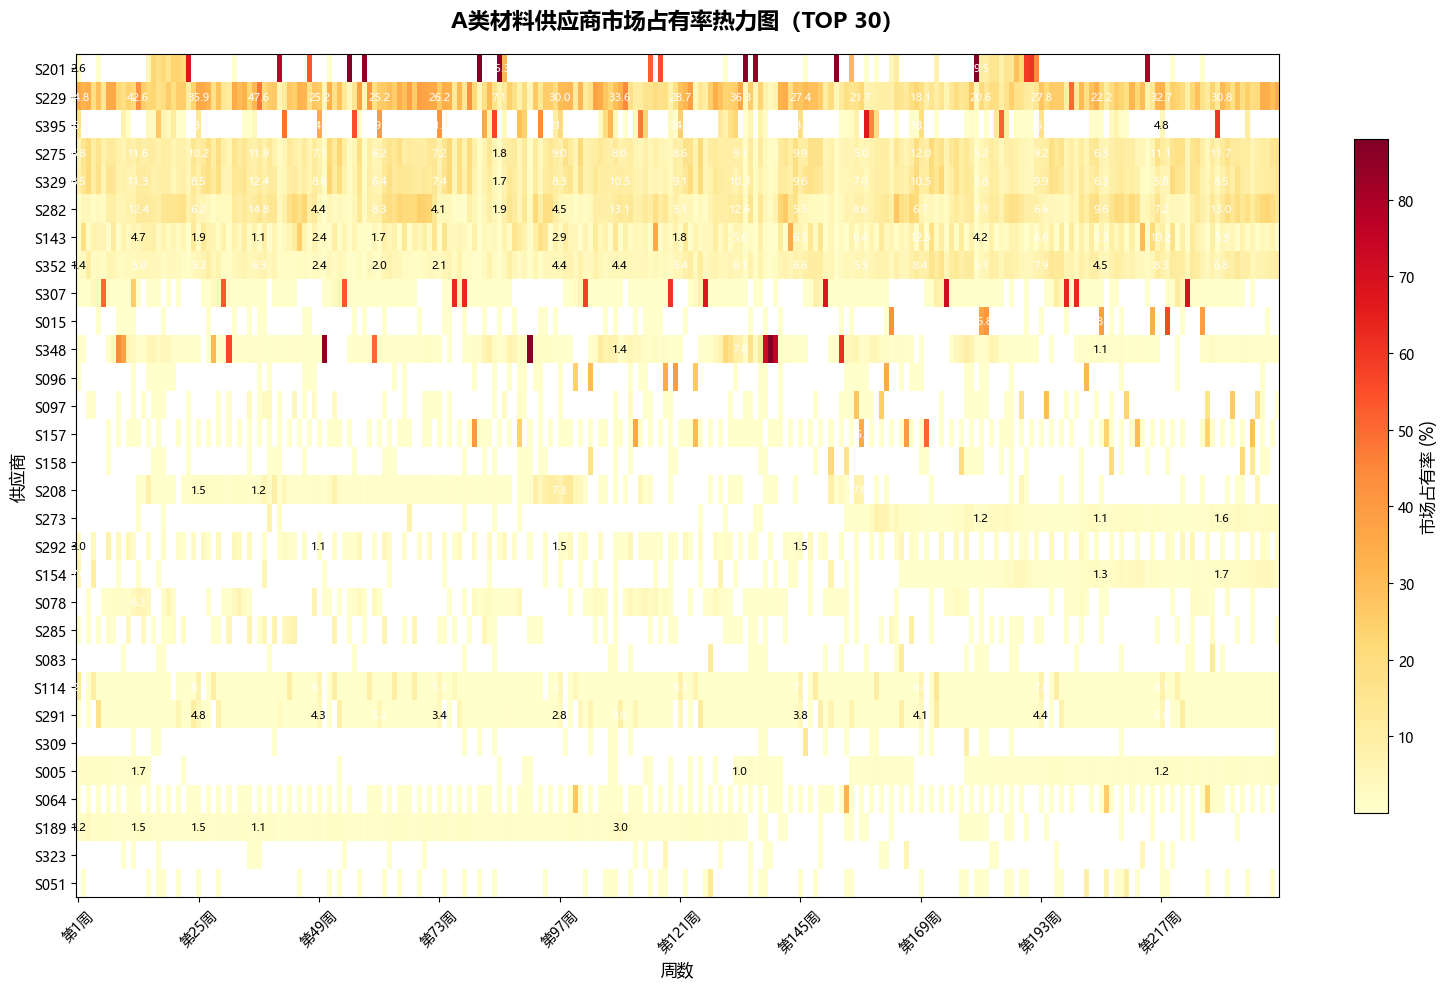

  A 类材料市场占有率统计:
    - 数据周数: 240
    - 平均市场占有率: 5.80%
    - 最高市场占有率: 87.95%
    - 最高市场占有率的供应商: S348

正在绘制 B 类材料供应商市场占有率热力图...


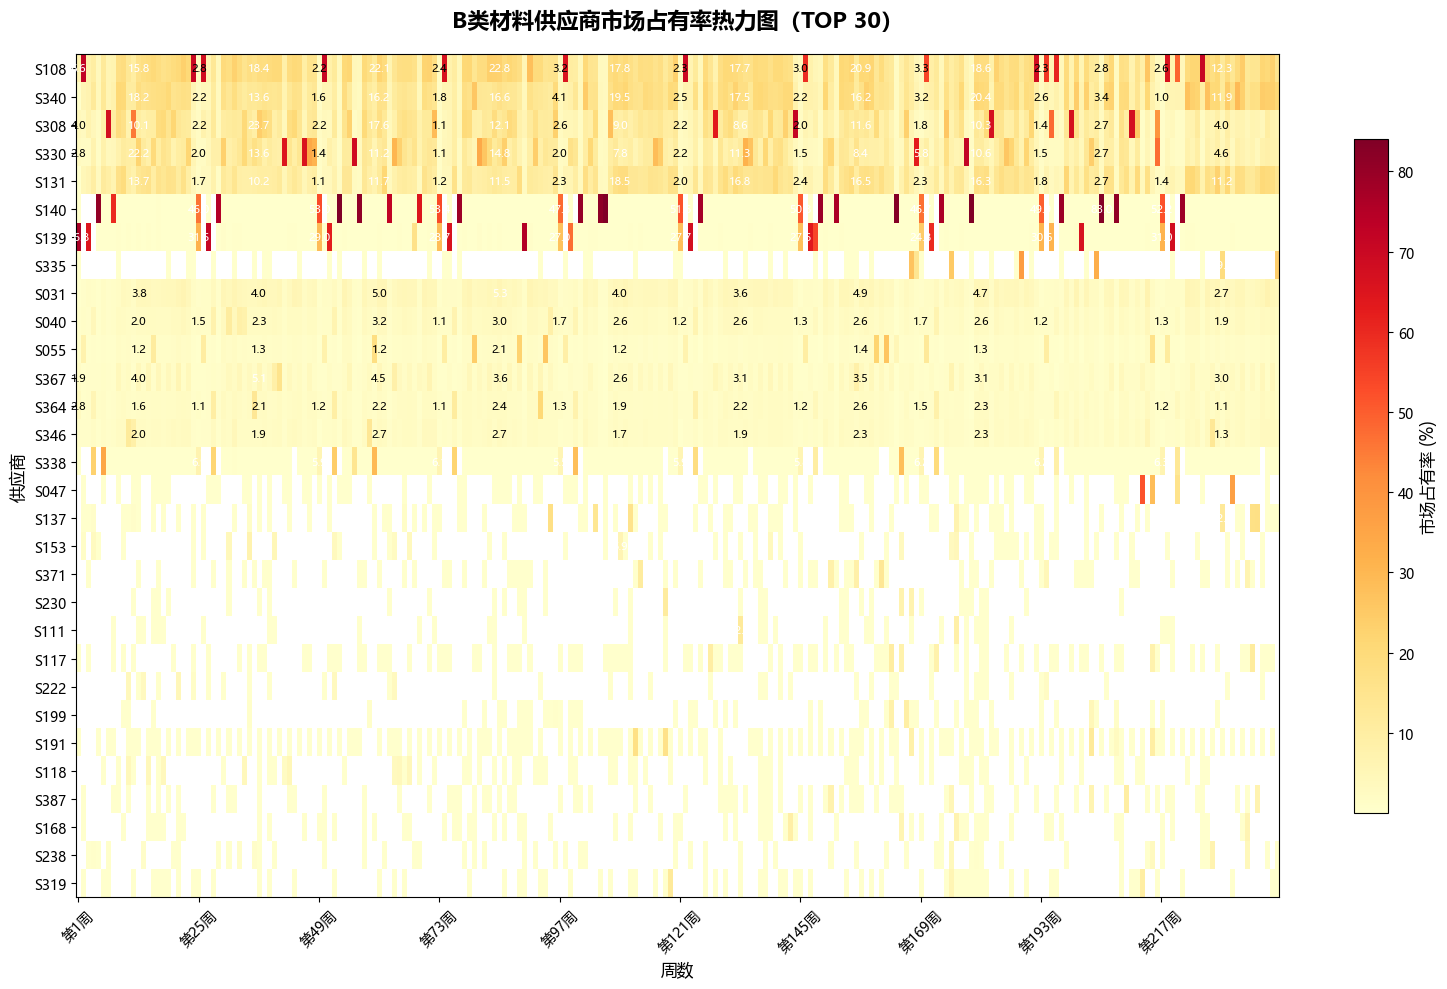

  B 类材料市场占有率统计:
    - 数据周数: 240
    - 平均市场占有率: 5.32%
    - 最高市场占有率: 84.08%
    - 最高市场占有率的供应商: S140

正在绘制 C 类材料供应商市场占有率热力图...


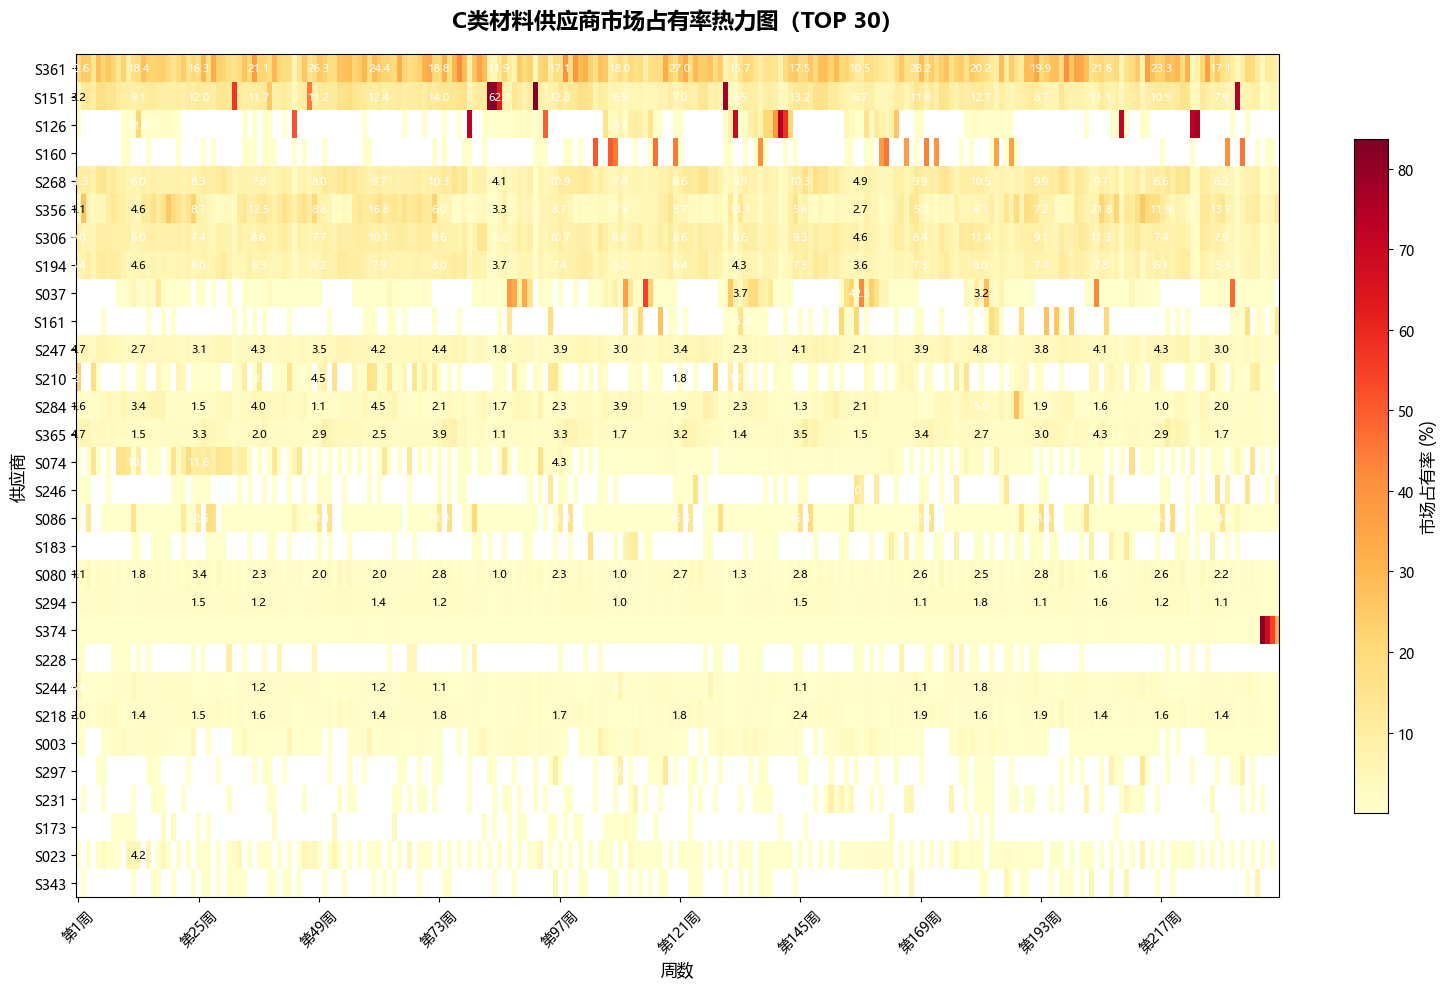

  C 类材料市场占有率统计:
    - 数据周数: 240
    - 平均市场占有率: 4.53%
    - 最高市场占有率: 83.72%
    - 最高市场占有率的供应商: S151


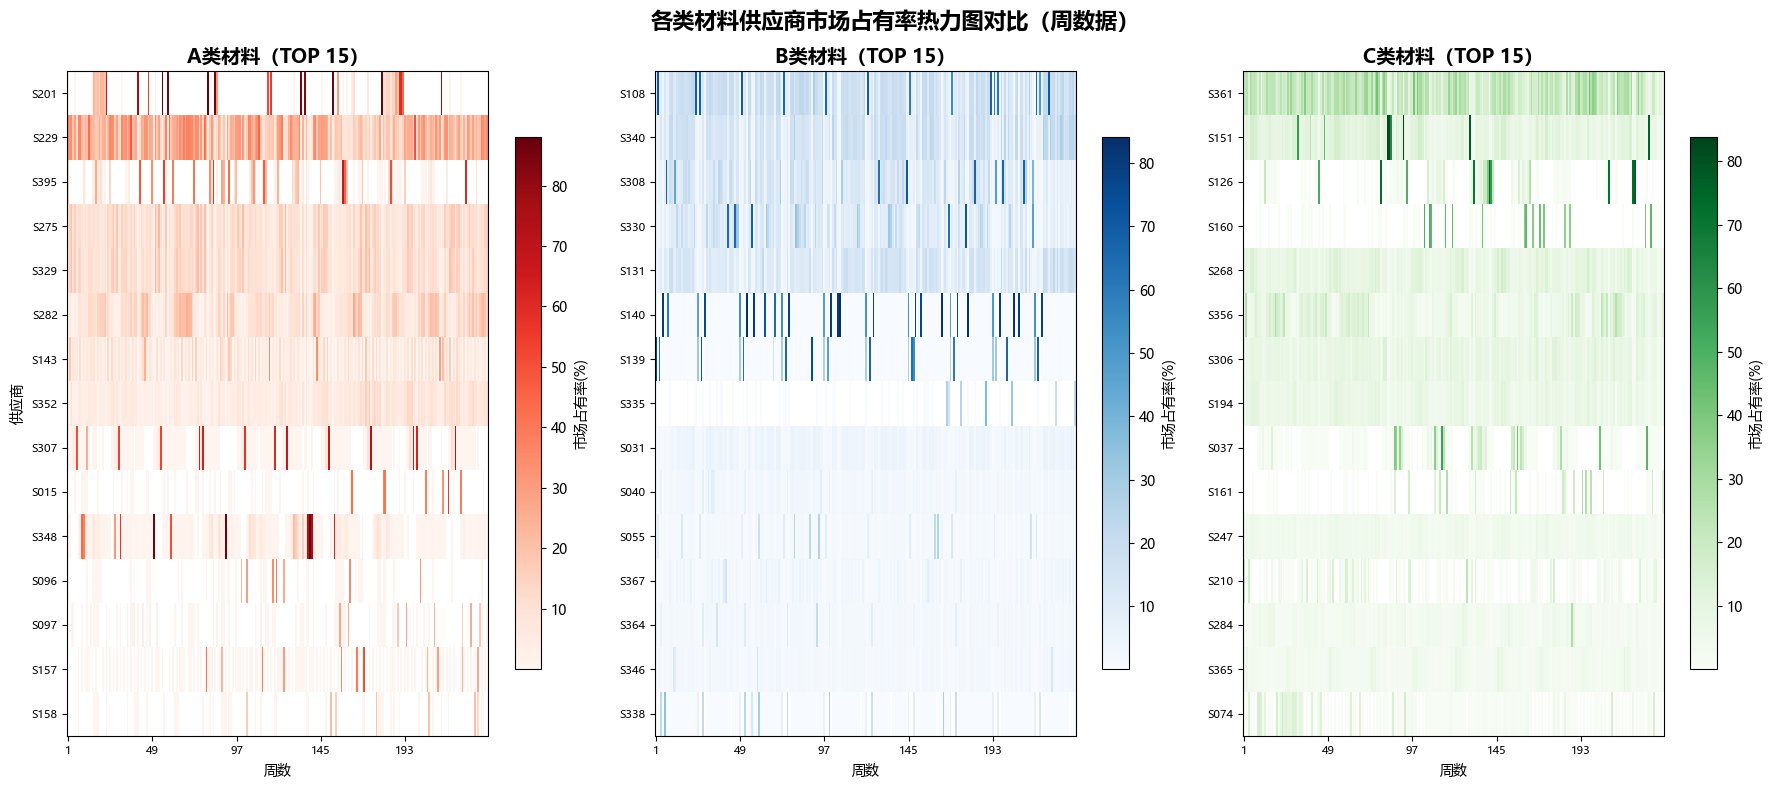


周市场占有率热力分布图绘制完成!
   已保存为SVG格式的矢量图文件

绘制年平均市场占有率热力分布图
数据分析:
  - 总周数: 240
  - 每年周数: 48
  - 完整年数: 5
  - 剩余周数: 0

正在绘制 A 类材料年平均市场占有率热力图...


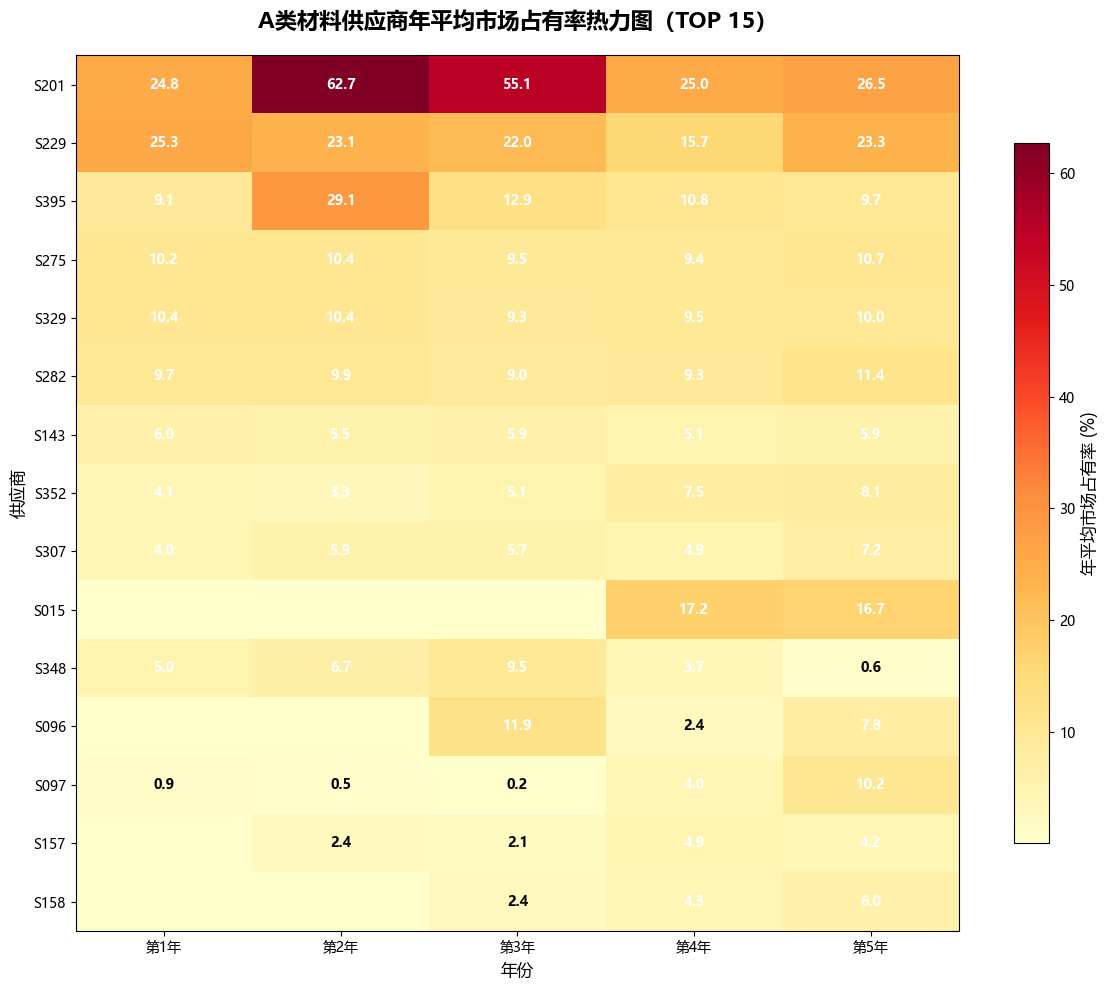

  A 类材料年度市场占有率统计:
    - 分析年数: 5
    - 平均年度市场占有率: 9.76%
    - 最高年度市场占有率: 62.71%
    - 最高表现: S201 (第2年)
    - 市场集中度变化:
      第1年 TOP5占有率: 80.5%
      第2年 TOP5占有率: 135.7%
      第3年 TOP5占有率: 111.5%
      第4年 TOP5占有率: 78.3%
      第5年 TOP5占有率: 88.6%

正在绘制 B 类材料年平均市场占有率热力图...


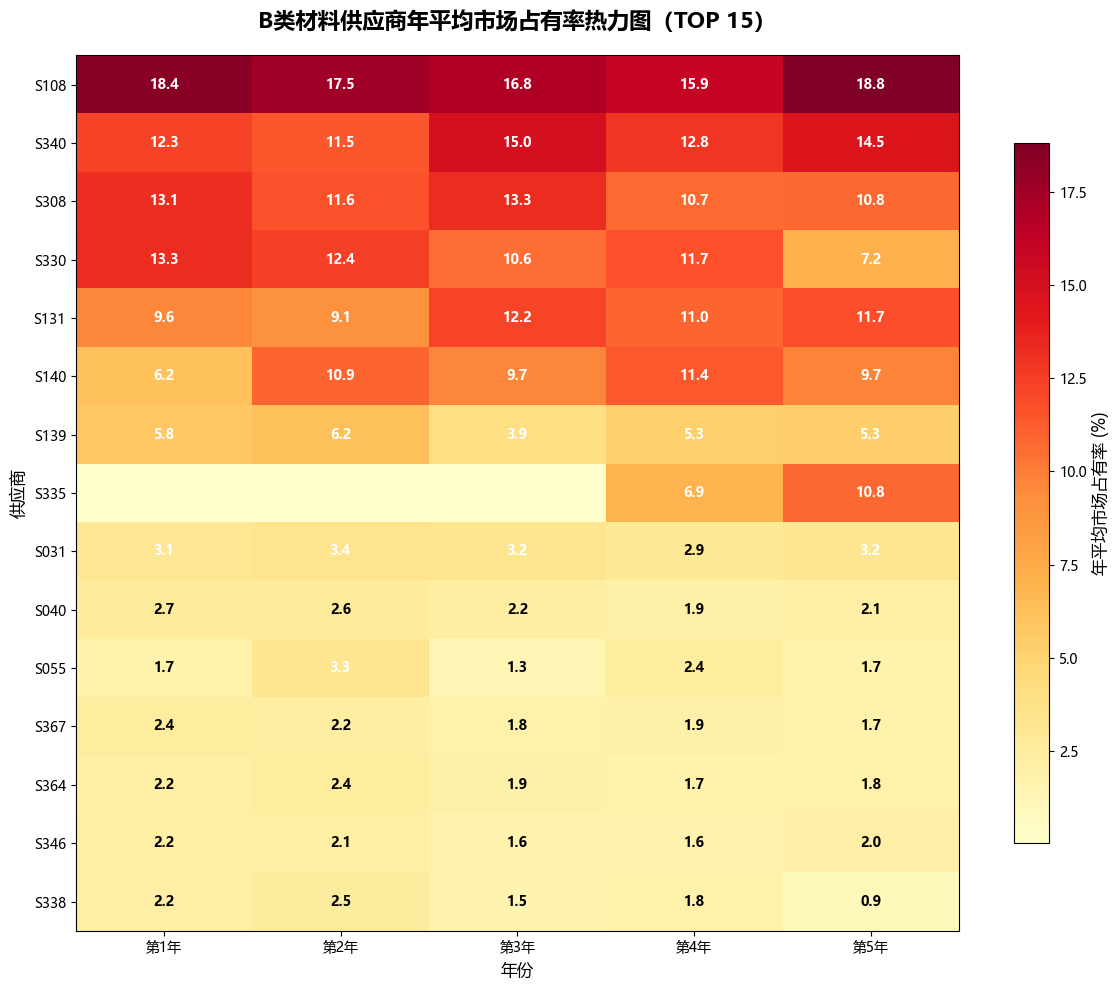

  B 类材料年度市场占有率统计:
    - 分析年数: 5
    - 平均年度市场占有率: 6.54%
    - 最高年度市场占有率: 18.81%
    - 最高表现: S108 (第5年)
    - 市场集中度变化:
      第1年 TOP5占有率: 66.8%
      第2年 TOP5占有率: 63.9%
      第3年 TOP5占有率: 67.9%
      第4年 TOP5占有率: 62.8%
      第5年 TOP5占有率: 66.7%

正在绘制 C 类材料年平均市场占有率热力图...


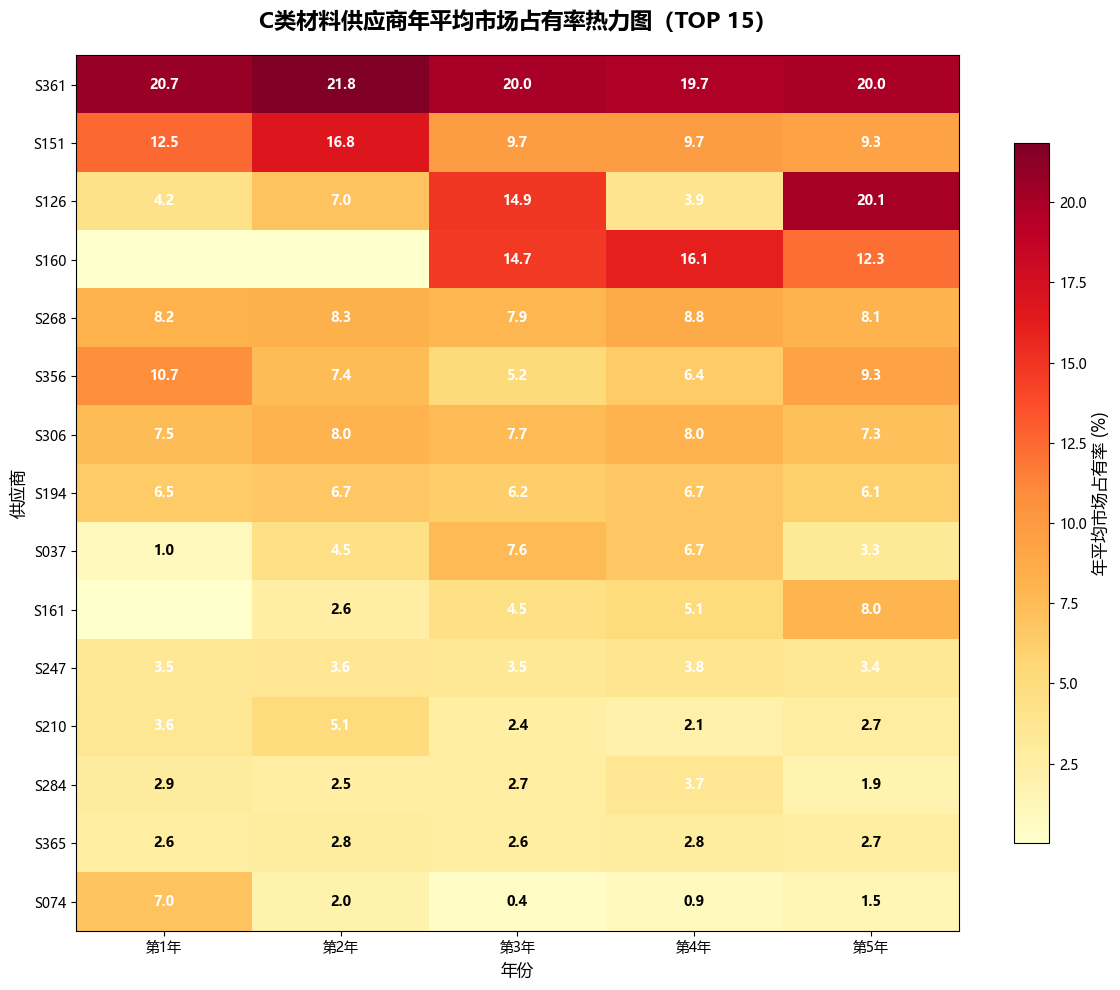

  C 类材料年度市场占有率统计:
    - 分析年数: 5
    - 平均年度市场占有率: 6.94%
    - 最高年度市场占有率: 21.85%
    - 最高表现: S361 (第2年)
    - 市场集中度变化:
      第1年 TOP5占有率: 59.6%
      第2年 TOP5占有率: 62.4%
      第3年 TOP5占有率: 67.3%
      第4年 TOP5占有率: 62.4%
      第5年 TOP5占有率: 71.0%


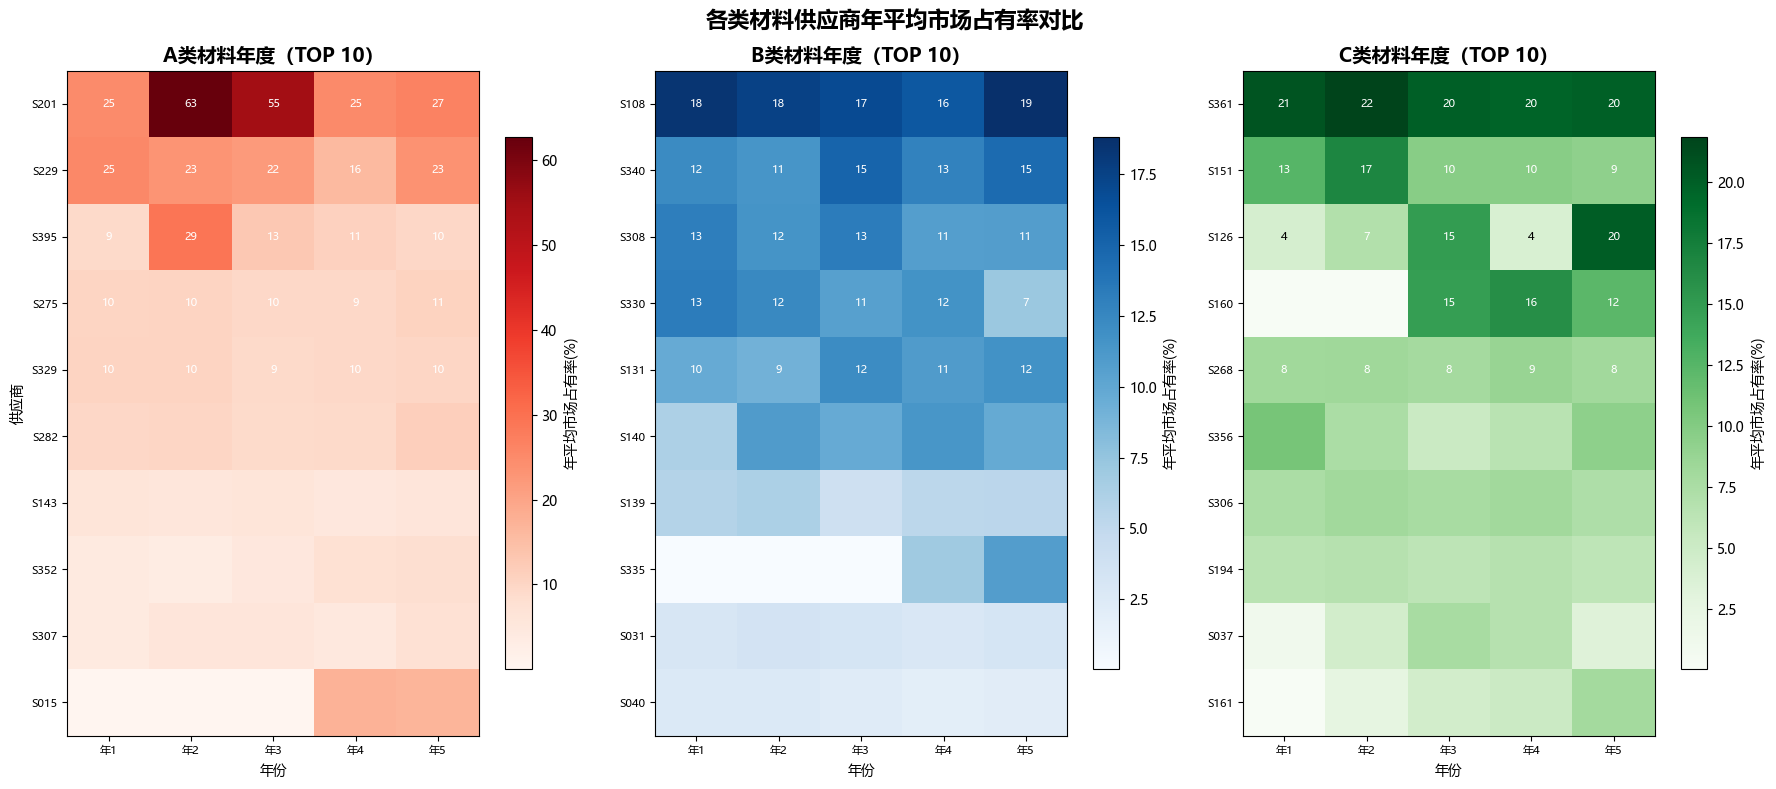


年平均市场占有率热力分布图绘制完成!
   已保存为SVG格式的矢量图文件


In [9]:

# 执行绘制函数
print("开始绘制市场占有率热力分布图...")
plot_market_share_heatmap(top_n_detail=30, top_n_comparison=15)
plot_yearly_market_share_heatmap(top_n=15)

#### 有效供货率热力图绘制


绘制有效供货率热力分布图（周数据）


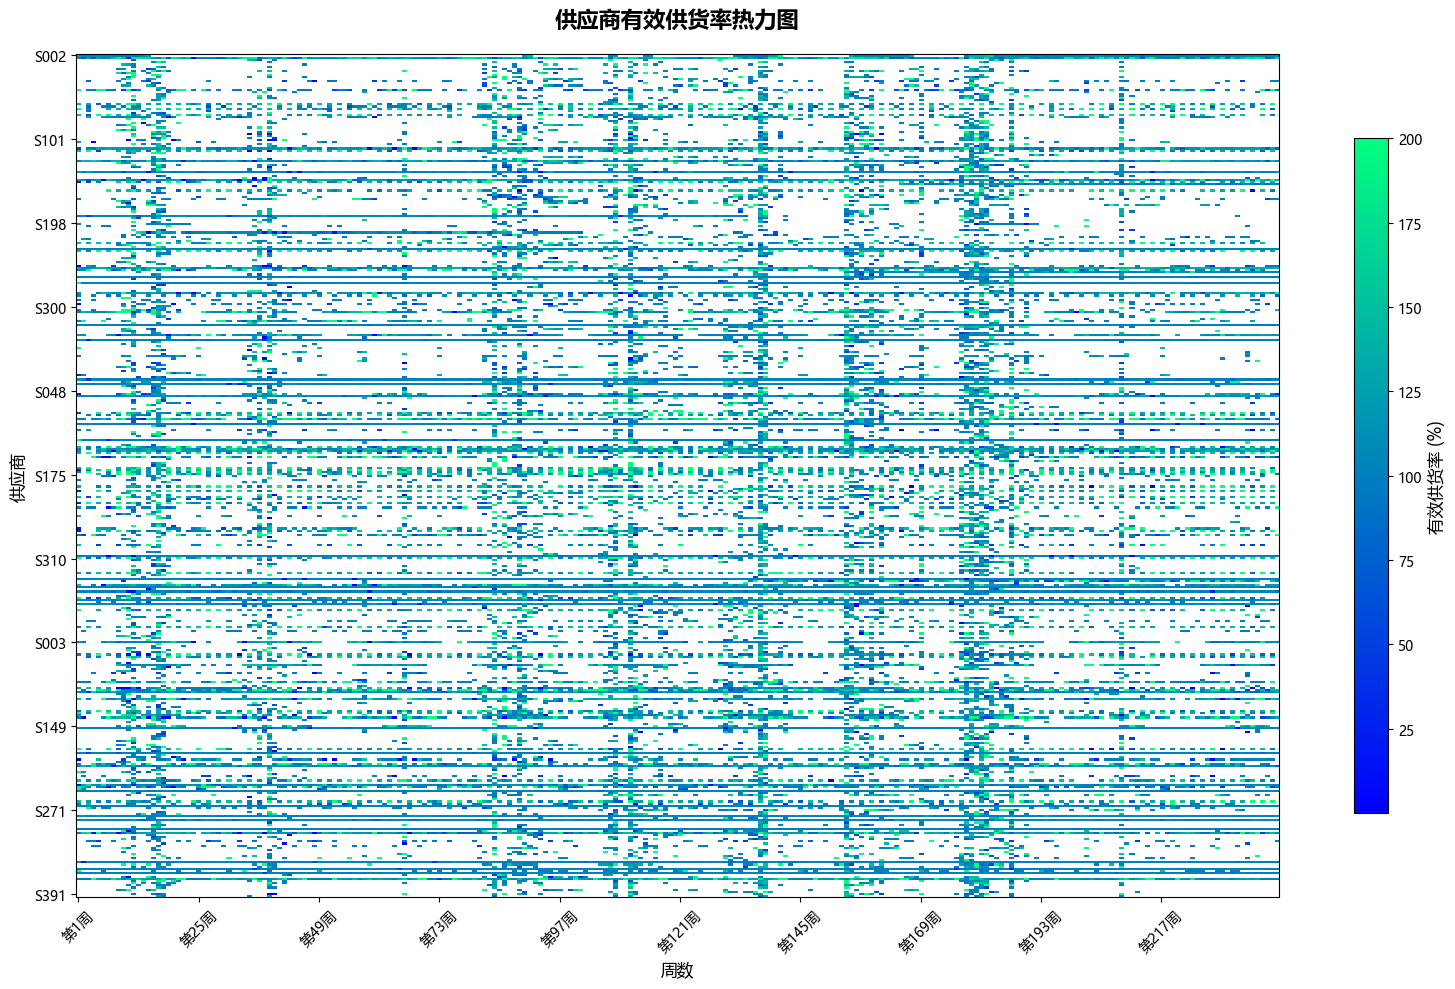

有效供货率热力分布图绘制完成！


In [10]:
import matplotlib.colors as mcolors

def plot_fulfillment_rate_heatmap():
    """
    绘制供应商有效供货率（订单满足率）热力图
    横轴为周数，纵轴为供应商，颜色为有效供货率（%），0值显示为白色
    """
    print("\n" + "="*60)
    print("绘制有效供货率热力分布图（周数据）")
    print("="*60)

    supplier_metrics_list = []
    for name, metrics in supplier_metrics.items():
        supplier_metrics_list.append({
            'supplier_name': name,
            'material_type': metrics['material_type'],
            'avg_fulfillment_rate': metrics['avg_fulfillment_rate'],
            'weekly_fulfillment_rate': metrics['weekly_fulfillment_rate']
        })
    df_metrics = pd.DataFrame(supplier_metrics_list)

    # 构建热力图数据，0值设为np.nan
    heatmap_data = np.array([np.where(x == 0, np.nan, x * 100) for x in df_metrics['weekly_fulfillment_rate']])
    supplier_names = df_metrics['supplier_name'].tolist()
    weeks = heatmap_data.shape[1]

    # 自定义colormap，NaN为白色
    cmap = plt.get_cmap('winter').copy()
    cmap.set_bad(color='white')

    plt.figure(figsize=(16, 10))
    im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest')
    plt.title(f'供应商有效供货率热力图', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('周数', fontsize=12)
    plt.ylabel('供应商', fontsize=12)
    y_ticks = range(0, len(supplier_names), max(1, len(supplier_names)//10))
    plt.yticks(y_ticks, [supplier_names[i] for i in y_ticks], fontsize=10)
    x_ticks = range(0, weeks, max(1, weeks//10))
    plt.xticks(x_ticks, [f'第{i+1}周' for i in x_ticks], rotation=45, fontsize=10)
    cbar = plt.colorbar(im, shrink=0.8)
    cbar.set_label('有效供货率 (%)', fontsize=12)
    plt.tight_layout()
    plt.savefig('Pictures/fulfillment_rate_heatmap.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    print("有效供货率热力分布图绘制完成！")

# 调用函数
plot_fulfillment_rate_heatmap()

### 绘制年度供货效率柱状图

绘制年度供货效率柱状图（前30名供应商）
数据分析:
  - 总周数: 240
  - 每年周数: 48
  - 完整年数: 5

前50名供应商材料类型分布:
material_type
C    20
A    16
B    14
Name: count, dtype: int64


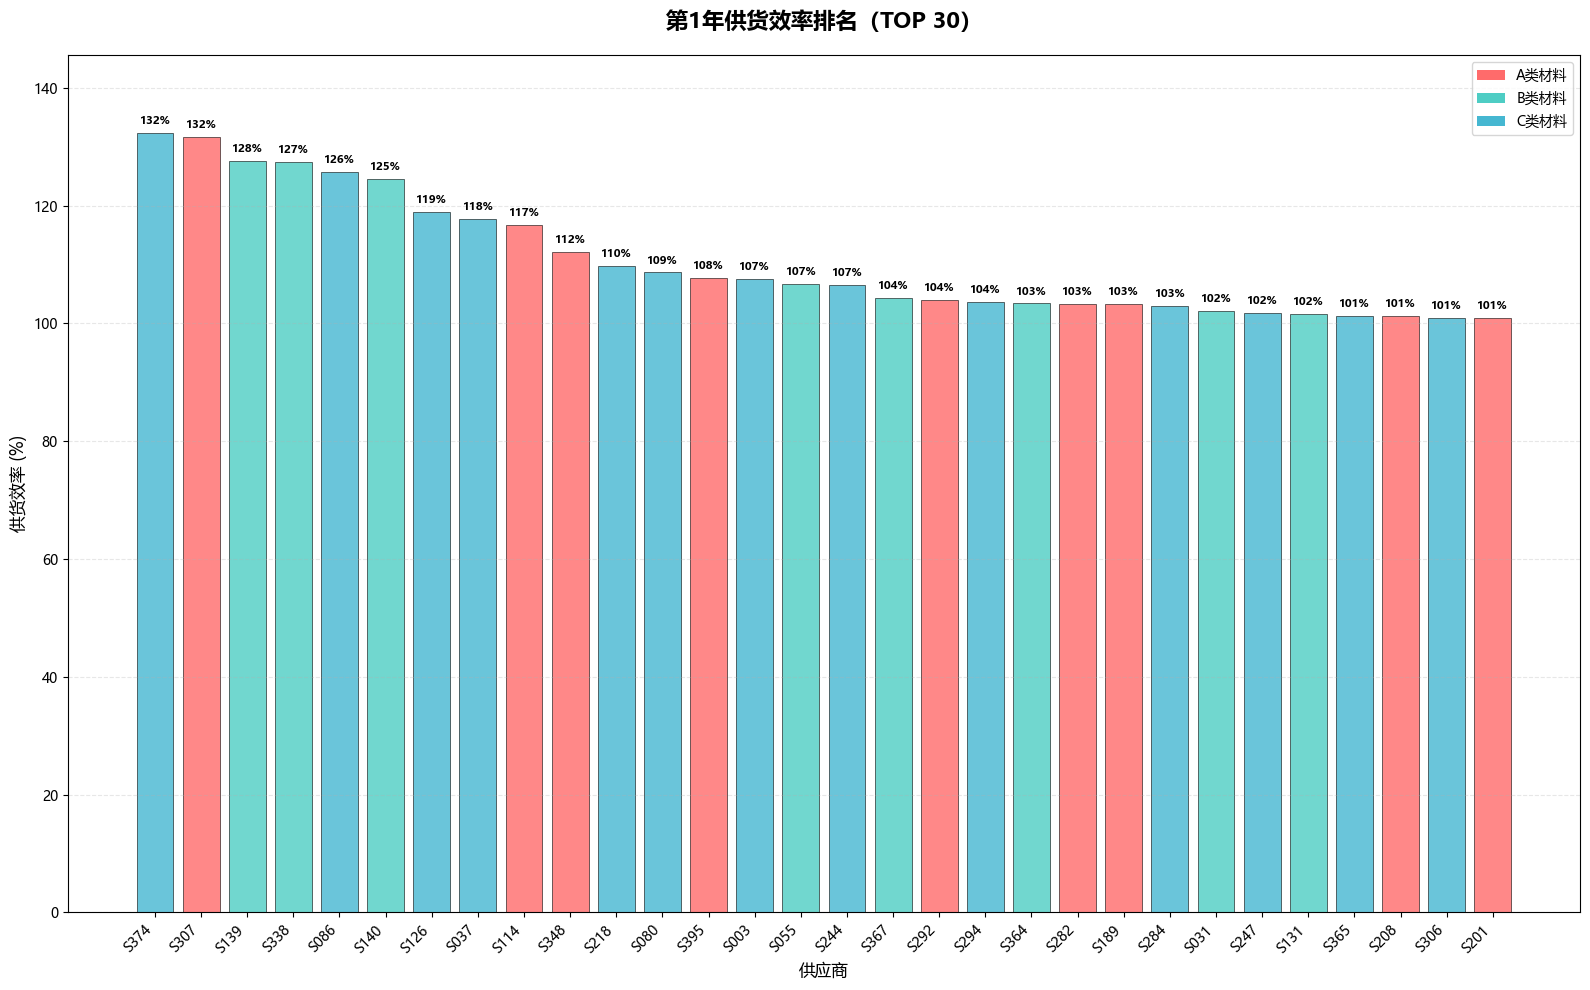

第1年供货效率图表已保存: Pictures/yearly_fulfillment_efficiency_year_1.svg


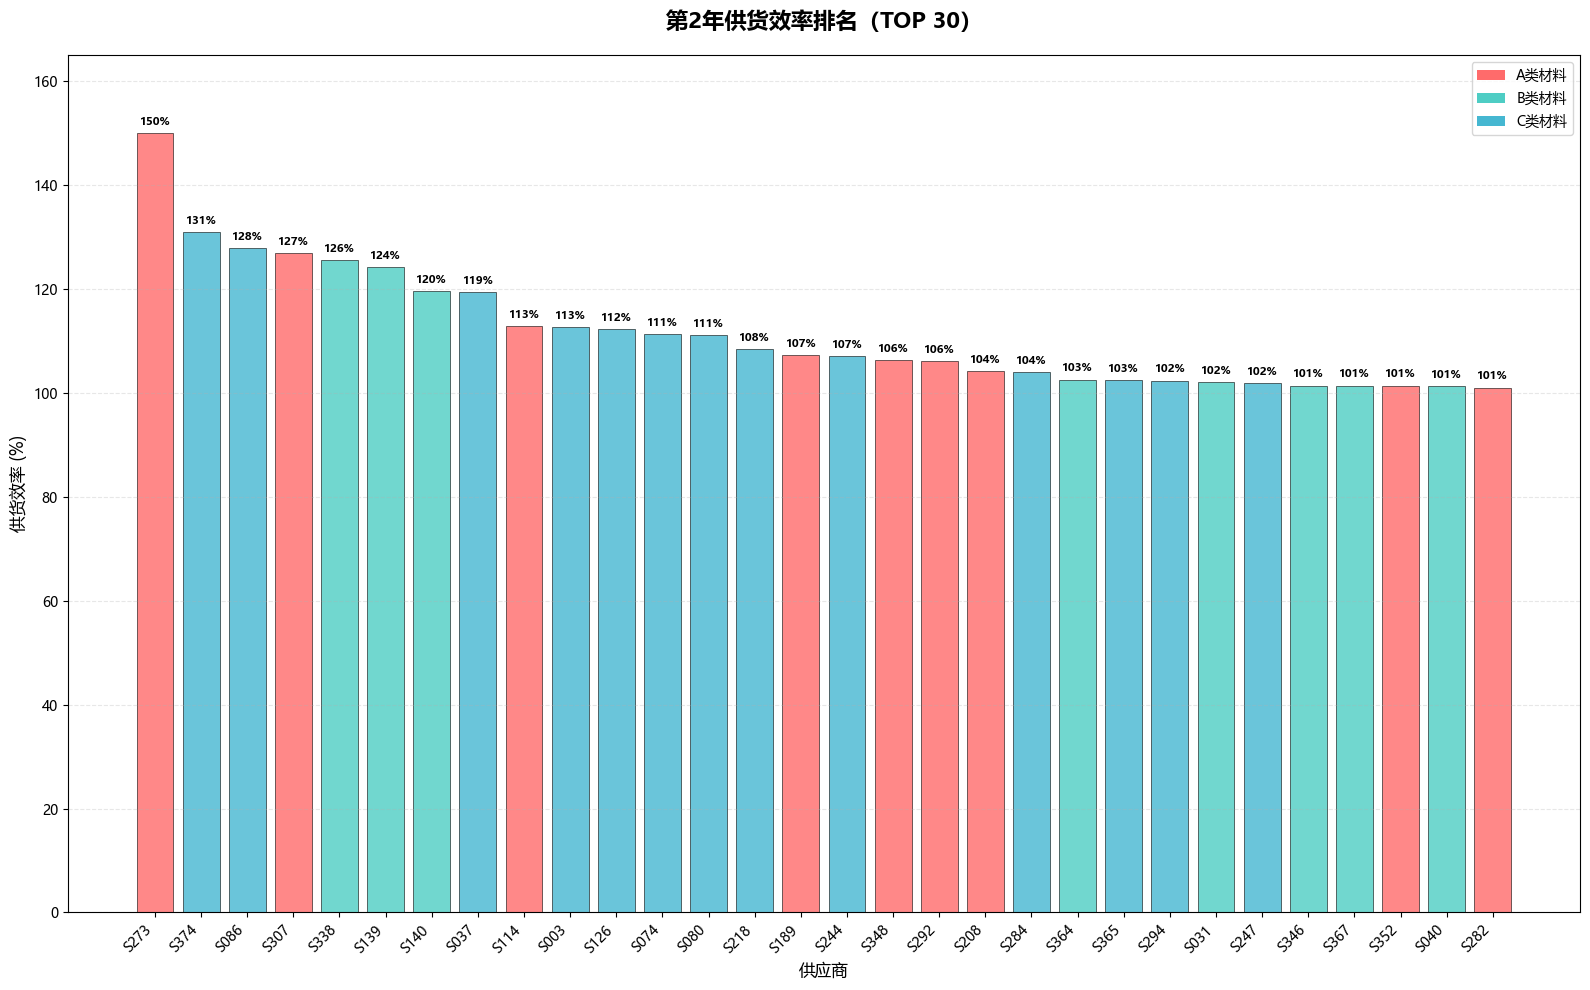

第2年供货效率图表已保存: Pictures/yearly_fulfillment_efficiency_year_2.svg


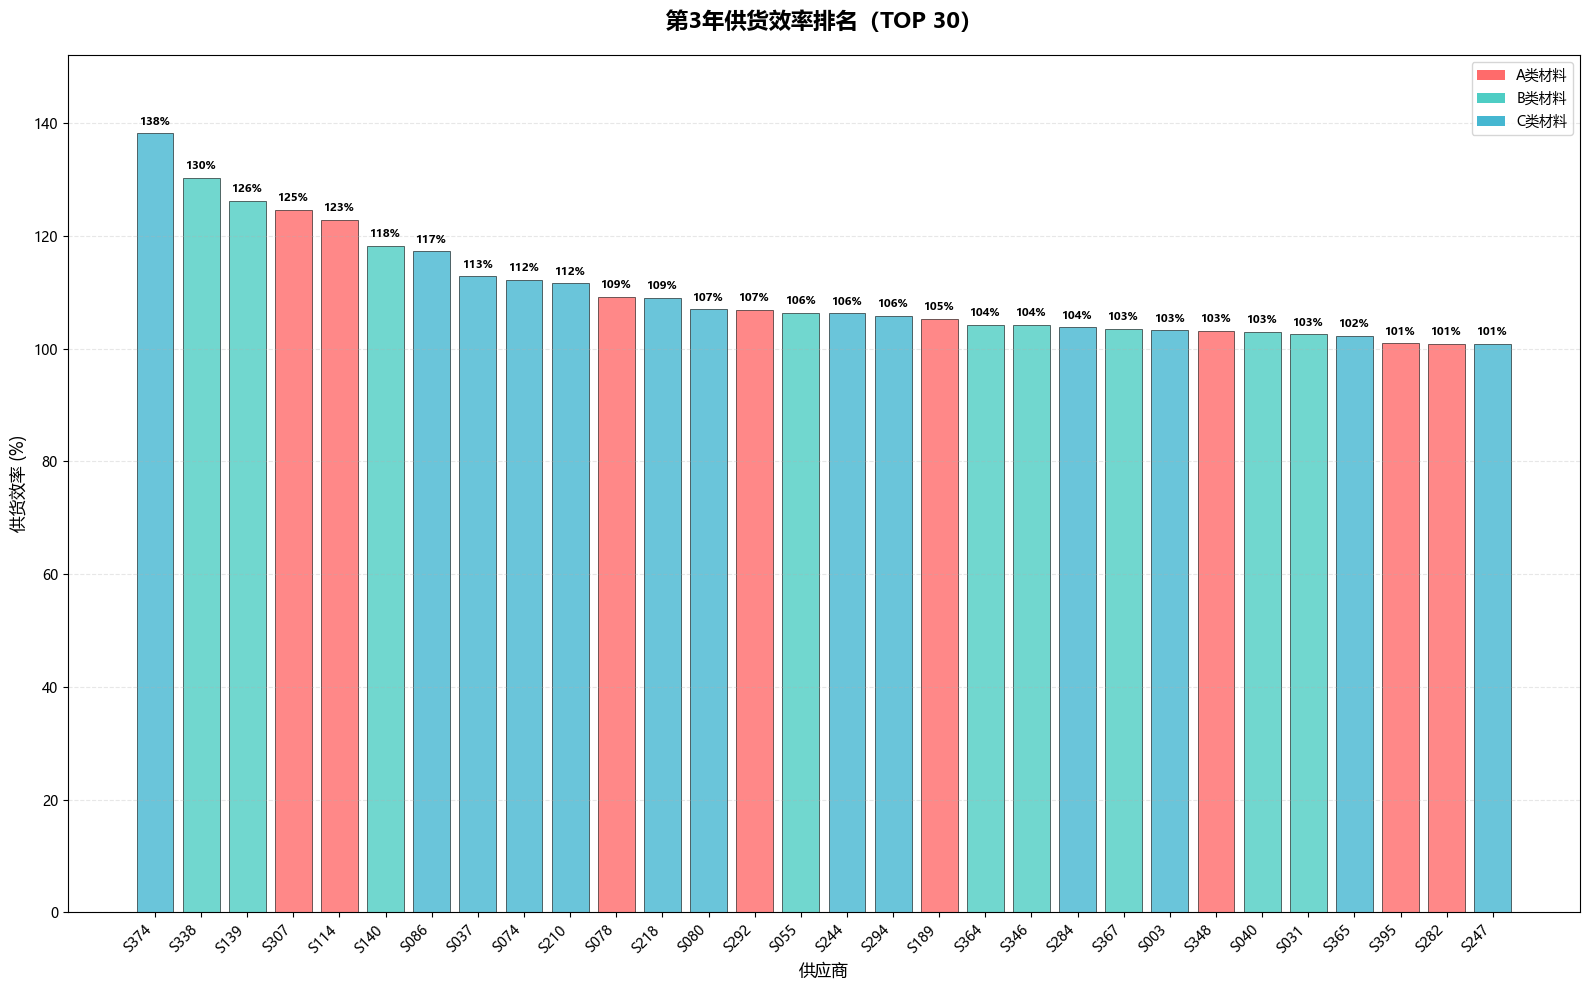

第3年供货效率图表已保存: Pictures/yearly_fulfillment_efficiency_year_3.svg


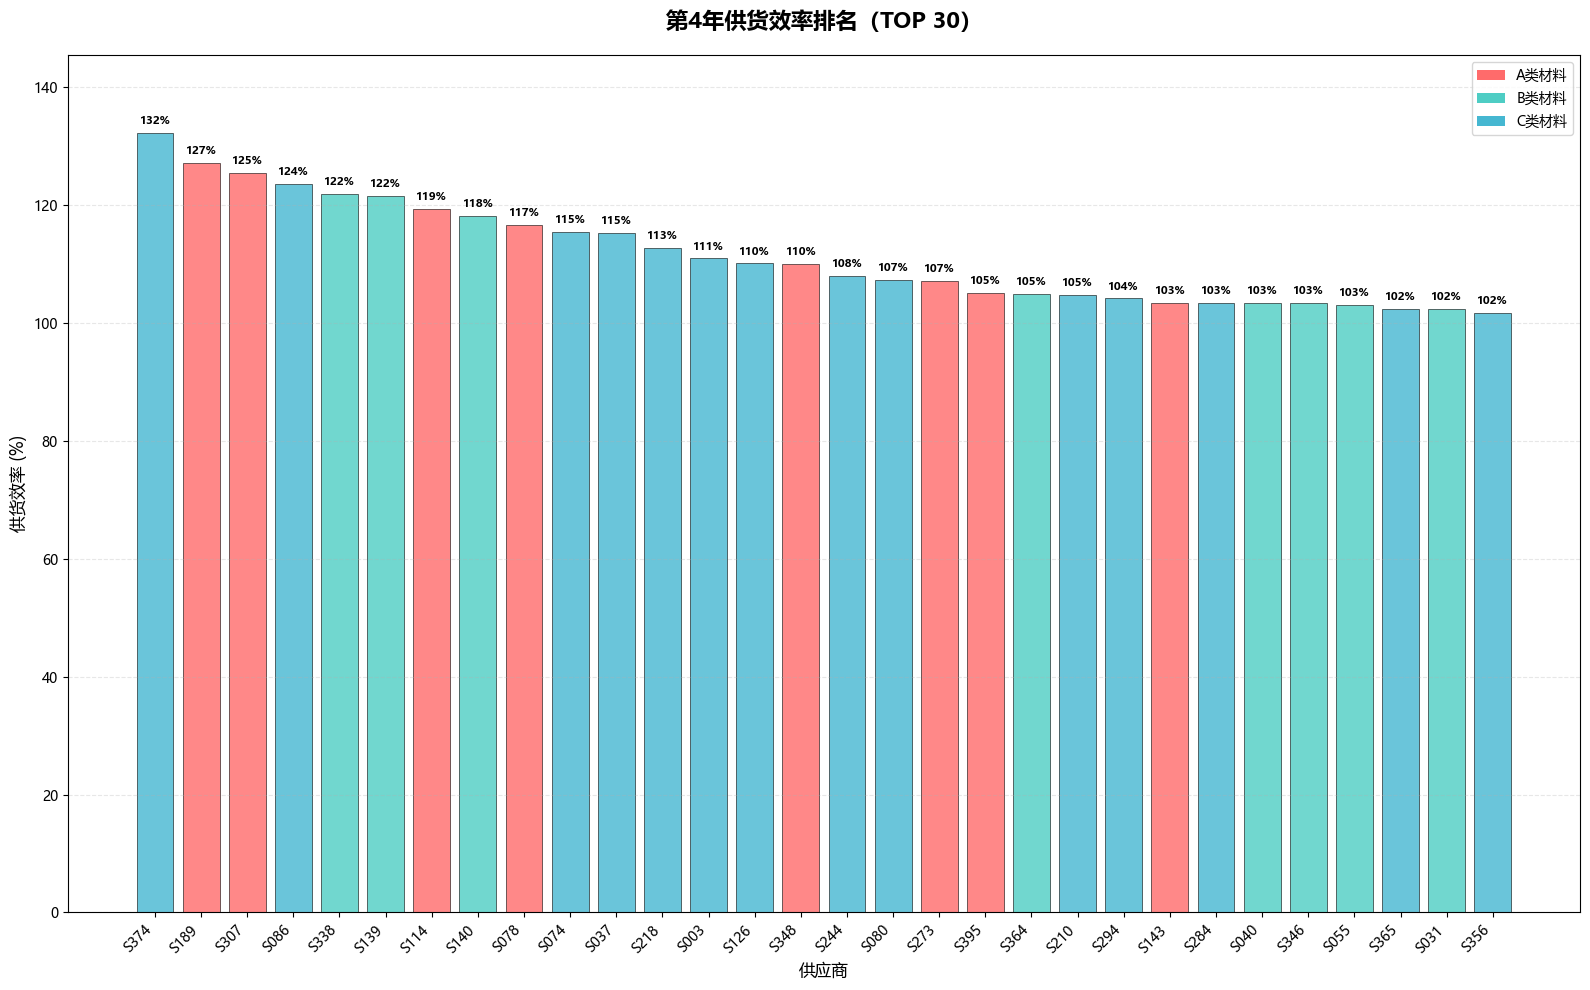

第4年供货效率图表已保存: Pictures/yearly_fulfillment_efficiency_year_4.svg


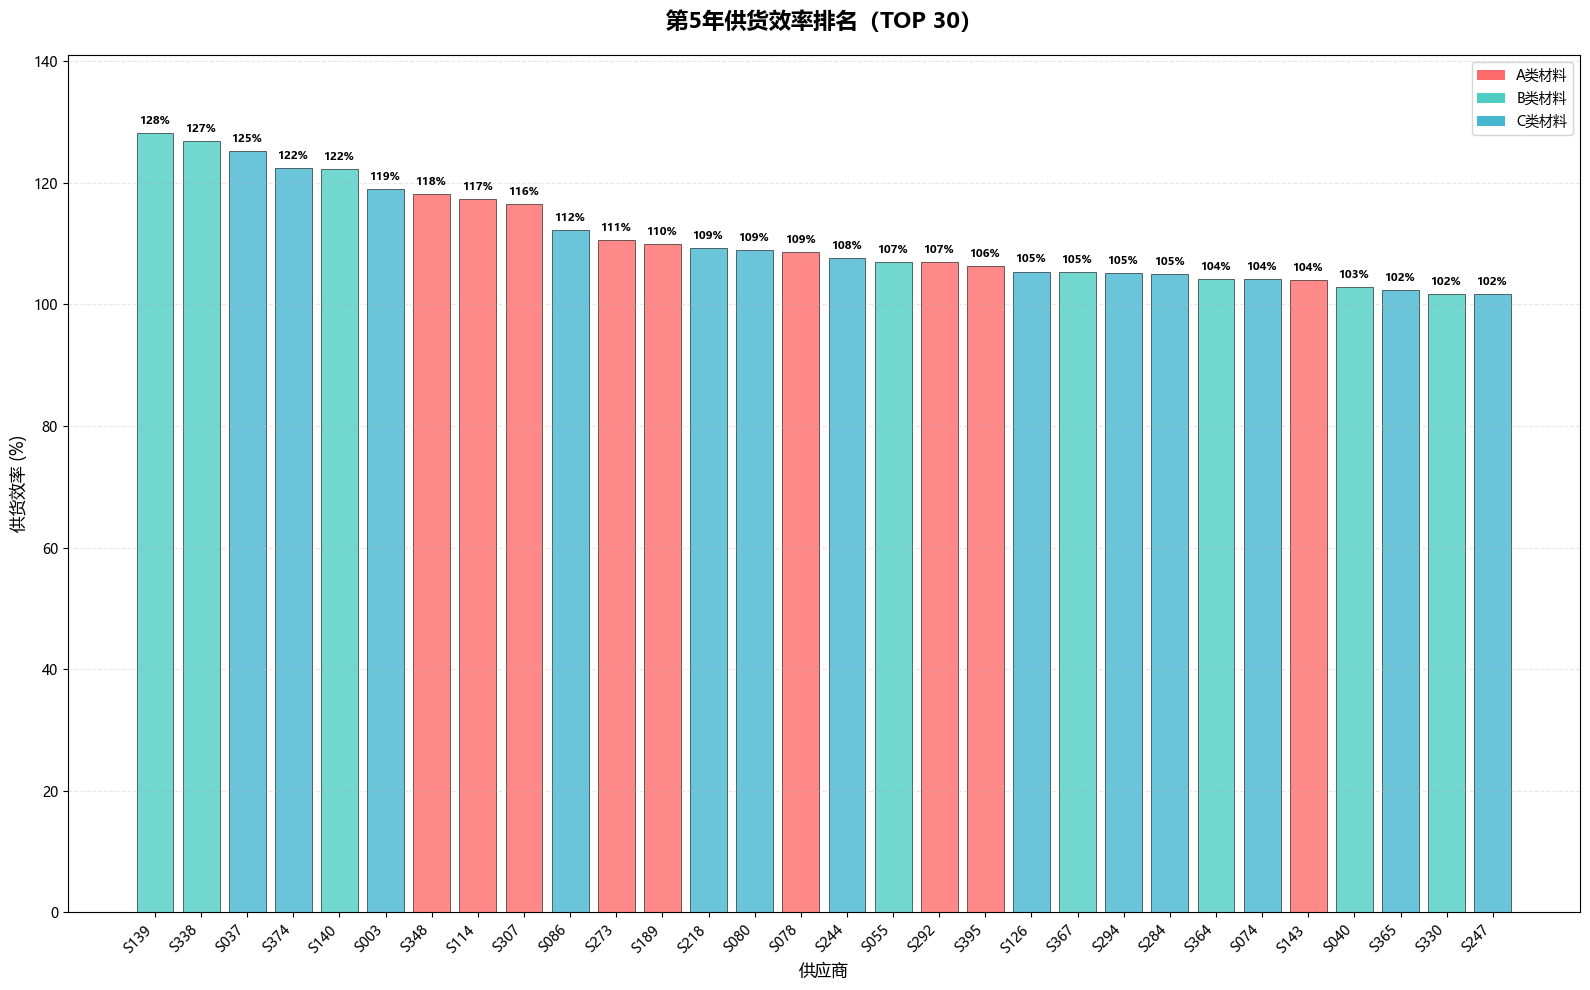

第5年供货效率图表已保存: Pictures/yearly_fulfillment_efficiency_year_5.svg

绘制TOP30供应商年度效率趋势图...


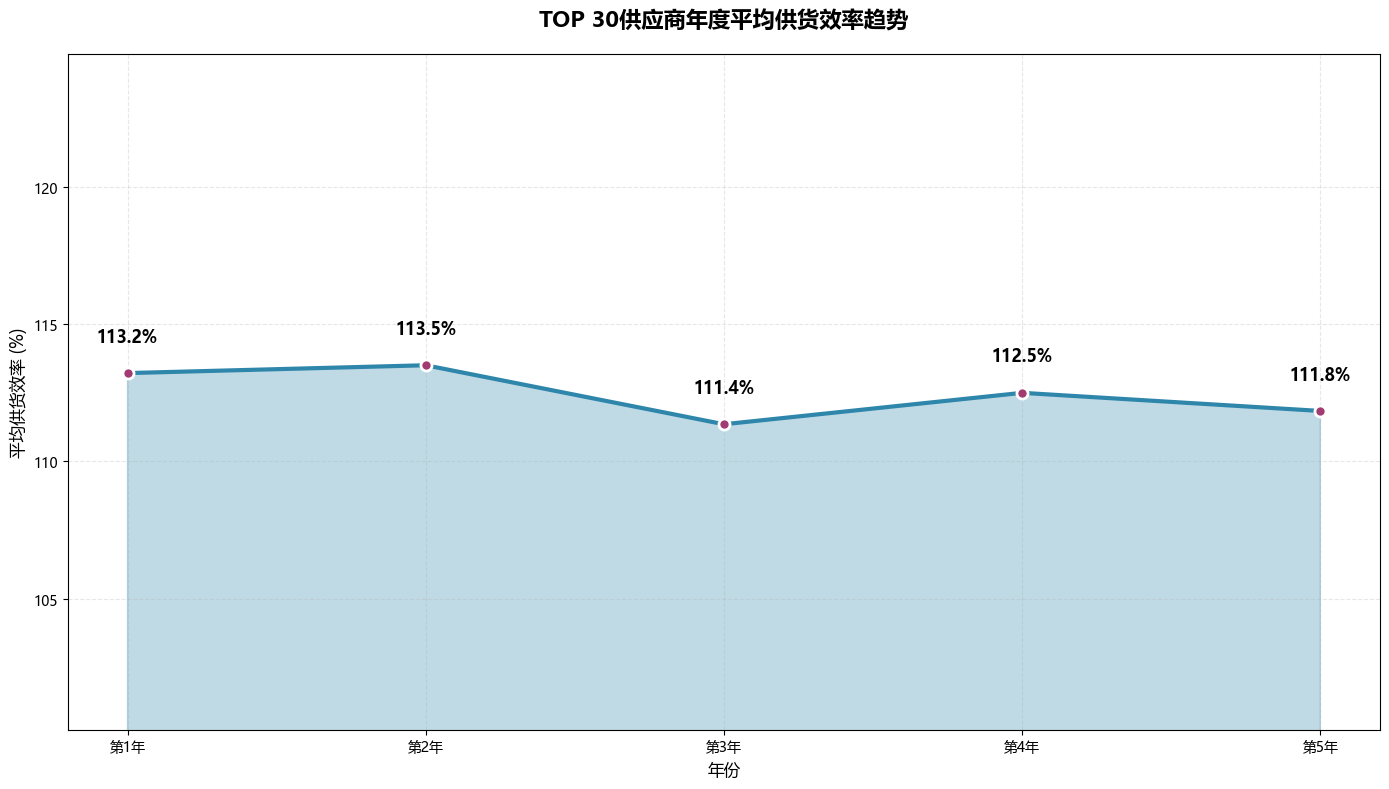


年度供货效率统计分析:
  - 分析年数: 5
  - 每年分析供应商数量: 30

  A类材料供应商表现:
    - 平均供货效率: 112.51%
    - 最高供货效率: 150.00%
    - 最佳供应商: S273

  B类材料供应商表现:
    - 平均供货效率: 112.54%
    - 最高供货效率: 130.25%
    - 最佳供应商: S338

  C类材料供应商表现:
    - 平均供货效率: 112.36%
    - 最高供货效率: 138.18%
    - 最佳供应商: S374

  年度效率趋势（TOP 30平均）:
    第1年: 113.22%
    第2年: 113.51%
    第3年: 111.36%
    第4年: 112.50%
    第5年: 111.84%
    整体趋势: -1.38% (下降)

年度供货效率柱状图绘制完成!
   已保存为SVG格式的矢量图文件


In [11]:
def plot_yearly_fulfillment_efficiency_bar_chart():
    """
    绘制年度供货效率柱状图（前30名供应商，每年单独一张图）
    
    参数:
    top_n: 显示的供应商数量 (默认30)
    """
    
    print("="*60)
    print("绘制年度供货效率柱状图（前30名供应商）")
    print("="*60)
    
    # 计算年数和每年的数据
    def calculate_yearly_efficiency_data():
        """计算每年的供货效率数据"""
        
        # 获取总周数
        first_supplier = list(supplier_metrics.values())[0]
        total_weeks = len(first_supplier['weekly_fulfillment_rate'])
        weeks_per_year = 48
        years = total_weeks // weeks_per_year
        
        print(f"数据分析:")
        print(f"  - 总周数: {total_weeks}")
        print(f"  - 每年周数: {weeks_per_year}")
        print(f"  - 完整年数: {years}")
        
        # 筛选前50名供应商（使用supplier_analysis数据）
        top_50_suppliers = supplier_analysis.nlargest(50, 'total_supply')
        
        print(f"\n前50名供应商材料类型分布:")
        import pandas as pd
        print(top_50_suppliers['material_type'].value_counts())
        
        # 为每年计算供应商的平均供货效率
        yearly_efficiency_data = {}
        
        for year in range(years):
            start_week = year * weeks_per_year
            end_week = (year + 1) * weeks_per_year
            
            supplier_year_efficiency = []
            
            for _, supplier_row in top_50_suppliers.iterrows():
                supplier_name = supplier_row['supplier_name']
                
                # 从supplier_metrics获取该供应商的周效率数据
                if supplier_name in supplier_metrics:
                    metrics = supplier_metrics[supplier_name]
                    
                    # 获取该年的周供货效率数据
                    year_efficiency = metrics['weekly_fulfillment_rate'][start_week:end_week]
                    
                    # 计算该年平均供货效率（只考虑非零值）
                    non_zero_efficiency = year_efficiency[year_efficiency > 0]
                    if len(non_zero_efficiency) > 0:
                        avg_efficiency = np.mean(non_zero_efficiency) * 100  # 转换为百分比
                    else:
                        avg_efficiency = 0
                    
                    supplier_year_efficiency.append({
                        'supplier_name': supplier_name,
                        'material_type': metrics['material_type'],
                        'efficiency': avg_efficiency,
                        'total_supply': supplier_row['total_supply']
                    })
            
            # 按效率排序，选择前30名
            supplier_year_efficiency.sort(key=lambda x: x['efficiency'], reverse=True)
            yearly_efficiency_data[year] = supplier_year_efficiency[:30]
        
        return yearly_efficiency_data, years
    
    # 计算年度数据
    yearly_data, years = calculate_yearly_efficiency_data()
    
    if years < 1:
        print("数据不足一年，无法绘制年度效率图")
        return
    
    # 为每年绘制单独的图表
    for year in range(years):
        year_data = yearly_data[year]
        
        if not year_data:
            continue
        
        # 创建图表
        plt.figure(figsize=(16, 10))
        
        # 准备数据
        suppliers = [item['supplier_name'] for item in year_data]
        efficiencies = [item['efficiency'] for item in year_data]
        materials = [item['material_type'] for item in year_data]
        
        # 为不同材料类型设置颜色
        colors = ['#FF6B6B' if mat == 'A' else '#4ECDC4' if mat == 'B' else '#45B7D1' for mat in materials]
        
        # 绘制柱状图
        bars = plt.bar(range(len(suppliers)), efficiencies, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # 设置图表属性
        plt.title(f'第{year+1}年供货效率排名（TOP 30）', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('供应商', fontsize=12)
        plt.ylabel('供货效率 (%)', fontsize=12)
        
        # 设置x轴标签
        plt.xticks(range(len(suppliers)), suppliers, rotation=45, ha='right', fontsize=10)
        
        # 添加网格
        plt.grid(axis='y', alpha=0.3, linestyle='--')
        
        # 添加数值标签
        for i, (bar, efficiency) in enumerate(zip(bars, efficiencies)):
            if efficiency > 0:
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{efficiency:.0f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        # 添加图例
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#FF6B6B', label='A类材料'),
            Patch(facecolor='#4ECDC4', label='B类材料'),
            Patch(facecolor='#45B7D1', label='C类材料')
        ]
        plt.legend(handles=legend_elements, loc='upper right', fontsize=10)
        
        # 设置y轴范围
        plt.ylim(0, max(efficiencies) * 1.1 if efficiencies else 100)
        
        # 调整布局
        plt.tight_layout()
        
        # 保存图片
        filename = f'Pictures/yearly_fulfillment_efficiency_year_{year+1}.svg'
        plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"第{year+1}年供货效率图表已保存: {filename}")
    
    # 绘制TOP30趋势图
    print("\n绘制TOP30供应商年度效率趋势图...")
    
    # 计算整体效率最高的30名供应商
    all_supplier_avg_efficiency = {}
    
    for year in range(years):
        year_data = yearly_data[year]
        for item in year_data:
            supplier = item['supplier_name']
            if supplier not in all_supplier_avg_efficiency:
                all_supplier_avg_efficiency[supplier] = []
            all_supplier_avg_efficiency[supplier].append(item['efficiency'])
    
    # 计算每个供应商的平均效率
    supplier_overall_avg = {}
    for supplier, efficiencies in all_supplier_avg_efficiency.items():
        supplier_overall_avg[supplier] = np.mean(efficiencies)
    
    # 选择TOP30
    top_30_suppliers = sorted(supplier_overall_avg.items(), key=lambda x: x[1], reverse=True)[:30]
    top_30_names = [item[0] for item in top_30_suppliers]
    
    # 绘制趋势图
    plt.figure(figsize=(14, 8))
    
    # 计算每年的平均效率
    yearly_averages = []
    for year in range(years):
        year_efficiencies = []
        year_data = yearly_data[year]
        
        for item in year_data:
            if item['supplier_name'] in top_30_names:
                year_efficiencies.append(item['efficiency'])
        
        if year_efficiencies:
            yearly_averages.append(np.mean(year_efficiencies))
        else:
            yearly_averages.append(0)
    
    # 绘制趋势线
    years_labels = [f'第{i+1}年' for i in range(years)]
    plt.plot(years_labels, yearly_averages, marker='o', linewidth=3, markersize=8, 
             color='#2E86AB', markerfacecolor='#A23B72', markeredgecolor='white', markeredgewidth=2)
    
    # 填充区域
    plt.fill_between(years_labels, yearly_averages, alpha=0.3, color='#2E86AB')
    
    # 添加数值标签
    for i, avg in enumerate(yearly_averages):
        plt.text(i, avg + 1, f'{avg:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # 设置图表属性
    plt.title('TOP 30供应商年度平均供货效率趋势', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('年份', fontsize=12)
    plt.ylabel('平均供货效率 (%)', fontsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # 设置y轴范围
    if yearly_averages:
        y_min = min(yearly_averages) * 0.9
        y_max = max(yearly_averages) * 1.1
        plt.ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.savefig('Pictures/top30_yearly_efficiency_trend.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 统计分析
    print(f"\n年度供货效率统计分析:")
    print(f"  - 分析年数: {years}")
    print(f"  - 每年分析供应商数量: 30")
    
    # 分材料类型统计
    for material in ['A', 'B', 'C']:
        material_efficiencies = []
        material_suppliers = []
        
        for year in range(years):
            year_data = yearly_data[year]
            for item in year_data:
                if item['material_type'] == material and item['supplier_name'] in top_30_names:
                    material_efficiencies.append(item['efficiency'])
                    material_suppliers.append(item['supplier_name'])
        
        if material_efficiencies:
            avg_efficiency = np.mean(material_efficiencies)
            max_efficiency = max(material_efficiencies)
            best_supplier_idx = material_efficiencies.index(max_efficiency)
            best_supplier = material_suppliers[best_supplier_idx]
            
            print(f"\n  {material}类材料供应商表现:")
            print(f"    - 平均供货效率: {avg_efficiency:.2f}%")
            print(f"    - 最高供货效率: {max_efficiency:.2f}%")
            print(f"    - 最佳供应商: {best_supplier}")
    
    # 年度趋势分析
    if len(yearly_averages) > 1:
        trend = yearly_averages[-1] - yearly_averages[0]
        print(f"\n  年度效率趋势（TOP 30平均）:")
        for i, avg in enumerate(yearly_averages):
            print(f"    第{i+1}年: {avg:.2f}%")
        print(f"    整体趋势: {'+' if trend > 0 else ''}{trend:.2f}% ({'提升' if trend > 0 else '下降'})")
    
    print(f"\n年度供货效率柱状图绘制完成!")
    print(f"   已保存为SVG格式的矢量图文件")

# 调用函数绘制年度供货效率柱状图
plot_yearly_fulfillment_efficiency_bar_chart()

### 绘制订货规模（原材料制造出的产品总量）热力图，并输出到表格


订货规模（原材料制造出的产品总量）热力图分析
订货规模计算完成！
分析了402家供应商的产品制造能力

各材料类型产品制造能力统计:
  A类材料 (146家供应商):
    - 总产品制造能力: 2,421,762 m³
    - 平均周产品制造能力: 118.3 m³
    - 最大周产品制造能力: 61,620 m³
  B类材料 (134家供应商):
    - 总产品制造能力: 2,270,700 m³
    - 平均周产品制造能力: 77.5 m³
    - 最大周产品制造能力: 32,262 m³
  C类材料 (122家供应商):
    - 总产品制造能力: 2,011,510 m³
    - 平均周产品制造能力: 78.4 m³
    - 最大周产品制造能力: 32,910 m³

正在绘制A类材料产品制造能力热力图...
  ✓ 已保存: Pictures/production_scale_heatmap_A.svg
  ✓ 已保存: Pictures/production_scale_heatmap_A.svg


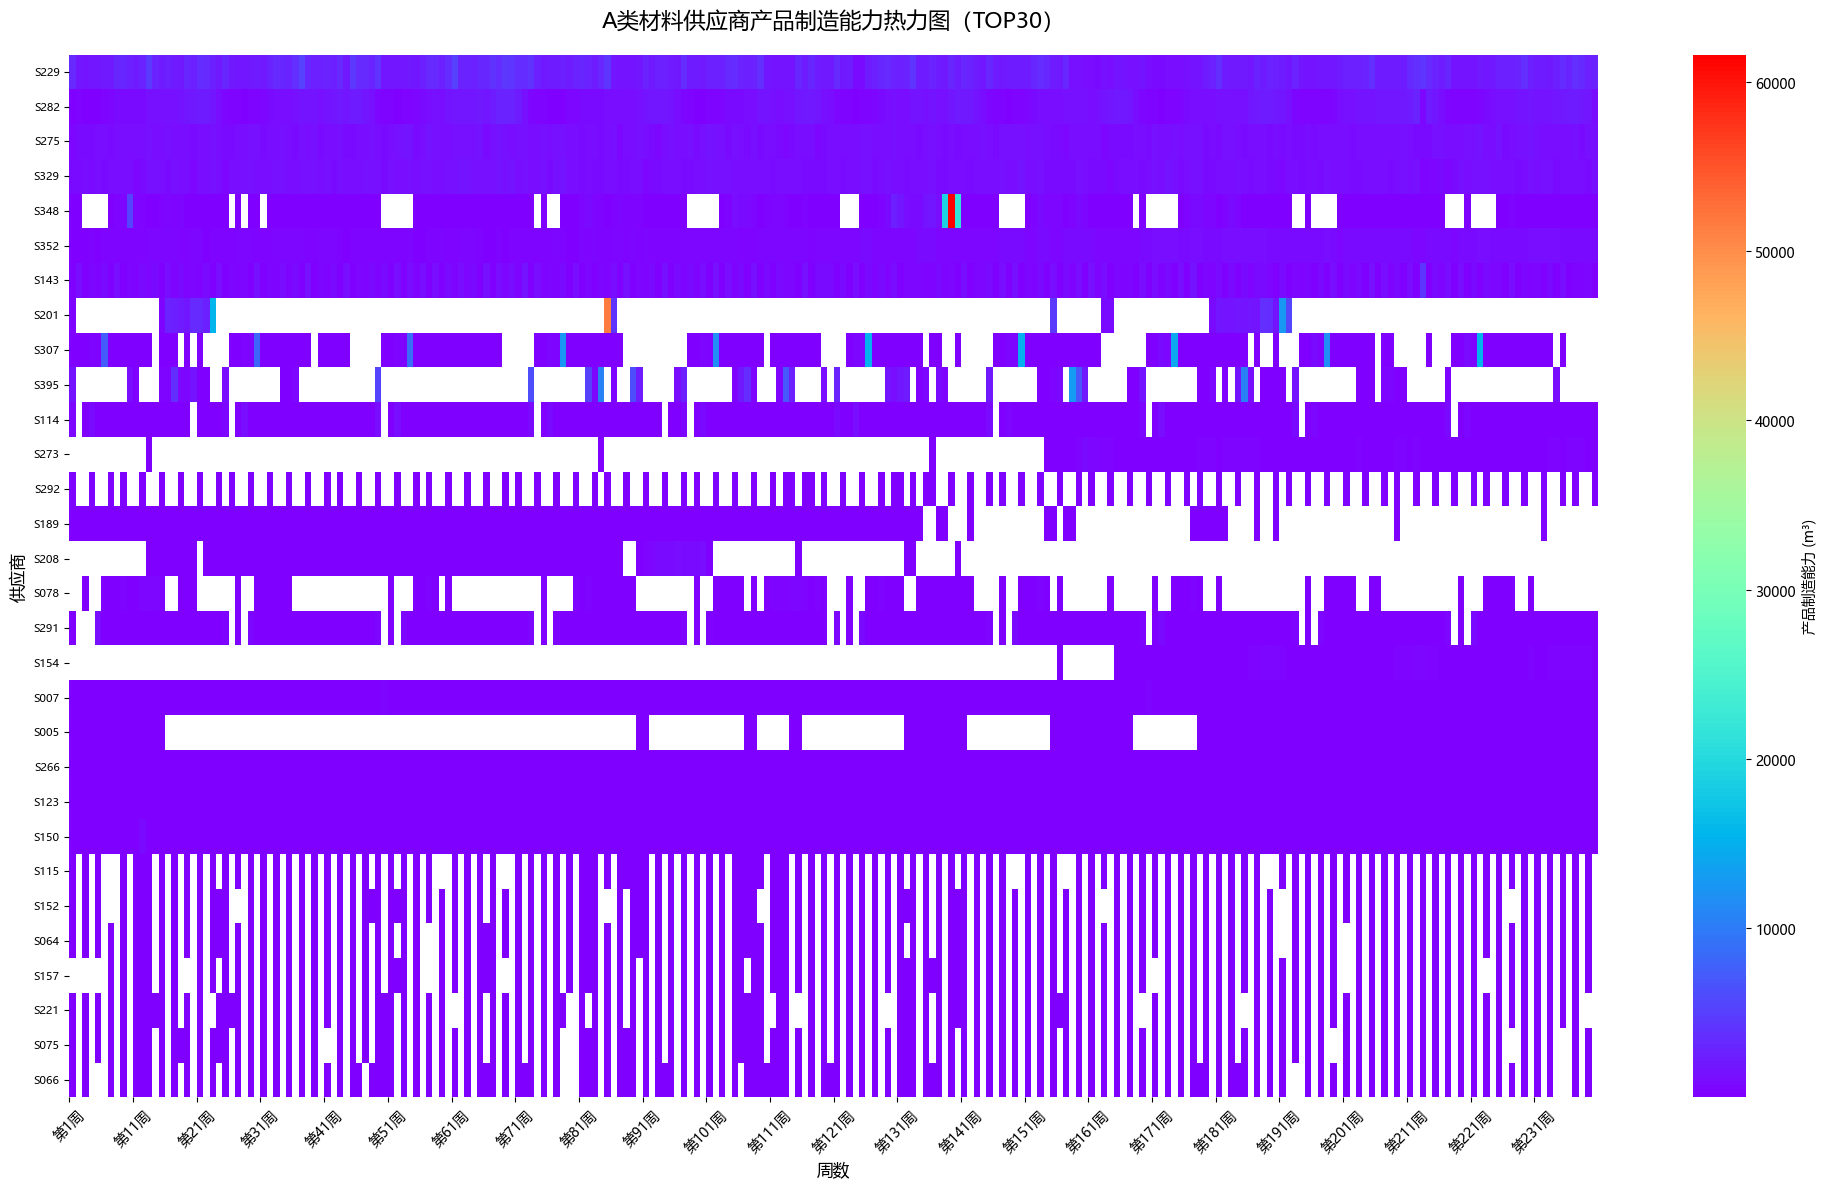


正在绘制B类材料产品制造能力热力图...
  ✓ 已保存: Pictures/production_scale_heatmap_B.svg
  ✓ 已保存: Pictures/production_scale_heatmap_B.svg


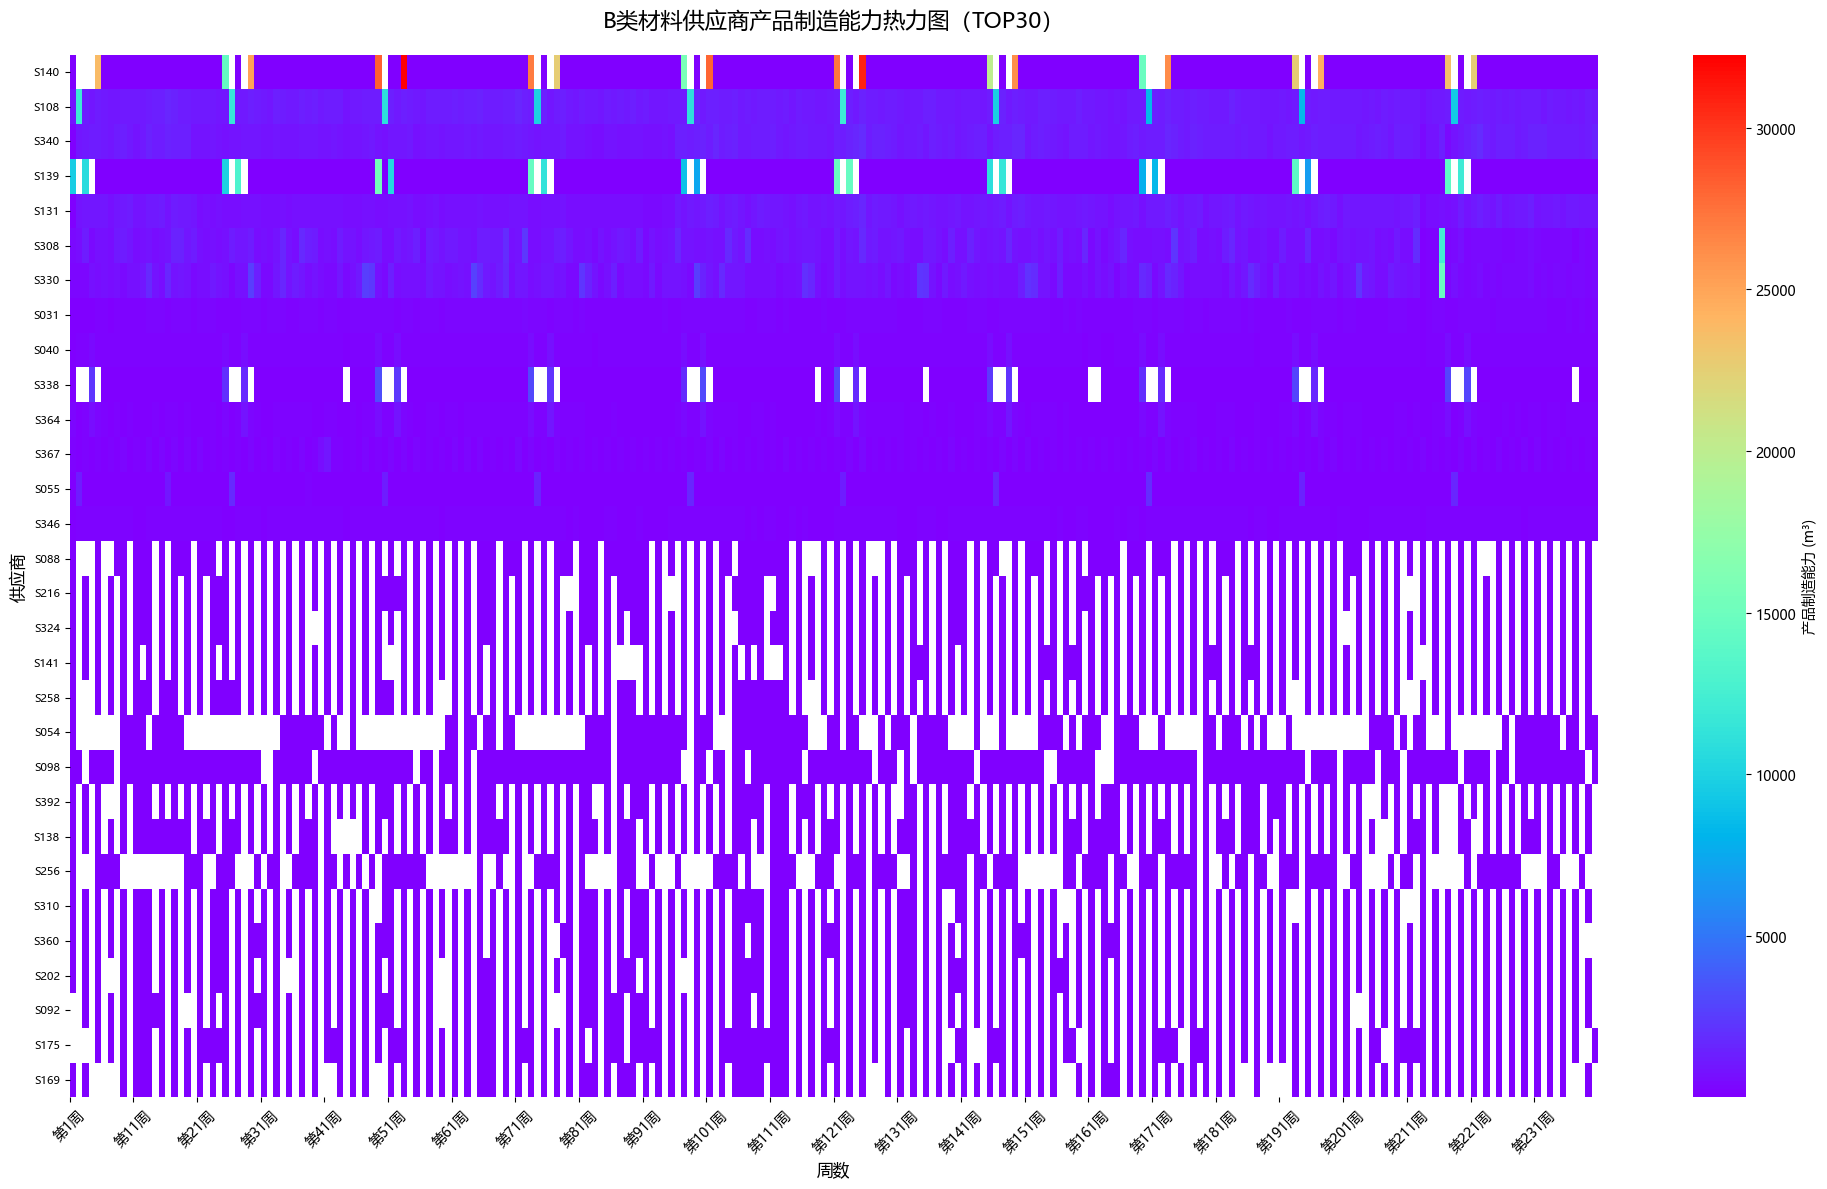


正在绘制C类材料产品制造能力热力图...
  ✓ 已保存: Pictures/production_scale_heatmap_C.svg
  ✓ 已保存: Pictures/production_scale_heatmap_C.svg


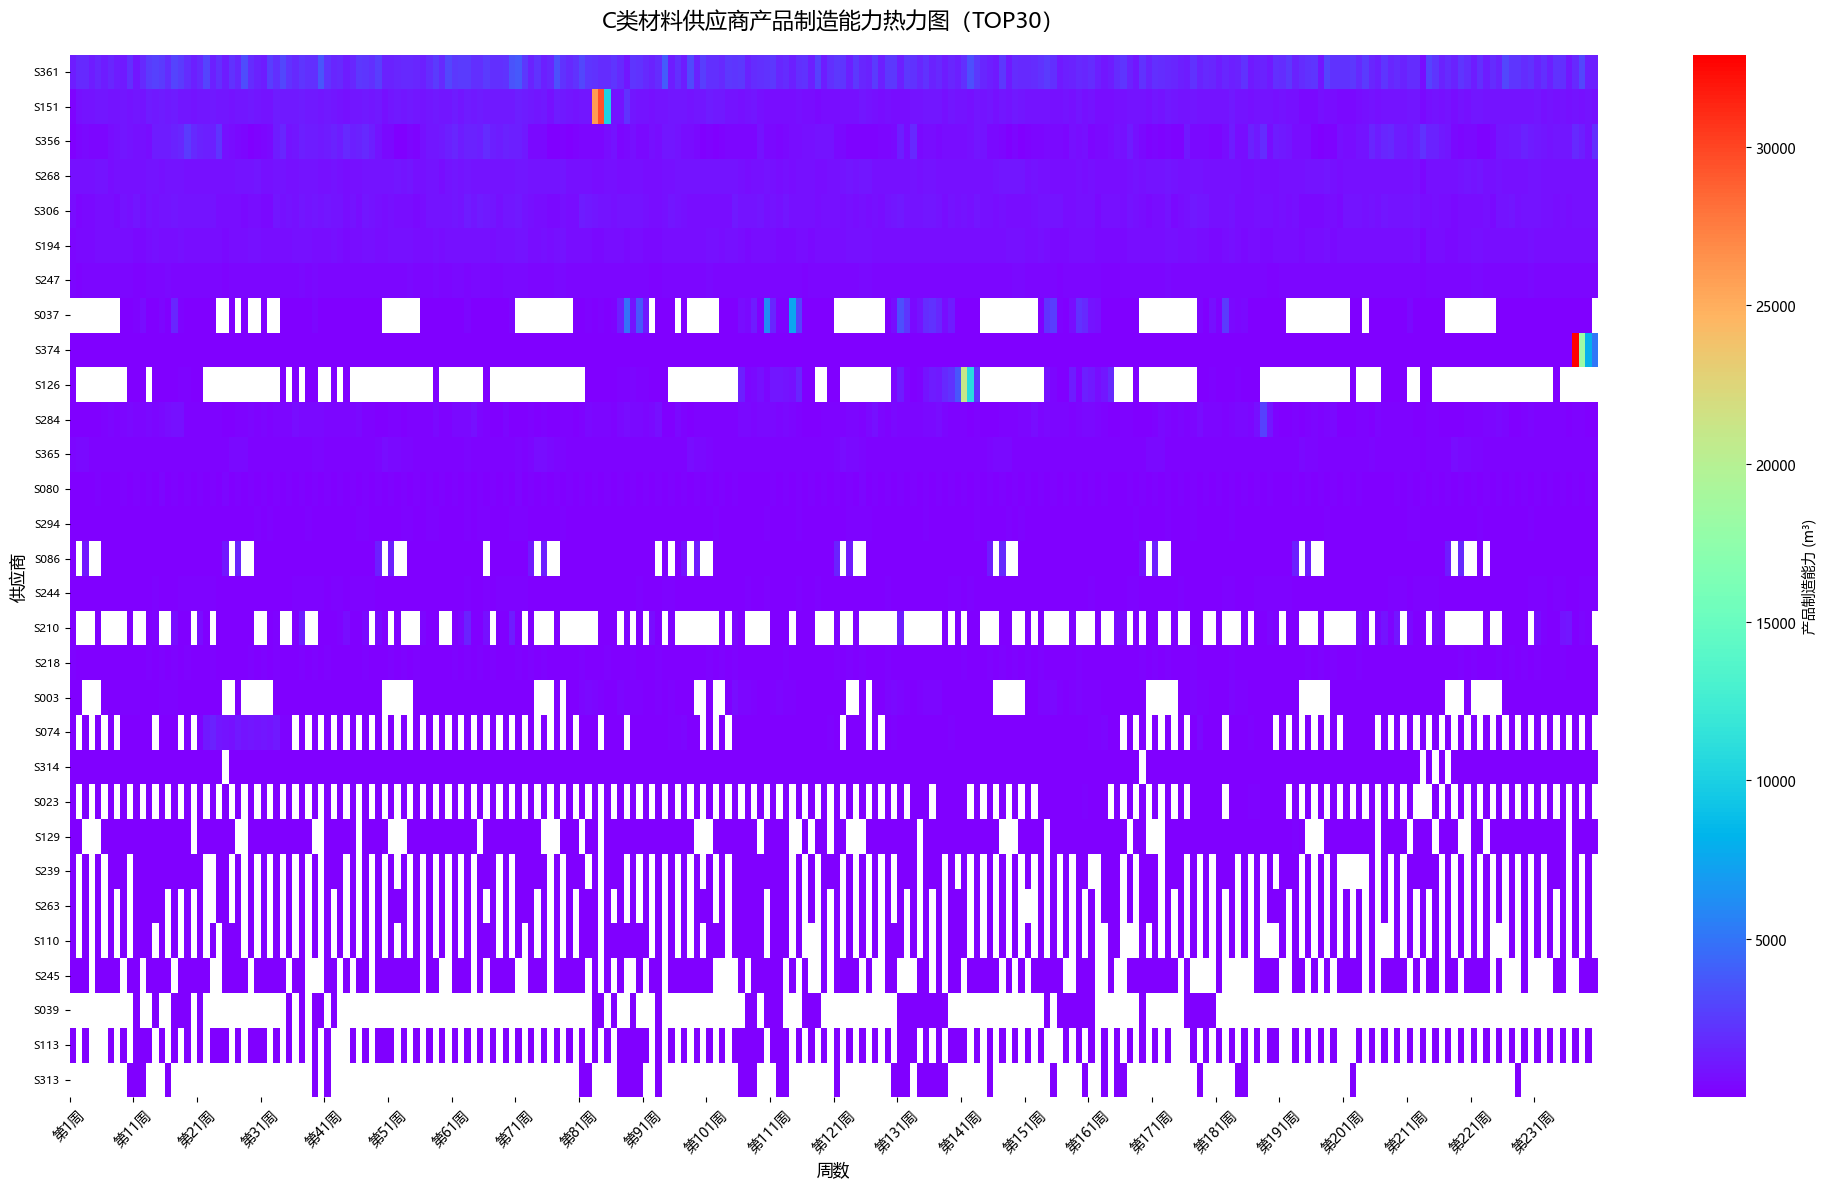


正在绘制材料类型产品制造能力对比热力图...
  ✓ 已保存: Pictures/production_scale_comparison_heatmap.svg
  ✓ 已保存: Pictures/production_scale_comparison_heatmap.svg


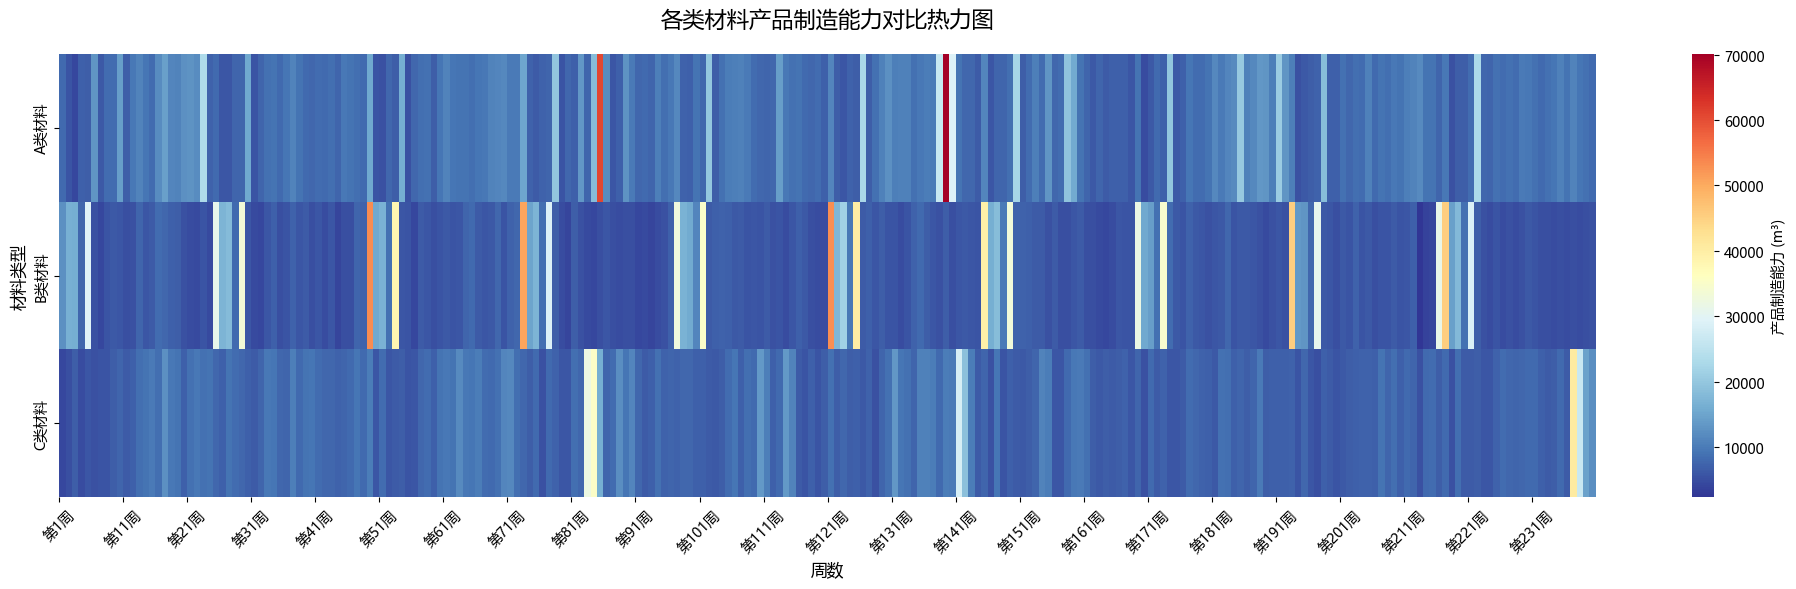


正在保存订货规模分析结果到Excel...
  ✓ 已保存到: DataFrames/订货规模产品制造能力分析_20250802_125438.xlsx

各材料类型产品制造能力TOP10排行榜:

A类材料产品制造能力TOP10:
排名   供应商名称        总制造能力(m³)       平均周制造能力(m³)        有效周数    
----------------------------------------------------------------------
1    S229         591478.3        2464.5             240     
2    S282         282233.3        1176.0             240     
3    S275         264255.0        1101.1             240     
4    S329         260863.3        1086.9             240     
5    S348         154035.0        794.0              194     
6    S352         148385.0        618.3              240     
7    S143         137978.3        574.9              240     
8    S201         136648.3        4880.3             28      
9    S307         130326.7        762.1              171     
10   S395         126405.0        1708.2             74      

B类材料产品制造能力TOP10:
排名   供应商名称        总制造能力(m³)       平均周制造能力(m³)        有效周数    
-------------------------------------------------

In [12]:
# ==================== 订货规模（原材料制造出的产品总量）分析 ====================
print("\n" + "="*60)
print("订货规模（原材料制造出的产品总量）热力图分析")
print("="*60)

def calculate_production_scale():
    """
    计算订货规模（原材料制造出的产品总量）
    
    根据题目信息：
    - A类原材料消耗量：0.6 m³/m³ (每生产1m³产品需要0.6m³A类原材料)
    - B类原材料消耗量：0.66 m³/m³ (每生产1m³产品需要0.66m³B类原材料)  
    - C类原材料消耗量：0.72 m³/m³ (每生产1m³产品需要0.72m³C类原材料)
    
    因此，原材料能制造的产品总量 = 原材料量 / 消耗量比例
    """
    # 定义原材料消耗量比例
    material_consumption = {
        'A': 0.6,   # A类原材料消耗量 m³/m³
        'B': 0.66,  # B类原材料消耗量 m³/m³
        'C': 0.72   # C类原材料消耗量 m³/m³
    }
    
    # 初始化结果数据结构
    production_data = []
    production_matrix = {}
    
    # 计算每个供应商每周的产品制造能力
    for i in range(len(supplier_names)):
        supplier_name = supplier_names[i]
        material_type = material_types[i]
        
        # 获取该供应商的供货量数据（实际获得的原材料）
        supplier_supplies = supply_data[i]  # 每周供货量数组
        
        # 计算该供应商的原材料能制造的产品总量
        # 公式：产品量 = 原材料供货量 / 消耗量比例
        weekly_production = supplier_supplies / material_consumption[material_type]
        
        # 存储该供应商的数据
        supplier_production_data = {
            'supplier_name': supplier_name,
            'material_type': material_type,
            'weekly_production': weekly_production,
            'total_production': np.sum(weekly_production),
            'avg_weekly_production': np.mean(weekly_production[weekly_production > 0]) if np.any(weekly_production > 0) else 0,
            'max_weekly_production': np.max(weekly_production),
            'active_weeks': np.sum(weekly_production > 0)
        }
        
        production_data.append(supplier_production_data)
        
        # 为热力图准备矩阵数据
        if material_type not in production_matrix:
            production_matrix[material_type] = {}
        production_matrix[material_type][supplier_name] = weekly_production
    
    return production_data, production_matrix

# 执行计算
production_data, production_matrix = calculate_production_scale()

print("订货规模计算完成！")
print(f"分析了{len(production_data)}家供应商的产品制造能力")

# 显示各材料类型的产品制造能力统计
print("\n各材料类型产品制造能力统计:")
for material in ['A', 'B', 'C']:
    material_production = [data for data in production_data if data['material_type'] == material]
    
    if material_production:
        total_production = sum([data['total_production'] for data in material_production])
        avg_production = np.mean([data['avg_weekly_production'] for data in material_production if data['avg_weekly_production'] > 0])
        max_production = max([data['max_weekly_production'] for data in material_production])
        supplier_count = len(material_production)
        
        print(f"  {material}类材料 ({supplier_count}家供应商):")
        print(f"    - 总产品制造能力: {total_production:,.0f} m³")
        print(f"    - 平均周产品制造能力: {avg_production:,.1f} m³")
        print(f"    - 最大周产品制造能力: {max_production:,.0f} m³")

def create_production_heatmap():
    """
    绘制订货规模热力图
    """
    # 为每种材料类型绘制热力图
    for material in ['A', 'B', 'C']:
        print(f"\n正在绘制{material}类材料产品制造能力热力图...")
        
        # 筛选该材料类型的供应商
        material_suppliers = [data for data in production_data if data['material_type'] == material]
        
        if not material_suppliers:
            print(f"  警告：{material}类材料没有供应商数据")
            continue
        
        # 按总产品制造能力排序，选择前30名绘制热力图
        material_suppliers.sort(key=lambda x: x['total_production'], reverse=True)
        top_suppliers = material_suppliers[:30]
        
        # 将0值设置为np.nan，这样在热力图中会显示为白色
        for supplier in top_suppliers:
            supplier['weekly_production'] = np.where(supplier['weekly_production'] == 0, np.nan, supplier['weekly_production'])
        
        cmap = plt.get_cmap('rainbow').copy()
        cmap.set_bad(color='white')  # 将0值显示为白色
       
        # 准备热力图数据
        heatmap_data = []
        supplier_labels = []
        
        for supplier_data in top_suppliers:
            heatmap_data.append(supplier_data['weekly_production'])
            supplier_labels.append(supplier_data['supplier_name'])
        
        # 转换为numpy数组
        heatmap_matrix = np.array(heatmap_data)
        
        # 创建热力图
        plt.figure(figsize=(20, 12))
        
        
        # 使用seaborn绘制热力图
        ax = sns.heatmap(heatmap_matrix, 
                        yticklabels=supplier_labels,
                        xticklabels=[f'第{i+1}周' for i in range(heatmap_matrix.shape[1])],
                        cmap='rainbow',
                        annot=False,  # 不显示数值标注（数据太多会很杂乱）
                        fmt='.1f',
                        cbar_kws={'label': '产品制造能力 (m³)'})
        
        plt.title(f'{material}类材料供应商产品制造能力热力图（TOP30）', fontsize=16, pad=20)
        plt.xlabel('周数', fontsize=12)
        plt.ylabel('供应商', fontsize=12)
        
        # 调整x轴标签显示（每10周显示一个标签）
        x_ticks = list(range(0, heatmap_matrix.shape[1], 10))
        x_labels = [f'第{i+1}周' for i in x_ticks]
        plt.xticks(x_ticks, x_labels, rotation=45)
        
        # 调整y轴标签
        plt.yticks(rotation=0, fontsize=8)
        
        plt.tight_layout()
        
        # 保存图片
        filename = f'Pictures/production_scale_heatmap_{material}.svg'
        plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
        print(f"  ✓ 已保存: {filename}")
        plt.show()

# 绘制热力图
create_production_heatmap()

def create_production_comparison_heatmap():
    """
    绘制不同材料类型产品制造能力对比热力图
    """
    print(f"\n正在绘制材料类型产品制造能力对比热力图...")
    
    # 计算每种材料每周的总产品制造能力
    weekly_production_by_material = {}
    weeks_count = len(production_data[0]['weekly_production'])
    
    for material in ['A', 'B', 'C']:
        weekly_total = np.zeros(weeks_count)
        
        for data in production_data:
            if data['material_type'] == material:
                # 确保weekly_production是数组且处理NaN值
                weekly_production = data['weekly_production']
                if isinstance(weekly_production, np.ndarray):
                    # 将NaN值替换为0进行求和
                    weekly_production_clean = np.nan_to_num(weekly_production, nan=0.0)
                    weekly_total += weekly_production_clean
                else:
                    weekly_total += weekly_production
        
        weekly_production_by_material[material] = weekly_total
    
    # 准备热力图数据
    heatmap_data = []
    material_labels = []
    
    for material in ['A', 'B', 'C']:
        material_weekly = weekly_production_by_material[material]
        # 将0值设置为np.nan，这样在热力图中会显示为白色
        material_weekly_with_nan = np.where(material_weekly == 0, np.nan, material_weekly)
        heatmap_data.append(material_weekly_with_nan)
        material_labels.append(f'{material}类材料')
    
    heatmap_matrix = np.array(heatmap_data)
    
    # 创建自定义色彩映射，将NaN值（0值）显示为白色
    cmap = plt.get_cmap('RdYlBu_r').copy()
    cmap.set_bad(color='white')  # 将NaN值（原0值）显示为白色
    
    # 创建热力图
    plt.figure(figsize=(20, 6))
    
    ax = sns.heatmap(heatmap_matrix,
                    yticklabels=material_labels,
                    xticklabels=[f'第{i+1}周' for i in range(heatmap_matrix.shape[1])],
                    cmap=cmap,
                    annot=False,
                    fmt='.0f',
                    cbar_kws={'label': '产品制造能力 (m³)'})
    
    plt.title('各类材料产品制造能力对比热力图', fontsize=16, pad=20)
    plt.xlabel('周数', fontsize=12)
    plt.ylabel('材料类型', fontsize=12)
    
    # 调整x轴标签显示
    x_ticks = list(range(0, heatmap_matrix.shape[1], 10))
    x_labels = [f'第{i+1}周' for i in x_ticks]
    plt.xticks(x_ticks, x_labels, rotation=45)
    
    plt.tight_layout()
    
    # 保存图片
    filename = 'Pictures/production_scale_comparison_heatmap.svg'
    plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
    print(f"  ✓ 已保存: {filename}")
    plt.show()

# 绘制对比热力图
create_production_comparison_heatmap()

def save_production_scale_to_excel():
    """
    将订货规模分析结果保存到Excel表格
    """
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print(f"\n正在保存订货规模分析结果到Excel...")
    
    # 1. 准备供应商产品制造能力汇总表
    production_summary = []
    
    for data in production_data:
        production_summary.append({
            '供应商名称': data['supplier_name'],
            '材料类型': data['material_type'],
            '总产品制造能力_m3': round(data['total_production'], 2),
            '平均周产品制造能力_m3': round(data['avg_weekly_production'], 2),
            '最大周产品制造能力_m3': round(data['max_weekly_production'], 2),
            '有效供货周数': data['active_weeks']
        })
    
    production_summary_df = pd.DataFrame(production_summary)
    
    # 2. 准备详细的周数据表（和原表相同布局：供应商为行，周数为列）
    weeks_count = len(production_data[0]['weekly_production'])
    
    # 创建和原表相同格式的周数据表
    weekly_data_rows = []
    
    for data in production_data:
        # 构建每行数据：供应商名称 + 材料类型 + 各周产品制造能力
        row = {
            '供应商名称': data['supplier_name'],
            '材料类型': data['material_type']
        }
        
        # 添加各周数据列
        for week in range(weeks_count):
            week_column = f'第{week + 1}周'
            # 处理可能的NaN值，将其转换为0
            weekly_value = data['weekly_production'][week]
            if np.isnan(weekly_value):
                weekly_value = 0.0
            row[week_column] = round(weekly_value, 2)
        
        weekly_data_rows.append(row)
    
    production_weekly_df = pd.DataFrame(weekly_data_rows)
    
    # 3. 准备各材料类型统计表
    material_stats = []
    
    for material in ['A', 'B', 'C']:
        material_production = [data for data in production_data if data['material_type'] == material]
        
        if material_production:
            total_production = sum([data['total_production'] for data in material_production])
            avg_production = np.mean([data['avg_weekly_production'] for data in material_production if data['avg_weekly_production'] > 0])
            max_production = max([data['max_weekly_production'] for data in material_production])
            supplier_count = len(material_production)
            
            material_stats.append({
                '材料类型': f'{material}类',
                '供应商数量': supplier_count,
                '总产品制造能力_m3': round(total_production, 2),
                '平均周产品制造能力_m3': round(avg_production, 2),
                '最大周产品制造能力_m3': round(max_production, 2)
            })
    
    material_stats_df = pd.DataFrame(material_stats)
    
    # 4. 保存到Excel文件
    filename = f"DataFrames/订货规模产品制造能力分析_{timestamp}.xlsx"
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # 汇总表
        production_summary_df.to_excel(writer, sheet_name='产品制造能力汇总', index=False)
        
        # 周数据表（原表布局格式）
        production_weekly_df.to_excel(writer, sheet_name='周产品制造能力数据_原表布局', index=False)
        
        # 材料类型统计表
        material_stats_df.to_excel(writer, sheet_name='材料类型统计', index=False)
        
        # 按材料类型分组的排行榜
        for material in ['A', 'B', 'C']:
            material_data = production_summary_df[production_summary_df['材料类型'] == material].copy()
            if not material_data.empty:
                material_data = material_data.sort_values('总产品制造能力_m3', ascending=False)
                material_data.reset_index(drop=True, inplace=True)
                material_data.index = range(1, len(material_data) + 1)
                material_data.index.name = '排名'
                
                sheet_name = f'{material}类材料排行榜'
                material_data.to_excel(writer, sheet_name=sheet_name)
    
    print(f"  ✓ 已保存到: {filename}")
    
    # 5. 显示排行榜信息
    print(f"\n各材料类型产品制造能力TOP10排行榜:")
    for material in ['A', 'B', 'C']:
        print(f"\n{material}类材料产品制造能力TOP10:")
        material_data = production_summary_df[production_summary_df['材料类型'] == material]
        top10 = material_data.nlargest(10, '总产品制造能力_m3')
        
        print(f"{'排名':<4} {'供应商名称':<12} {'总制造能力(m³)':<15} {'平均周制造能力(m³)':<18} {'有效周数':<8}")
        print("-" * 70)
        
        for idx, (_, row) in enumerate(top10.iterrows(), 1):
            print(f"{idx:<4} {row['供应商名称']:<12} {row['总产品制造能力_m3']:<15.1f} "
                  f"{row['平均周产品制造能力_m3']:<18.1f} {row['有效供货周数']:<8}")
    
    return filename

# 保存数据到Excel
excel_file = save_production_scale_to_excel()

print(f"\n" + "="*60)
print("订货规模（原材料制造出的产品总量）分析完成！")
print("="*60)
print(f"✓ 已生成热力图:")
print(f"  - A类材料产品制造能力热力图")
print(f"  - B类材料产品制造能力热力图") 
print(f"  - C类材料产品制造能力热力图")
print(f"  - 材料类型对比热力图")
print(f"✓ 已保存Excel表格: {excel_file}")
print(f"✓ 图片文件保存在Pictures文件夹")
print(f"✓ 数据文件保存在DataFrames文件夹")


检查对比热力图数据分布:
A类材料:
  - 0值周数: 0/240
  - 最小值: 4428.33
  - 最大值: 70125.00
  - 小于1000的周数: 0
B类材料:
  - 0值周数: 0/240
  - 最小值: 2343.94
  - 最大值: 53419.70
  - 小于1000的周数: 0
C类材料:
  - 0值周数: 0/240
  - 最小值: 4290.28
  - 最大值: 40530.56
  - 小于1000的周数: 0

正在绘制材料类型产品制造能力对比热力图（优化版）...
  ✓ 已保存: Pictures/production_scale_comparison_heatmap_optimized.svg
  ✓ 已保存: Pictures/production_scale_comparison_heatmap_optimized.svg


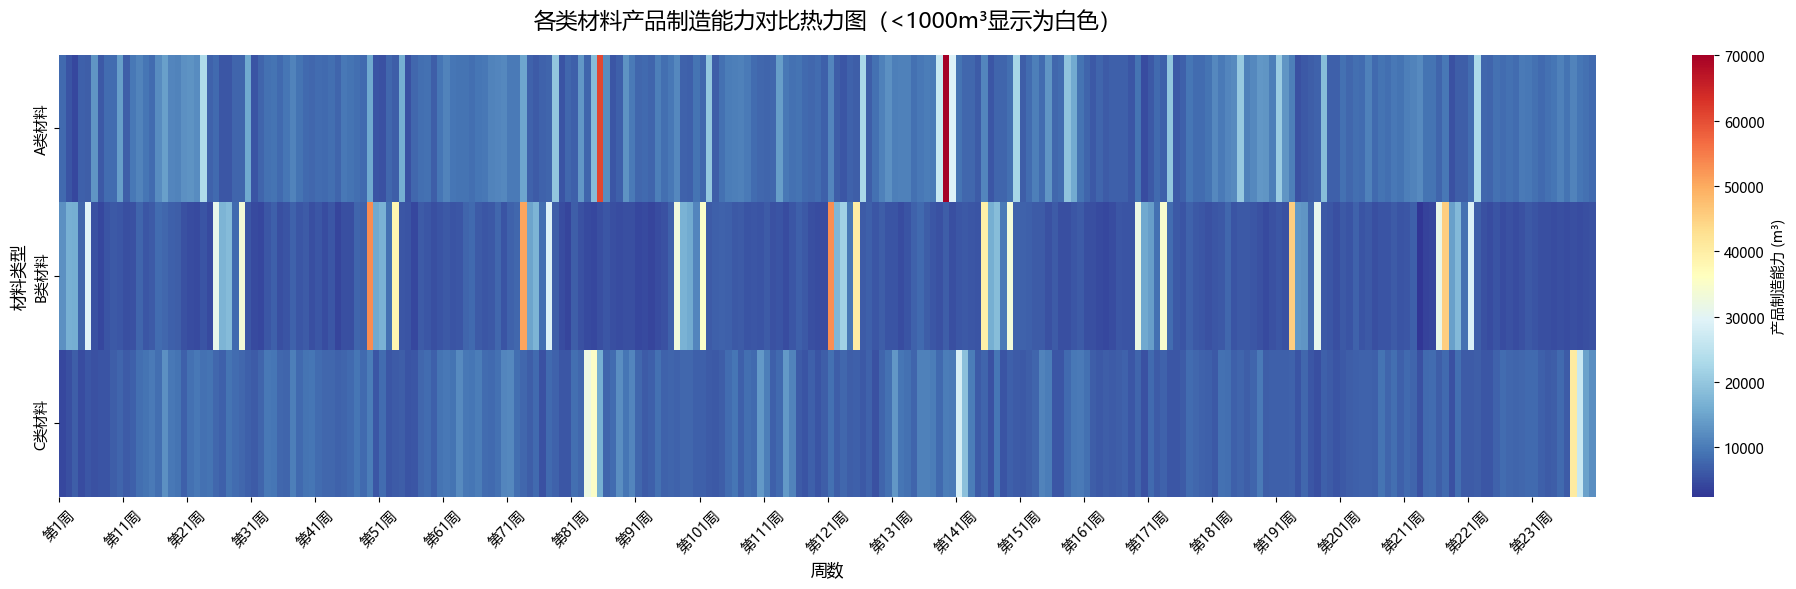

In [13]:
# 检查对比热力图中的数据分布
print("\n检查对比热力图数据分布:")
print("="*50)

weeks_count = len(production_data[0]['weekly_production'])

for material in ['A', 'B', 'C']:
    weekly_total = np.zeros(weeks_count)
    
    for data in production_data:
        if data['material_type'] == material:
            # 确保weekly_production是数组且处理NaN值
            weekly_production = data['weekly_production']
            if isinstance(weekly_production, np.ndarray):
                # 将NaN值替换为0进行求和
                weekly_production_clean = np.nan_to_num(weekly_production, nan=0.0)
                weekly_total += weekly_production_clean
            else:
                weekly_total += weekly_production
    
    zero_count = np.sum(weekly_total == 0)
    min_value = np.min(weekly_total)
    max_value = np.max(weekly_total)
    
    print(f"{material}类材料:")
    print(f"  - 0值周数: {zero_count}/{weeks_count}")
    print(f"  - 最小值: {min_value:.2f}")
    print(f"  - 最大值: {max_value:.2f}")
    print(f"  - 小于1000的周数: {np.sum(weekly_total < 1000)}")

# 修改对比热力图函数，使用更合适的阈值
def create_production_comparison_heatmap_with_threshold():
    """
    绘制不同材料类型产品制造能力对比热力图（使用阈值设置白色）
    """
    print(f"\n正在绘制材料类型产品制造能力对比热力图（优化版）...")
    
    # 计算每种材料每周的总产品制造能力
    weekly_production_by_material = {}
    weeks_count = len(production_data[0]['weekly_production'])
    
    for material in ['A', 'B', 'C']:
        weekly_total = np.zeros(weeks_count)
        
        for data in production_data:
            if data['material_type'] == material:
                # 确保weekly_production是数组且处理NaN值
                weekly_production = data['weekly_production']
                if isinstance(weekly_production, np.ndarray):
                    # 将NaN值替换为0进行求和
                    weekly_production_clean = np.nan_to_num(weekly_production, nan=0.0)
                    weekly_total += weekly_production_clean
                else:
                    weekly_total += weekly_production
        
        weekly_production_by_material[material] = weekly_total
    
    # 准备热力图数据
    heatmap_data = []
    material_labels = []
    
    # 设置一个较低的阈值，小于此值的将显示为白色
    threshold = 1000  # 产品制造能力小于1000m³的显示为白色
    
    for material in ['A', 'B', 'C']:
        material_weekly = weekly_production_by_material[material]
        # 将小于阈值的值设置为np.nan，这样在热力图中会显示为白色
        material_weekly_with_nan = np.where(material_weekly < threshold, np.nan, material_weekly)
        heatmap_data.append(material_weekly_with_nan)
        material_labels.append(f'{material}类材料')
    
    heatmap_matrix = np.array(heatmap_data)
    
    # 创建自定义色彩映射，将NaN值（低值）显示为白色
    cmap = plt.get_cmap('RdYlBu_r').copy()
    cmap.set_bad(color='white')  # 将NaN值（低值）显示为白色
    
    # 创建热力图
    plt.figure(figsize=(20, 6))
    
    ax = sns.heatmap(heatmap_matrix,
                    yticklabels=material_labels,
                    xticklabels=[f'第{i+1}周' for i in range(heatmap_matrix.shape[1])],
                    cmap=cmap,
                    annot=False,
                    fmt='.0f',
                    cbar_kws={'label': '产品制造能力 (m³)'})
    
    plt.title(f'各类材料产品制造能力对比热力图（<{threshold}m³显示为白色）', fontsize=16, pad=20)
    plt.xlabel('周数', fontsize=12)
    plt.ylabel('材料类型', fontsize=12)
    
    # 调整x轴标签显示
    x_ticks = list(range(0, heatmap_matrix.shape[1], 10))
    x_labels = [f'第{i+1}周' for i in x_ticks]
    plt.xticks(x_ticks, x_labels, rotation=45)
    
    plt.tight_layout()
    
    # 保存图片
    filename = 'Pictures/production_scale_comparison_heatmap_optimized.svg'
    plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
    print(f"  ✓ 已保存: {filename}")
    plt.show()

# 绘制优化版对比热力图
create_production_comparison_heatmap_with_threshold()


正在绘制材料类型产品制造能力对比热力图（最终版）...
使用阈值: 5609 m³（数据的15百分位数）
A类材料将有 10 周显示为白色
B类材料将有 85 周显示为白色
C类材料将有 13 周显示为白色
  ✓ 已保存: Pictures/production_scale_comparison_heatmap_final.svg
  ✓ 已保存: Pictures/production_scale_comparison_heatmap_final.svg


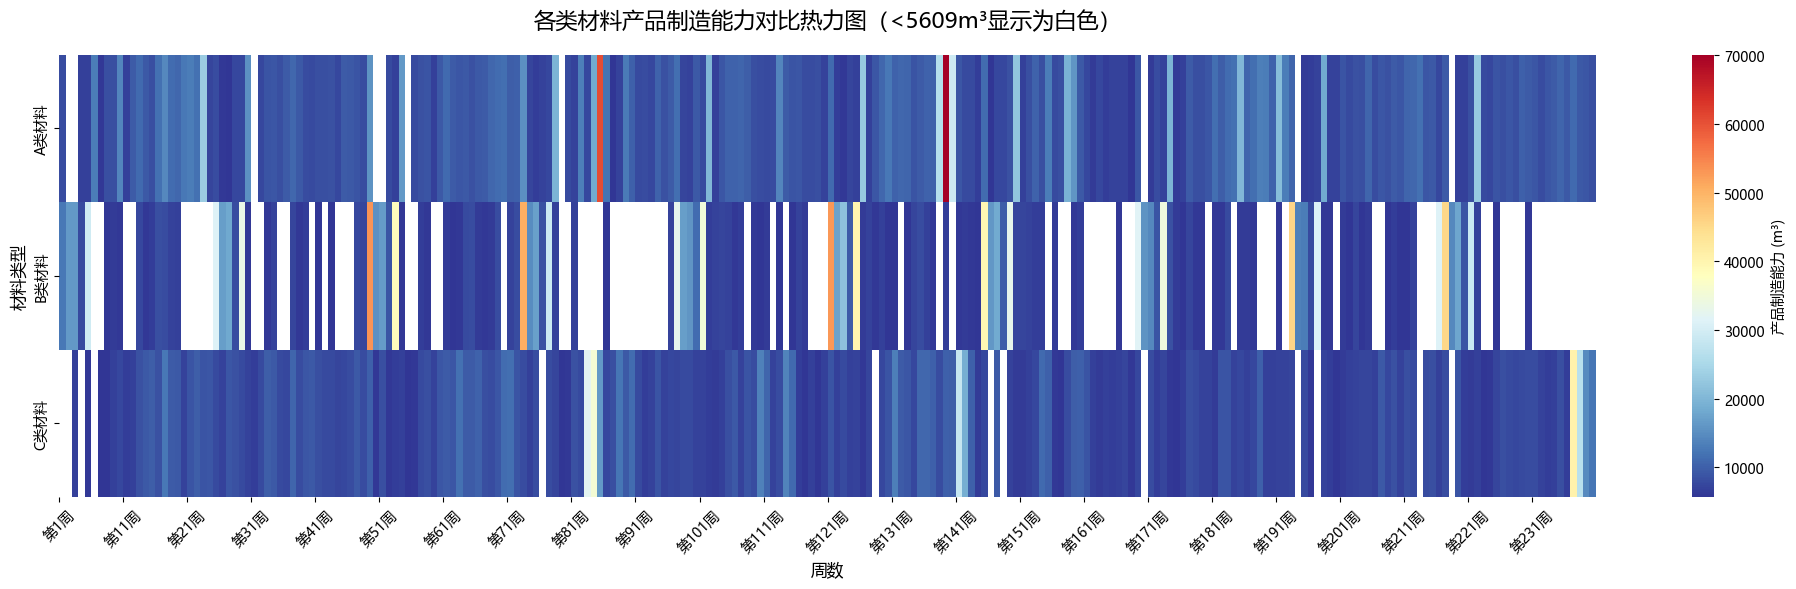

In [14]:
# 基于数据分布调整阈值的对比热力图
def create_production_comparison_heatmap_final():
    """
    绘制不同材料类型产品制造能力对比热力图（使用数据分布的低值作为白色阈值）
    """
    print(f"\n正在绘制材料类型产品制造能力对比热力图（最终版）...")
    
    # 计算每种材料每周的总产品制造能力
    weekly_production_by_material = {}
    weeks_count = len(production_data[0]['weekly_production'])
    
    for material in ['A', 'B', 'C']:
        weekly_total = np.zeros(weeks_count)
        
        for data in production_data:
            if data['material_type'] == material:
                # 确保weekly_production是数组且处理NaN值
                weekly_production = data['weekly_production']
                if isinstance(weekly_production, np.ndarray):
                    # 将NaN值替换为0进行求和
                    weekly_production_clean = np.nan_to_num(weekly_production, nan=0.0)
                    weekly_total += weekly_production_clean
                else:
                    weekly_total += weekly_production
        
        weekly_production_by_material[material] = weekly_total
    
    # 计算所有数据的25百分位数作为阈值
    all_values = []
    for material in ['A', 'B', 'C']:
        all_values.extend(weekly_production_by_material[material])
    
    threshold = np.percentile(all_values, 15)  # 使用15百分位数作为阈值
    print(f"使用阈值: {threshold:.0f} m³（数据的15百分位数）")
    
    # 准备热力图数据
    heatmap_data = []
    material_labels = []
    
    for material in ['A', 'B', 'C']:
        material_weekly = weekly_production_by_material[material]
        # 将小于阈值的值设置为np.nan，这样在热力图中会显示为白色
        material_weekly_with_nan = np.where(material_weekly < threshold, np.nan, material_weekly)
        heatmap_data.append(material_weekly_with_nan)
        material_labels.append(f'{material}类材料')
        
        # 统计设为白色的周数
        white_count = np.sum(material_weekly < threshold)
        print(f"{material}类材料将有 {white_count} 周显示为白色")
    
    heatmap_matrix = np.array(heatmap_data)
    
    # 创建自定义色彩映射，将NaN值（低值）显示为白色
    cmap = plt.get_cmap('RdYlBu_r').copy()
    cmap.set_bad(color='white')  # 将NaN值（低值）显示为白色
    
    # 创建热力图
    plt.figure(figsize=(20, 6))
    
    ax = sns.heatmap(heatmap_matrix,
                    yticklabels=material_labels,
                    xticklabels=[f'第{i+1}周' for i in range(heatmap_matrix.shape[1])],
                    cmap=cmap,
                    annot=False,
                    fmt='.0f',
                    cbar_kws={'label': '产品制造能力 (m³)'})
    
    plt.title(f'各类材料产品制造能力对比热力图（<{threshold:.0f}m³显示为白色）', fontsize=16, pad=20)
    plt.xlabel('周数', fontsize=12)
    plt.ylabel('材料类型', fontsize=12)
    
    # 调整x轴标签显示
    x_ticks = list(range(0, heatmap_matrix.shape[1], 10))
    x_labels = [f'第{i+1}周' for i in x_ticks]
    plt.xticks(x_ticks, x_labels, rotation=45)
    
    plt.tight_layout()
    
    # 保存图片
    filename = 'Pictures/production_scale_comparison_heatmap_final.svg'
    plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
    print(f"  ✓ 已保存: {filename}")
    plt.show()

# 绘制最终版对比热力图
create_production_comparison_heatmap_final()

### 绘制供货规模（原材料制造出的产品总量）热力图，并输出到表格


供货规模（原材料制造出的产品总量）热力图分析
注：供货规模基于实际供货量计算，反映供应商实际提供的原材料制造能力
供货规模计算完成！
分析了402家供应商的实际产品制造能力

各材料类型实际产品制造能力统计:
  A类材料 (146家供应商):
    - 总实际产品制造能力: 2,421,762 m³
    - 平均周实际产品制造能力: 118.3 m³
    - 最大周实际产品制造能力: 61,620 m³
  B类材料 (134家供应商):
    - 总实际产品制造能力: 2,270,700 m³
    - 平均周实际产品制造能力: 77.5 m³
    - 最大周实际产品制造能力: 32,262 m³
  C类材料 (122家供应商):
    - 总实际产品制造能力: 2,011,510 m³
    - 平均周实际产品制造能力: 78.4 m³
    - 最大周实际产品制造能力: 32,910 m³

正在绘制A类材料实际产品制造能力热力图...
  ✓ 已保存: Pictures/supply_scale_heatmap_A.svg
  ✓ 已保存: Pictures/supply_scale_heatmap_A.svg


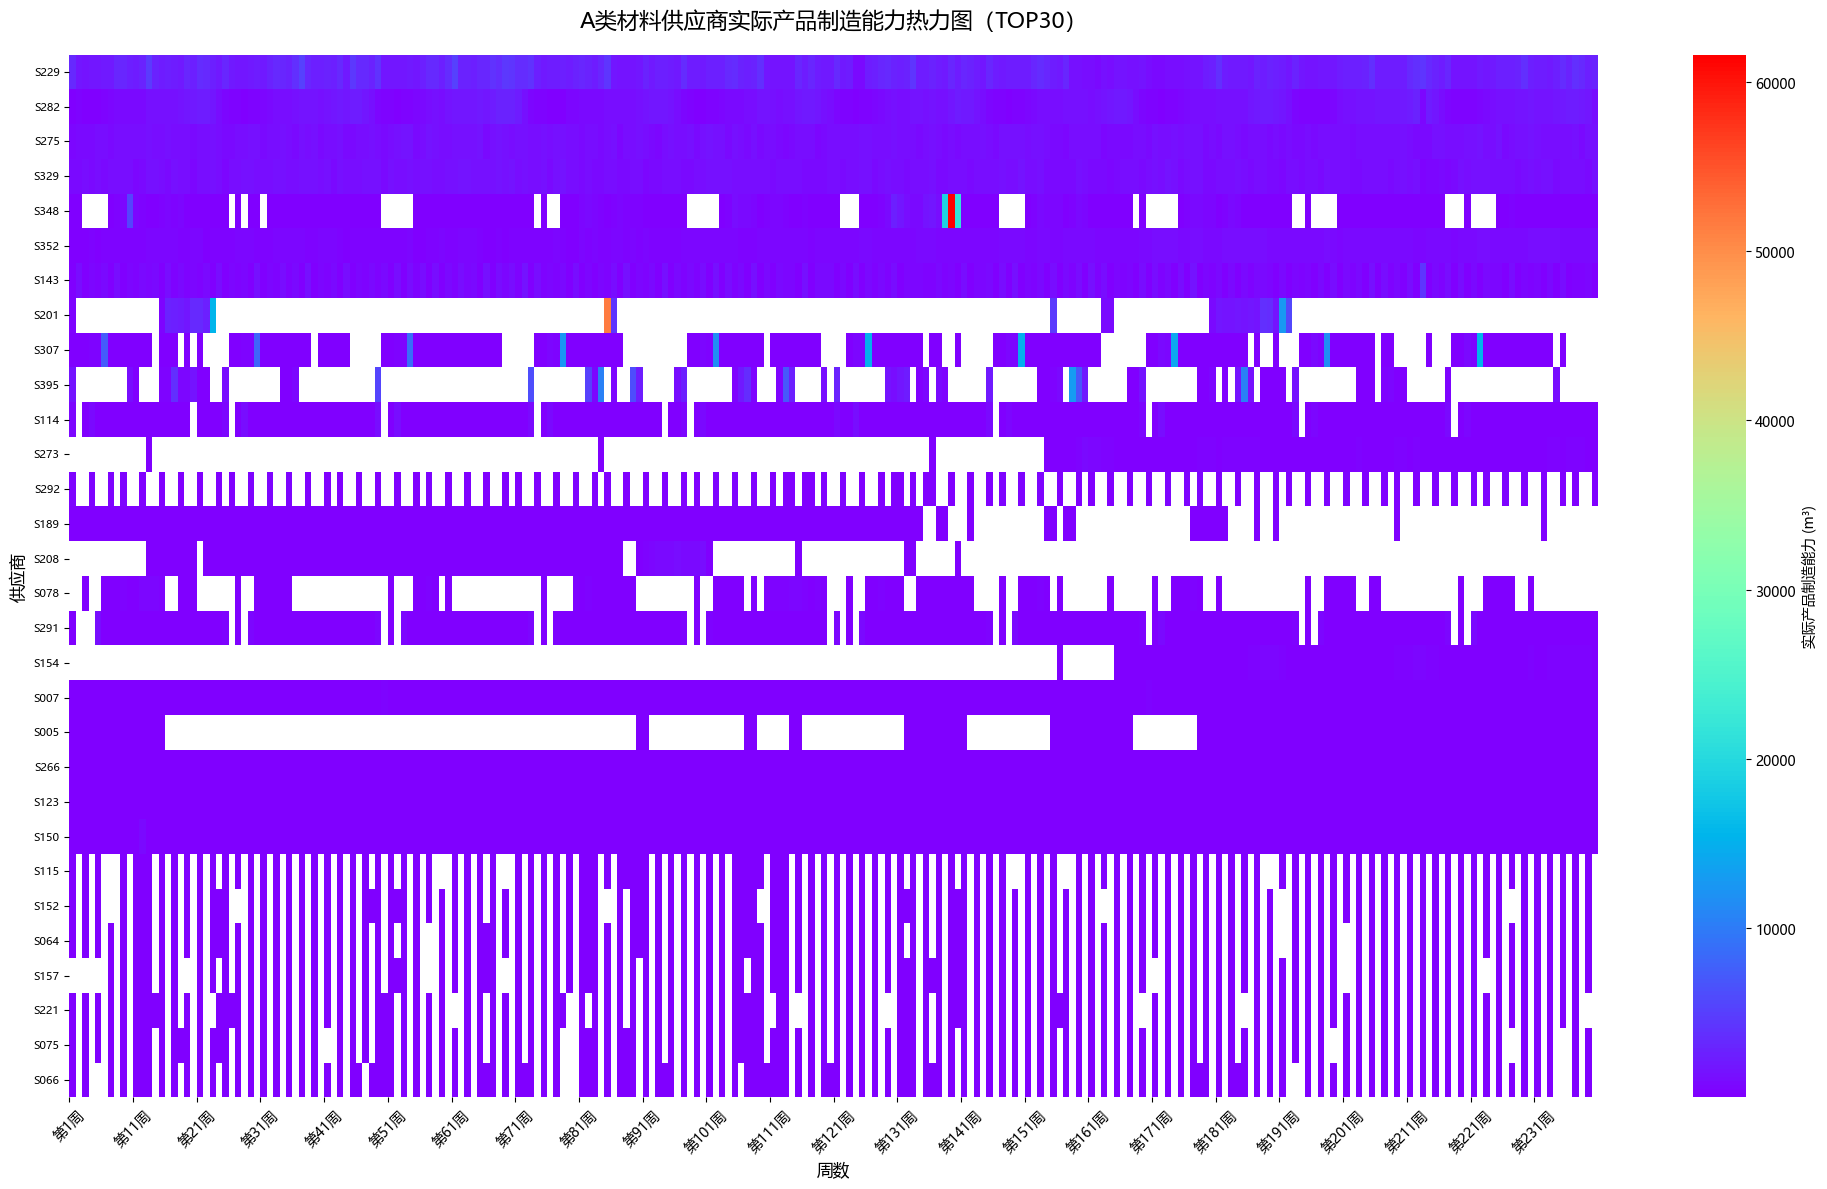


正在绘制B类材料实际产品制造能力热力图...
  ✓ 已保存: Pictures/supply_scale_heatmap_B.svg
  ✓ 已保存: Pictures/supply_scale_heatmap_B.svg


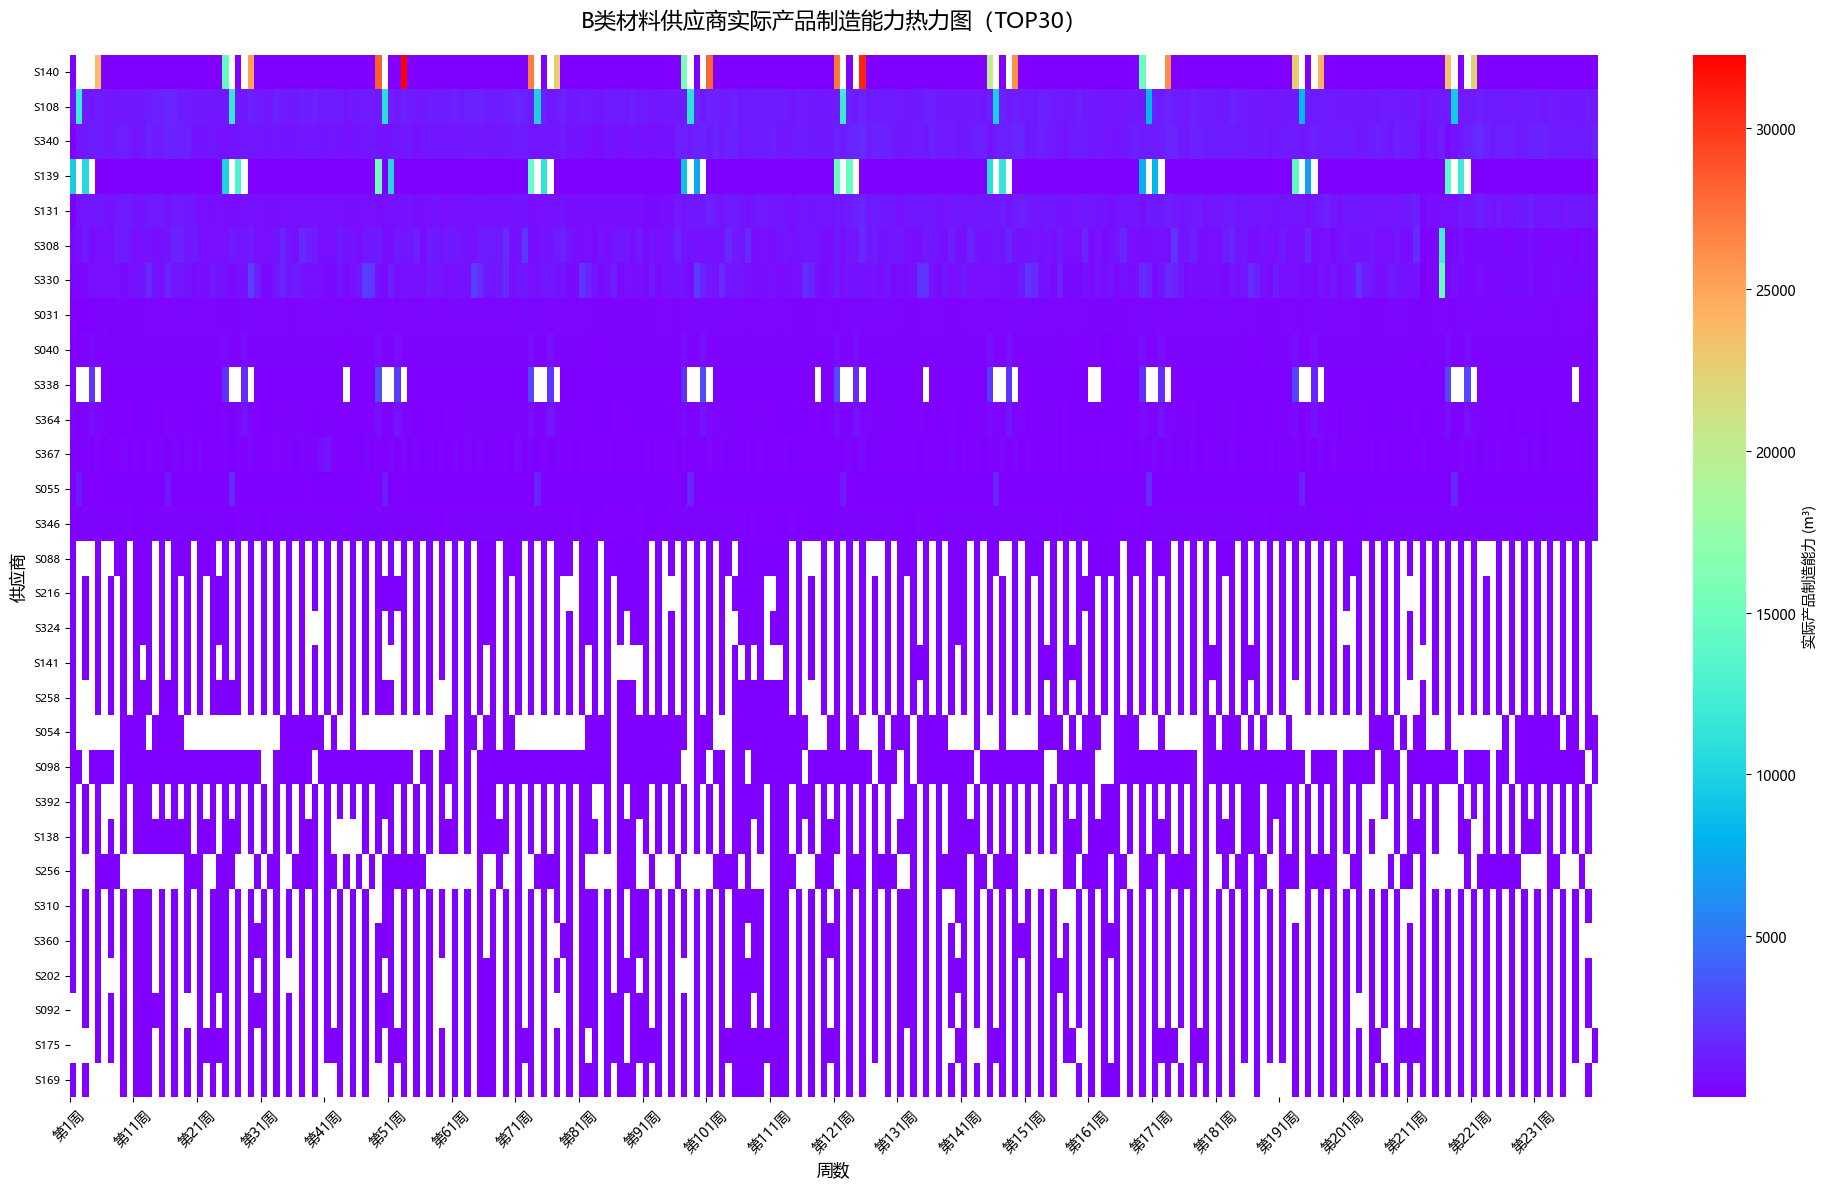


正在绘制C类材料实际产品制造能力热力图...
  ✓ 已保存: Pictures/supply_scale_heatmap_C.svg
  ✓ 已保存: Pictures/supply_scale_heatmap_C.svg


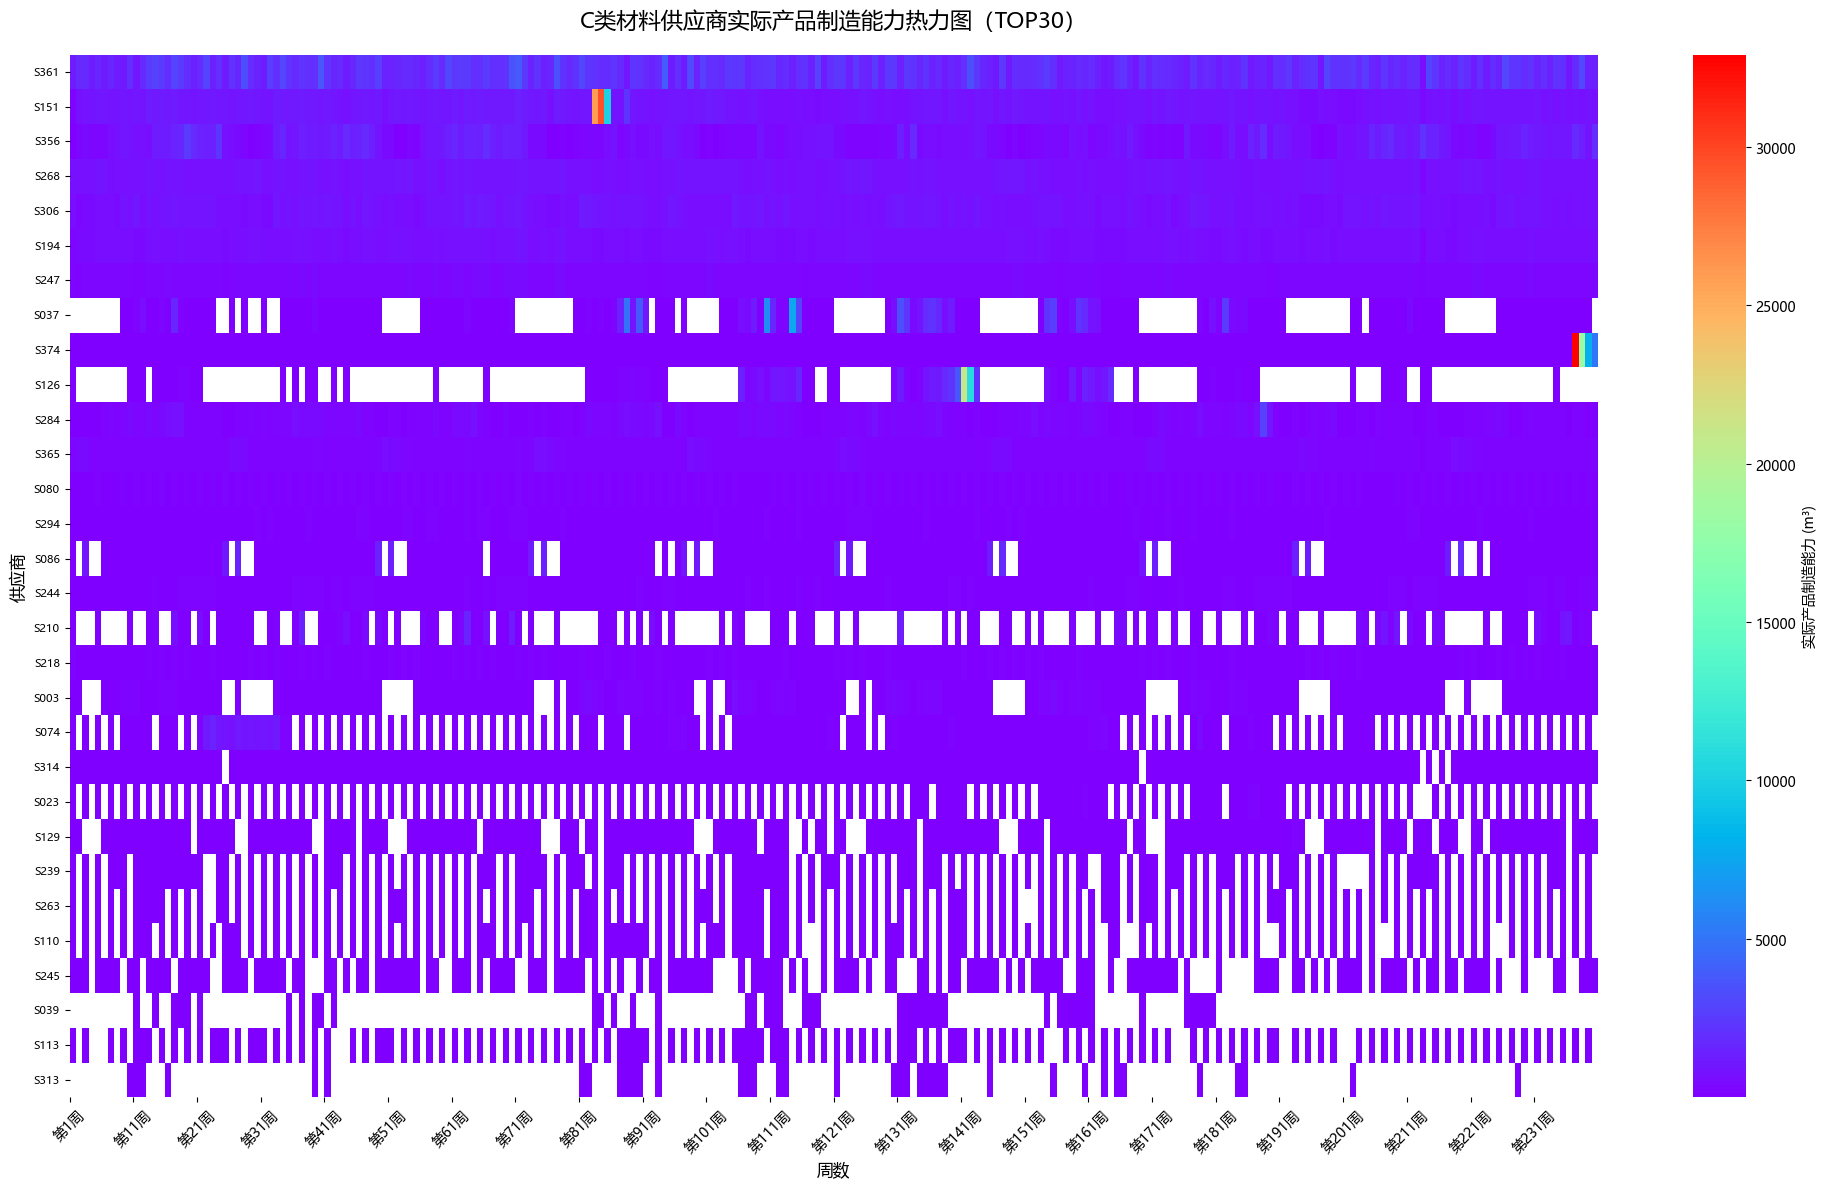


正在绘制材料类型实际产品制造能力对比热力图...
使用阈值: 5609 m³（数据的15百分位数）
A类材料将有 10 周显示为白色
B类材料将有 85 周显示为白色
C类材料将有 13 周显示为白色
  ✓ 已保存: Pictures/supply_scale_comparison_heatmap.svg
  ✓ 已保存: Pictures/supply_scale_comparison_heatmap.svg


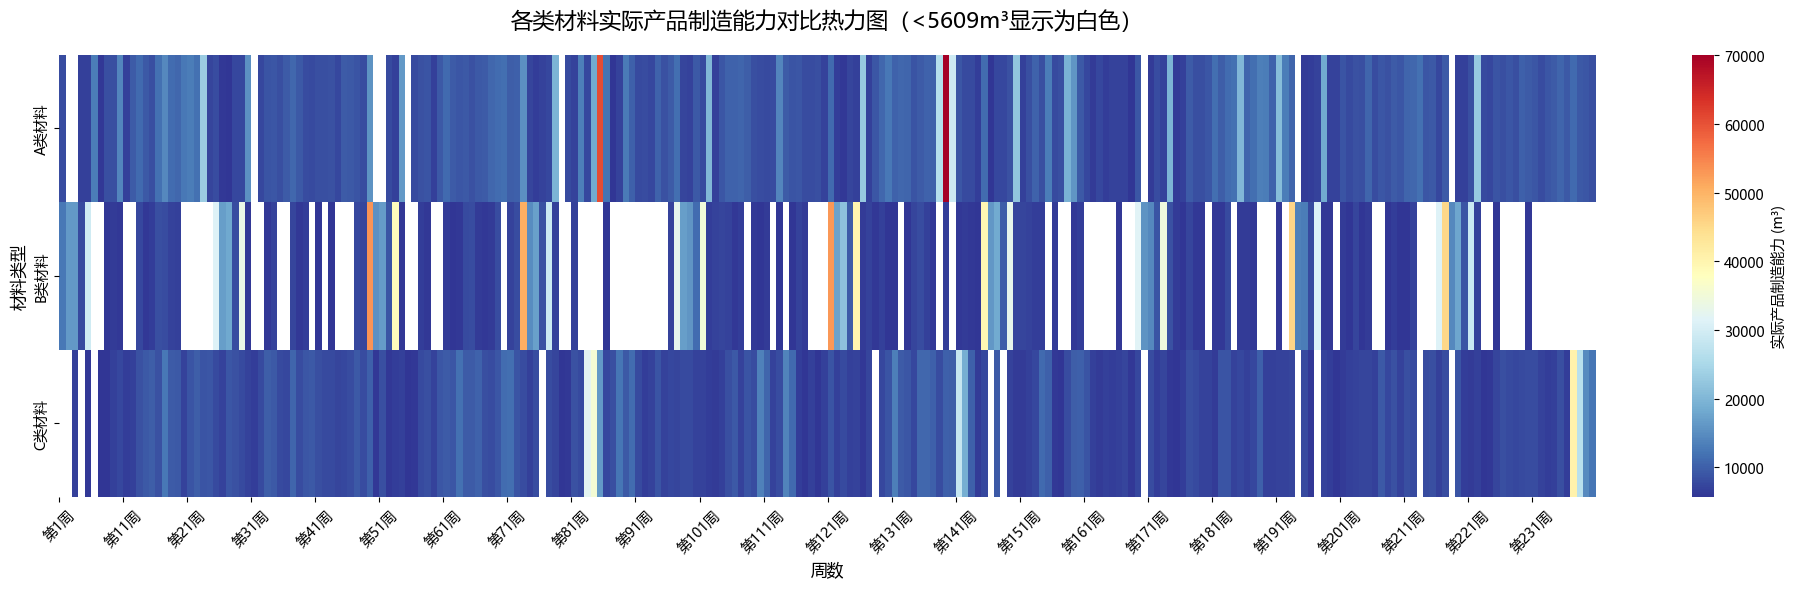


正在保存供货规模分析结果到Excel...
  ✓ 已保存到: DataFrames/供货规模产品制造能力分析_20250802_125444.xlsx

各材料类型实际产品制造能力TOP10排行榜:

A类材料实际产品制造能力TOP10:
排名   供应商名称        总实际制造能力(m³)        平均周实际制造能力(m³)          有效周数    
---------------------------------------------------------------------------
1    S229         591478.3           2464.5                 240     
2    S282         282233.3           1176.0                 240     
3    S275         264255.0           1101.1                 240     
4    S329         260863.3           1086.9                 240     
5    S348         154035.0           794.0                  194     
6    S352         148385.0           618.3                  240     
7    S143         137978.3           574.9                  240     
8    S201         136648.3           4880.3                 28      
9    S307         130326.7           762.1                  171     
10   S395         126405.0           1708.2                 74      

B类材料实际产品制造能力TOP10:
排名   供应商名称        总实际制造

In [15]:
# ==================== 供货规模（原材料制造出的产品总量）分析 ====================
print("\n" + "="*60)
print("供货规模（原材料制造出的产品总量）热力图分析")
print("="*60)
print("注：供货规模基于实际供货量计算，反映供应商实际提供的原材料制造能力")

def calculate_supply_scale():
    """
    计算供货规模（基于实际供货量的原材料制造出的产品总量）
    
    注意：这里使用供货量数据(supply_data)而不是订货量数据(order_data)
    
    根据题目信息：
    - A类原材料消耗量：0.6 m³/m³ (每生产1m³产品需要0.6m³A类原材料)
    - B类原材料消耗量：0.66 m³/m³ (每生产1m³产品需要0.66m³B类原材料)  
    - C类原材料消耗量：0.72 m³/m³ (每生产1m³产品需要0.72m³C类原材料)
    
    因此，原材料能制造的产品总量 = 实际供货量 / 消耗量比例
    """
    # 定义原材料消耗量比例
    material_consumption = {
        'A': 0.6,   # A类原材料消耗量 m³/m³
        'B': 0.66,  # B类原材料消耗量 m³/m³
        'C': 0.72   # C类原材料消耗量 m³/m³
    }
    
    # 初始化结果数据结构
    supply_production_data = []
    supply_production_matrix = {}
    
    # 计算每个供应商每周的实际产品制造能力（基于供货量）
    for i in range(len(supplier_names)):
        supplier_name = supplier_names[i]
        material_type = material_types[i]
        
        # 获取该供应商的实际供货量数据
        supplier_supplies = supply_data[i]  # 每周实际供货量数组
        
        # 计算该供应商的实际原材料能制造的产品总量
        # 公式：产品量 = 实际供货量 / 消耗量比例
        weekly_supply_production = supplier_supplies / material_consumption[material_type]
        
        # 存储该供应商的数据
        supplier_supply_production_data = {
            'supplier_name': supplier_name,
            'material_type': material_type,
            'weekly_supply_production': weekly_supply_production,
            'total_supply_production': np.sum(weekly_supply_production),
            'avg_weekly_supply_production': np.mean(weekly_supply_production[weekly_supply_production > 0]) if np.any(weekly_supply_production > 0) else 0,
            'max_weekly_supply_production': np.max(weekly_supply_production),
            'active_supply_weeks': np.sum(weekly_supply_production > 0)
        }
        
        supply_production_data.append(supplier_supply_production_data)
        
        # 为热力图准备矩阵数据
        if material_type not in supply_production_matrix:
            supply_production_matrix[material_type] = {}
        supply_production_matrix[material_type][supplier_name] = weekly_supply_production
    
    return supply_production_data, supply_production_matrix

# 执行计算
supply_production_data, supply_production_matrix = calculate_supply_scale()

print("供货规模计算完成！")
print(f"分析了{len(supply_production_data)}家供应商的实际产品制造能力")

# 显示各材料类型的实际产品制造能力统计
print("\n各材料类型实际产品制造能力统计:")
for material in ['A', 'B', 'C']:
    material_supply_production = [data for data in supply_production_data if data['material_type'] == material]
    
    if material_supply_production:
        total_supply_production = sum([data['total_supply_production'] for data in material_supply_production])
        avg_supply_production = np.mean([data['avg_weekly_supply_production'] for data in material_supply_production if data['avg_weekly_supply_production'] > 0])
        max_supply_production = max([data['max_weekly_supply_production'] for data in material_supply_production])
        supplier_count = len(material_supply_production)
        
        print(f"  {material}类材料 ({supplier_count}家供应商):")
        print(f"    - 总实际产品制造能力: {total_supply_production:,.0f} m³")
        print(f"    - 平均周实际产品制造能力: {avg_supply_production:,.1f} m³")
        print(f"    - 最大周实际产品制造能力: {max_supply_production:,.0f} m³")

def create_supply_production_heatmap():
    """
    绘制供货规模热力图
    """
    # 为每种材料类型绘制热力图
    for material in ['A', 'B', 'C']:
        print(f"\n正在绘制{material}类材料实际产品制造能力热力图...")
        
        # 筛选该材料类型的供应商
        material_suppliers = [data for data in supply_production_data if data['material_type'] == material]
        
        if not material_suppliers:
            print(f"  警告：{material}类材料没有供应商数据")
            continue
        
        # 按总实际产品制造能力排序，选择前30名绘制热力图
        material_suppliers.sort(key=lambda x: x['total_supply_production'], reverse=True)
        top_suppliers = material_suppliers[:30]
        
        # 将0值设置为np.nan，这样在热力图中会显示为白色
        for supplier in top_suppliers:
            supplier['weekly_supply_production'] = np.where(supplier['weekly_supply_production'] == 0, np.nan, supplier['weekly_supply_production'])
        
        cmap = plt.get_cmap('rainbow').copy()
        cmap.set_bad(color='white')  # 将0值显示为白色
       
        # 准备热力图数据
        heatmap_data = []
        supplier_labels = []
        
        for supplier_data in top_suppliers:
            heatmap_data.append(supplier_data['weekly_supply_production'])
            supplier_labels.append(supplier_data['supplier_name'])
        
        # 转换为numpy数组
        heatmap_matrix = np.array(heatmap_data)
        
        # 创建热力图
        plt.figure(figsize=(20, 12))
        
        # 使用seaborn绘制热力图
        ax = sns.heatmap(heatmap_matrix, 
                        yticklabels=supplier_labels,
                        xticklabels=[f'第{i+1}周' for i in range(heatmap_matrix.shape[1])],
                        cmap=cmap,
                        annot=False,  # 不显示数值标注（数据太多会很杂乱）
                        fmt='.1f',
                        cbar_kws={'label': '实际产品制造能力 (m³)'})
        
        plt.title(f'{material}类材料供应商实际产品制造能力热力图（TOP30）', fontsize=16, pad=20)
        plt.xlabel('周数', fontsize=12)
        plt.ylabel('供应商', fontsize=12)
        
        # 调整x轴标签显示（每10周显示一个标签）
        x_ticks = list(range(0, heatmap_matrix.shape[1], 10))
        x_labels = [f'第{i+1}周' for i in x_ticks]
        plt.xticks(x_ticks, x_labels, rotation=45)
        
        # 调整y轴标签
        plt.yticks(rotation=0, fontsize=8)
        
        plt.tight_layout()
        
        # 保存图片
        filename = f'Pictures/supply_scale_heatmap_{material}.svg'
        plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
        print(f"  ✓ 已保存: {filename}")
        plt.show()

# 绘制热力图
create_supply_production_heatmap()

def create_supply_production_comparison_heatmap():
    """
    绘制不同材料类型实际产品制造能力对比热力图
    """
    print(f"\n正在绘制材料类型实际产品制造能力对比热力图...")
    
    # 计算每种材料每周的总实际产品制造能力
    weekly_supply_production_by_material = {}
    weeks_count = len(supply_production_data[0]['weekly_supply_production'])
    
    for material in ['A', 'B', 'C']:
        weekly_total = np.zeros(weeks_count)
        
        for data in supply_production_data:
            if data['material_type'] == material:
                # 确保weekly_supply_production是数组且处理NaN值
                weekly_supply_production = data['weekly_supply_production']
                if isinstance(weekly_supply_production, np.ndarray):
                    # 将NaN值替换为0进行求和
                    weekly_supply_production_clean = np.nan_to_num(weekly_supply_production, nan=0.0)
                    weekly_total += weekly_supply_production_clean
                else:
                    weekly_total += weekly_supply_production
        
        weekly_supply_production_by_material[material] = weekly_total
    
    # 计算所有数据的15百分位数作为阈值
    all_values = []
    for material in ['A', 'B', 'C']:
        all_values.extend(weekly_supply_production_by_material[material])
    
    threshold = np.percentile(all_values, 15)  # 使用15百分位数作为阈值
    print(f"使用阈值: {threshold:.0f} m³（数据的15百分位数）")
    
    # 准备热力图数据
    heatmap_data = []
    material_labels = []
    
    for material in ['A', 'B', 'C']:
        material_weekly = weekly_supply_production_by_material[material]
        # 将小于阈值的值设置为np.nan，这样在热力图中会显示为白色
        material_weekly_with_nan = np.where(material_weekly < threshold, np.nan, material_weekly)
        heatmap_data.append(material_weekly_with_nan)
        material_labels.append(f'{material}类材料')
        
        # 统计设为白色的周数
        white_count = np.sum(material_weekly < threshold)
        print(f"{material}类材料将有 {white_count} 周显示为白色")
    
    heatmap_matrix = np.array(heatmap_data)
    
    # 创建自定义色彩映射，将NaN值（低值）显示为白色
    cmap = plt.get_cmap('RdYlBu_r').copy()
    cmap.set_bad(color='white')  # 将NaN值（低值）显示为白色
    
    # 创建热力图
    plt.figure(figsize=(20, 6))
    
    ax = sns.heatmap(heatmap_matrix,
                    yticklabels=material_labels,
                    xticklabels=[f'第{i+1}周' for i in range(heatmap_matrix.shape[1])],
                    cmap=cmap,
                    annot=False,
                    fmt='.0f',
                    cbar_kws={'label': '实际产品制造能力 (m³)'})
    
    plt.title(f'各类材料实际产品制造能力对比热力图（<{threshold:.0f}m³显示为白色）', fontsize=16, pad=20)
    plt.xlabel('周数', fontsize=12)
    plt.ylabel('材料类型', fontsize=12)
    
    # 调整x轴标签显示
    x_ticks = list(range(0, heatmap_matrix.shape[1], 10))
    x_labels = [f'第{i+1}周' for i in x_ticks]
    plt.xticks(x_ticks, x_labels, rotation=45)
    
    plt.tight_layout()
    
    # 保存图片
    filename = 'Pictures/supply_scale_comparison_heatmap.svg'
    plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
    print(f"  ✓ 已保存: {filename}")
    plt.show()

# 绘制供货规模对比热力图
create_supply_production_comparison_heatmap()

def save_supply_production_scale_to_excel():
    """
    将供货规模分析结果保存到Excel表格
    """
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print(f"\n正在保存供货规模分析结果到Excel...")
    
    # 1. 准备供应商实际产品制造能力汇总表
    supply_production_summary = []
    
    for data in supply_production_data:
        supply_production_summary.append({
            '供应商名称': data['supplier_name'],
            '材料类型': data['material_type'],
            '总实际产品制造能力_m3': round(data['total_supply_production'], 2),
            '平均周实际产品制造能力_m3': round(data['avg_weekly_supply_production'], 2),
            '最大周实际产品制造能力_m3': round(data['max_weekly_supply_production'], 2),
            '有效供货周数': data['active_supply_weeks']
        })
    
    supply_production_summary_df = pd.DataFrame(supply_production_summary)
    
    # 2. 准备详细的周数据表（和原表相同布局：供应商为行，周数为列）
    weeks_count = len(supply_production_data[0]['weekly_supply_production'])
    
    # 创建和原表相同格式的周数据表
    weekly_supply_data_rows = []
    
    for data in supply_production_data:
        # 构建每行数据：供应商名称 + 材料类型 + 各周实际产品制造能力
        row = {
            '供应商名称': data['supplier_name'],
            '材料类型': data['material_type']
        }
        
        # 添加各周数据列
        for week in range(weeks_count):
            week_column = f'第{week + 1}周'
            # 处理可能的NaN值，将其转换为0
            weekly_value = data['weekly_supply_production'][week]
            if np.isnan(weekly_value):
                weekly_value = 0.0
            row[week_column] = round(weekly_value, 2)
        
        weekly_supply_data_rows.append(row)
    
    supply_production_weekly_df = pd.DataFrame(weekly_supply_data_rows)
    
    # 3. 准备各材料类型统计表
    material_supply_stats = []
    
    for material in ['A', 'B', 'C']:
        material_supply_production = [data for data in supply_production_data if data['material_type'] == material]
        
        if material_supply_production:
            total_supply_production = sum([data['total_supply_production'] for data in material_supply_production])
            avg_supply_production = np.mean([data['avg_weekly_supply_production'] for data in material_supply_production if data['avg_weekly_supply_production'] > 0])
            max_supply_production = max([data['max_weekly_supply_production'] for data in material_supply_production])
            supplier_count = len(material_supply_production)
            
            material_supply_stats.append({
                '材料类型': f'{material}类',
                '供应商数量': supplier_count,
                '总实际产品制造能力_m3': round(total_supply_production, 2),
                '平均周实际产品制造能力_m3': round(avg_supply_production, 2),
                '最大周实际产品制造能力_m3': round(max_supply_production, 2)
            })
    
    material_supply_stats_df = pd.DataFrame(material_supply_stats)
    
    # 4. 保存到Excel文件
    filename = f"DataFrames/供货规模产品制造能力分析_{timestamp}.xlsx"
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # 汇总表
        supply_production_summary_df.to_excel(writer, sheet_name='实际产品制造能力汇总', index=False)
        
        # 周数据表（原表布局格式）
        supply_production_weekly_df.to_excel(writer, sheet_name='周实际产品制造能力_原表布局', index=False)
        
        # 材料类型统计表
        material_supply_stats_df.to_excel(writer, sheet_name='材料类型实际制造能力统计', index=False)
        
        # 按材料类型分组的排行榜
        for material in ['A', 'B', 'C']:
            material_data = supply_production_summary_df[supply_production_summary_df['材料类型'] == material].copy()
            if not material_data.empty:
                material_data = material_data.sort_values('总实际产品制造能力_m3', ascending=False)
                material_data.reset_index(drop=True, inplace=True)
                material_data.index = range(1, len(material_data) + 1)
                material_data.index.name = '排名'
                
                sheet_name = f'{material}类材料实际制造能力排行榜'
                material_data.to_excel(writer, sheet_name=sheet_name)
    
    print(f"  ✓ 已保存到: {filename}")
    
    # 5. 显示排行榜信息
    print(f"\n各材料类型实际产品制造能力TOP10排行榜:")
    for material in ['A', 'B', 'C']:
        print(f"\n{material}类材料实际产品制造能力TOP10:")
        material_data = supply_production_summary_df[supply_production_summary_df['材料类型'] == material]
        top10 = material_data.nlargest(10, '总实际产品制造能力_m3')
        
        print(f"{'排名':<4} {'供应商名称':<12} {'总实际制造能力(m³)':<18} {'平均周实际制造能力(m³)':<22} {'有效周数':<8}")
        print("-" * 75)
        
        for idx, (_, row) in enumerate(top10.iterrows(), 1):
            print(f"{idx:<4} {row['供应商名称']:<12} {row['总实际产品制造能力_m3']:<18.1f} "
                  f"{row['平均周实际产品制造能力_m3']:<22.1f} {row['有效供货周数']:<8}")
    
    return filename

# 保存数据到Excel
supply_excel_file = save_supply_production_scale_to_excel()

print(f"\n" + "="*60)
print("供货规模（原材料制造出的产品总量）分析完成！")
print("="*60)
print(f"✓ 已生成热力图:")
print(f"  - A类材料实际产品制造能力热力图")
print(f"  - B类材料实际产品制造能力热力图") 
print(f"  - C类材料实际产品制造能力热力图")
print(f"  - 材料类型实际产品制造能力对比热力图")
print(f"✓ 已保存Excel表格: {supply_excel_file}")
print(f"✓ 图片文件保存在Pictures文件夹")
print(f"✓ 数据文件保存在DataFrames文件夹")

# 对比订货规模和供货规模
print(f"\n" + "="*60)
print("订货规模 vs 供货规模 对比分析")
print("="*60)

comparison_data = []
for material in ['A', 'B', 'C']:
    # 订货规模统计
    order_material_production = [data for data in production_data if data['material_type'] == material]
    order_total = sum([data['total_production'] for data in order_material_production])
    
    # 供货规模统计
    supply_material_production = [data for data in supply_production_data if data['material_type'] == material]
    supply_total = sum([data['total_supply_production'] for data in supply_material_production])
    
    # 计算实现率
    fulfillment_rate = (supply_total / order_total * 100) if order_total > 0 else 0
    
    comparison_data.append({
        '材料类型': f'{material}类',
        '订货规模总产品制造能力_m3': round(order_total, 2),
        '供货规模总产品制造能力_m3': round(supply_total, 2),
        '供货实现率_%': round(fulfillment_rate, 2),
        '缺口_m3': round(order_total - supply_total, 2)
    })

comparison_df = pd.DataFrame(comparison_data)
print("订货规模 vs 供货规模对比:")
print(comparison_df.to_string(index=False))

print(f"\n总体对比:")
total_order = comparison_df['订货规模总产品制造能力_m3'].sum()
total_supply = comparison_df['供货规模总产品制造能力_m3'].sum()
overall_fulfillment = (total_supply / total_order * 100) if total_order > 0 else 0
total_gap = total_order - total_supply

print(f"  - 总订货规模: {total_order:,.0f} m³")
print(f"  - 总供货规模: {total_supply:,.0f} m³")
print(f"  - 总体实现率: {overall_fulfillment:.2f}%")
print(f"  - 总体缺口: {total_gap:,.0f} m³")

In [16]:
# 展示新的周数据表布局示例（前5行，前10列）
print("新的周数据表布局示例（与原表一致的格式）:")
print("=" * 80)

# 创建一个临时的小表格用于展示
temp_display_data = []
weeks_count = len(production_data[0]['weekly_production'])

for i, data in enumerate(production_data[:5]):  # 只展示前5个供应商
    row = {
        '供应商名称': data['supplier_name'],
        '材料类型': data['material_type']
    }
    
    # 只添加前10周的数据列用于展示
    for week in range(min(10, weeks_count)):
        week_column = f'第{week + 1}周'
        row[week_column] = round(data['weekly_production'][week], 2)
    
    temp_display_data.append(row)

temp_df = pd.DataFrame(temp_display_data)
print(temp_df.to_string(index=False))

print(f"\n表格说明:")
print(f"- 表格布局：供应商为行，周数为列（与原表一致）")
print(f"- 总行数：{len(production_data)} 个供应商")
print(f"- 总列数：2（基本信息列）+ {weeks_count}（周数据列）= {weeks_count + 2} 列")
print(f"- 数据类型：产品制造能力（m³）")
print(f"- 已保存到Excel工作表：'周产品制造能力数据_原表布局'")

新的周数据表布局示例（与原表一致的格式）:
供应商名称 材料类型   第1周    第2周   第3周    第4周    第5周    第6周    第7周    第8周    第9周   第10周
 S001    B  0.00   0.00   0.0   0.00   0.00   0.00   0.00   0.00   0.00   0.00
 S002    A  1.67   0.00   0.0   1.67   0.00   0.00   0.00   0.00   0.00   3.33
 S003    C 11.11   1.39   NaN    NaN    NaN   1.39   6.94  80.56 152.78 240.28
 S004    B  0.00   0.00   0.0   0.00   0.00   0.00   0.00   0.00   0.00   0.00
 S005    A 61.67 103.33 100.0 108.33 126.67 126.67 108.33 118.33 120.00 133.33

表格说明:
- 表格布局：供应商为行，周数为列（与原表一致）
- 总行数：402 个供应商
- 总列数：2（基本信息列）+ 240（周数据列）= 242 列
- 数据类型：产品制造能力（m³）
- 已保存到Excel工作表：'周产品制造能力数据_原表布局'


### 根据订货规模、供货规模、有效供货率、市场占有率等数据，计算出每个供货商周可靠性、年可靠性、总平均可靠性

### 供应商基础分析和转运商特征分析

包含供应商供货特征统计、转运商损耗率分析、数据可视化等基础分析内容。

In [17]:
print("供应商供货特征统计:")
print(f"  总体可靠性分布:")
print(f"    - 平均可靠性: {supplier_analysis['reliability'].mean():.3f}")
print(f"    - 可靠性中位数: {supplier_analysis['reliability'].median():.3f}")
print(f"    - 可靠性标准差: {supplier_analysis['reliability'].std():.3f}")

print(f"\n各类材料供应商特征对比:")
for material in ['A', 'B', 'C']:
    material_suppliers = supplier_analysis[supplier_analysis['material_type'] == material]
    print(f"    {material}类材料 ({len(material_suppliers)}家):")
    print(f"      - 平均可靠性: {material_suppliers['reliability'].mean():.3f}")
    print(f"      - 平均供货频率: {material_suppliers['supply_frequency'].mean():.3f}")
    print(f"      - 平均周供货量: {material_suppliers['avg_weekly_supply'].mean():.1f} m³")
    print(f"      - 总供货能力: {material_suppliers['total_supply'].sum():.0f} m³")

# 显示表现最好的供应商
print(f"\n各类材料表现最佳的前5名供应商:")
for material in ['A', 'B', 'C']:
    print(f"\n{material}类材料:")
    material_suppliers = supplier_analysis[supplier_analysis['material_type'] == material]
    top_suppliers = material_suppliers.nlargest(5, 'total_supply')
    
    for idx, (_, supplier) in enumerate(top_suppliers.iterrows(), 1):
        print(f"  {idx}. {supplier['supplier_name']}: "
              f"总供货量{supplier['total_supply']:.0f}m³, "
              f"可靠性{supplier['reliability']:.3f}, "
              f"供货频率{supplier['supply_frequency']:.3f}")

供应商供货特征统计:
  总体可靠性分布:
    - 平均可靠性: 0.540
    - 可靠性中位数: 0.492
    - 可靠性标准差: 0.427

各类材料供应商特征对比:
    A类材料 (146家):
      - 平均可靠性: 0.524
      - 平均供货频率: 0.238
      - 平均周供货量: 71.0 m³
      - 总供货能力: 1453057 m³
    B类材料 (134家):
      - 平均可靠性: 0.551
      - 平均供货频率: 0.274
      - 平均周供货量: 51.2 m³
      - 总供货能力: 1498662 m³
    C类材料 (122家):
      - 平均可靠性: 0.547
      - 平均供货频率: 0.295
      - 平均周供货量: 56.5 m³
      - 总供货能力: 1448287 m³

各类材料表现最佳的前5名供应商:

A类材料:
  1. S229: 总供货量354887m³, 可靠性0.986, 供货频率1.000
  2. S282: 总供货量169340m³, 可靠性1.005, 供货频率1.000
  3. S275: 总供货量158553m³, 可靠性1.003, 供货频率1.000
  4. S329: 总供货量156518m³, 可靠性1.001, 供货频率1.000
  5. S348: 总供货量92421m³, 可靠性0.553, 供货频率0.808

B类材料:
  1. S140: 总供货量302047m³, 可靠性0.628, 供货频率0.912
  2. S108: 总供货量240950m³, 可靠性0.888, 供货频率1.000
  3. S340: 总供货量171426m³, 可靠性0.997, 供货频率1.000
  4. S139: 总供货量151862m³, 可靠性0.854, 供货频率0.925
  5. S131: 总供货量137512m³, 可靠性0.987, 供货频率1.000

C类材料:
  1. S361: 总供货量328080m³, 可靠性0.984, 供货频率1.000
  2. S151: 总供货量194498m³, 可靠性0.730, 供货频率1.0

In [18]:
# ==================== 附件2转运商数据分析 ====================
print("\n" + "="*60)
print("步骤4：附件2转运商数据分析")
print("="*60)

print("转运商数据结构:")
print(transporter_loss.head())

# 提取转运商数据
transporter_names = transporter_loss.iloc[:, 0].values  # 转运商名称
loss_data = transporter_loss.iloc[:, 1:].values        # 损耗率数据

print(f"\n转运商基本信息:")
print(f"  - 转运商总数: {len(transporter_names)}")
print(f"  - 数据周期: {loss_data.shape[1]} 周")
print(f"  - 转运商列表: {list(transporter_names)}")

# 分析每个转运商的损耗率特征
def analyze_transporter_characteristics():
    """分析转运商损耗率特征"""
    
    transporter_metrics = []
    
    for i, name in enumerate(transporter_names):
        losses = loss_data[i]
        
        # 过滤非零损耗率
        non_zero_losses = losses[losses > 0]
        
        # 计算关键指标
        avg_loss_rate = np.mean(non_zero_losses) if len(non_zero_losses) > 0 else 0
        median_loss_rate = np.median(non_zero_losses) if len(non_zero_losses) > 0 else 0
        min_loss_rate = np.min(non_zero_losses) if len(non_zero_losses) > 0 else 0
        max_loss_rate = np.max(non_zero_losses) if len(non_zero_losses) > 0 else 0
        std_loss_rate = np.std(non_zero_losses) if len(non_zero_losses) > 0 else 0
        
        # 损耗率稳定性 (变异系数)
        cv_loss_rate = std_loss_rate / avg_loss_rate if avg_loss_rate > 0 else 0
        
        # 运输频率
        transport_frequency = len(non_zero_losses) / len(losses)
        
        transporter_metrics.append({
            'transporter_name': name,
            'avg_loss_rate': avg_loss_rate,
            'median_loss_rate': median_loss_rate,
            'min_loss_rate': min_loss_rate,
            'max_loss_rate': max_loss_rate,
            'std_loss_rate': std_loss_rate,
            'cv_loss_rate': cv_loss_rate,
            'transport_frequency': transport_frequency,
            'active_weeks': len(non_zero_losses)
        })
    
    return pd.DataFrame(transporter_metrics)

# 计算转运商特征
transporter_analysis = analyze_transporter_characteristics()

print(f"\n转运商损耗率特征分析:")
print(f"  整体损耗率统计:")
print(f"    - 平均损耗率: {transporter_analysis['avg_loss_rate'].mean():.3f}%")
print(f"    - 损耗率范围: {transporter_analysis['min_loss_rate'].min():.3f}% - {transporter_analysis['max_loss_rate'].max():.3f}%")
print(f"    - 损耗率标准差: {transporter_analysis['avg_loss_rate'].std():.3f}%")

print(f"\n各转运商详细表现:")
# 按平均损耗率排序
transporter_ranking = transporter_analysis.sort_values('avg_loss_rate')

for idx, (_, transporter) in enumerate(transporter_ranking.iterrows(), 1):
    print(f"  {idx}. {transporter['transporter_name']}:")
    print(f"     平均损耗率: {transporter['avg_loss_rate']:.3f}%")
    print(f"     损耗率范围: {transporter['min_loss_rate']:.3f}% - {transporter['max_loss_rate']:.3f}%")
    print(f"     稳定性(CV): {transporter['cv_loss_rate']:.3f}")
    print(f"     运输频率: {transporter['transport_frequency']:.3f}")

# 转运商分类
print(f"\n转运商性能分类:")
low_loss = transporter_ranking[transporter_ranking['avg_loss_rate'] < 1.0]
medium_loss = transporter_ranking[(transporter_ranking['avg_loss_rate'] >= 1.0) & 
                                  (transporter_ranking['avg_loss_rate'] < 2.0)]
high_loss = transporter_ranking[transporter_ranking['avg_loss_rate'] >= 2.0]

print(f"  低损耗率转运商 (<1.0%): {list(low_loss['transporter_name'])}")
print(f"  中等损耗率转运商 (1.0%-2.0%): {list(medium_loss['transporter_name'])}")
print(f"  高损耗率转运商 (>2.0%): {list(high_loss['transporter_name'])}")

print(f"\n转运商选择建议:")
print(f"  推荐优先使用: {list(low_loss['transporter_name'][:3])}")
print(f"  备选方案: {list(medium_loss['transporter_name'][:2])}")


步骤4：附件2转运商数据分析
转运商数据结构:
  转运商ID    W001    W002    W003    W004    W005    W006    W007    W008  \
0    T1  1.5539  1.6390  0.8124  1.2233  1.1194  1.1572  1.0769  1.1194   
1    T2  0.7092  1.2411  0.3546  1.5957  1.0638  0.7092  0.5319  1.0638   
2    T3  0.0000  0.0000  0.0971  0.0000  0.1295  0.0000  0.0324  0.0000   
3    T4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
4    T5  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

     W009  ...    W231    W232    W233    W234    W235    W236    W237  \
0  1.9129  ...  1.7240  1.5492  1.5870  1.3414  1.4453  1.5964  1.8137   
1  1.4184  ...  0.1773  1.2411  0.7092  0.3546  0.1773  0.3546  0.5319   
2  0.0000  ...  0.0000  0.0000  0.0324  0.0000  0.0971  0.0000  0.0647   
3  0.0000  ...  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
4  1.7391  ...  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

     W238    W239    W240  
0  1.7051  1.8279  1.9224  
1  0.8865  0.3546  0.70


步骤5：数据可视化分析


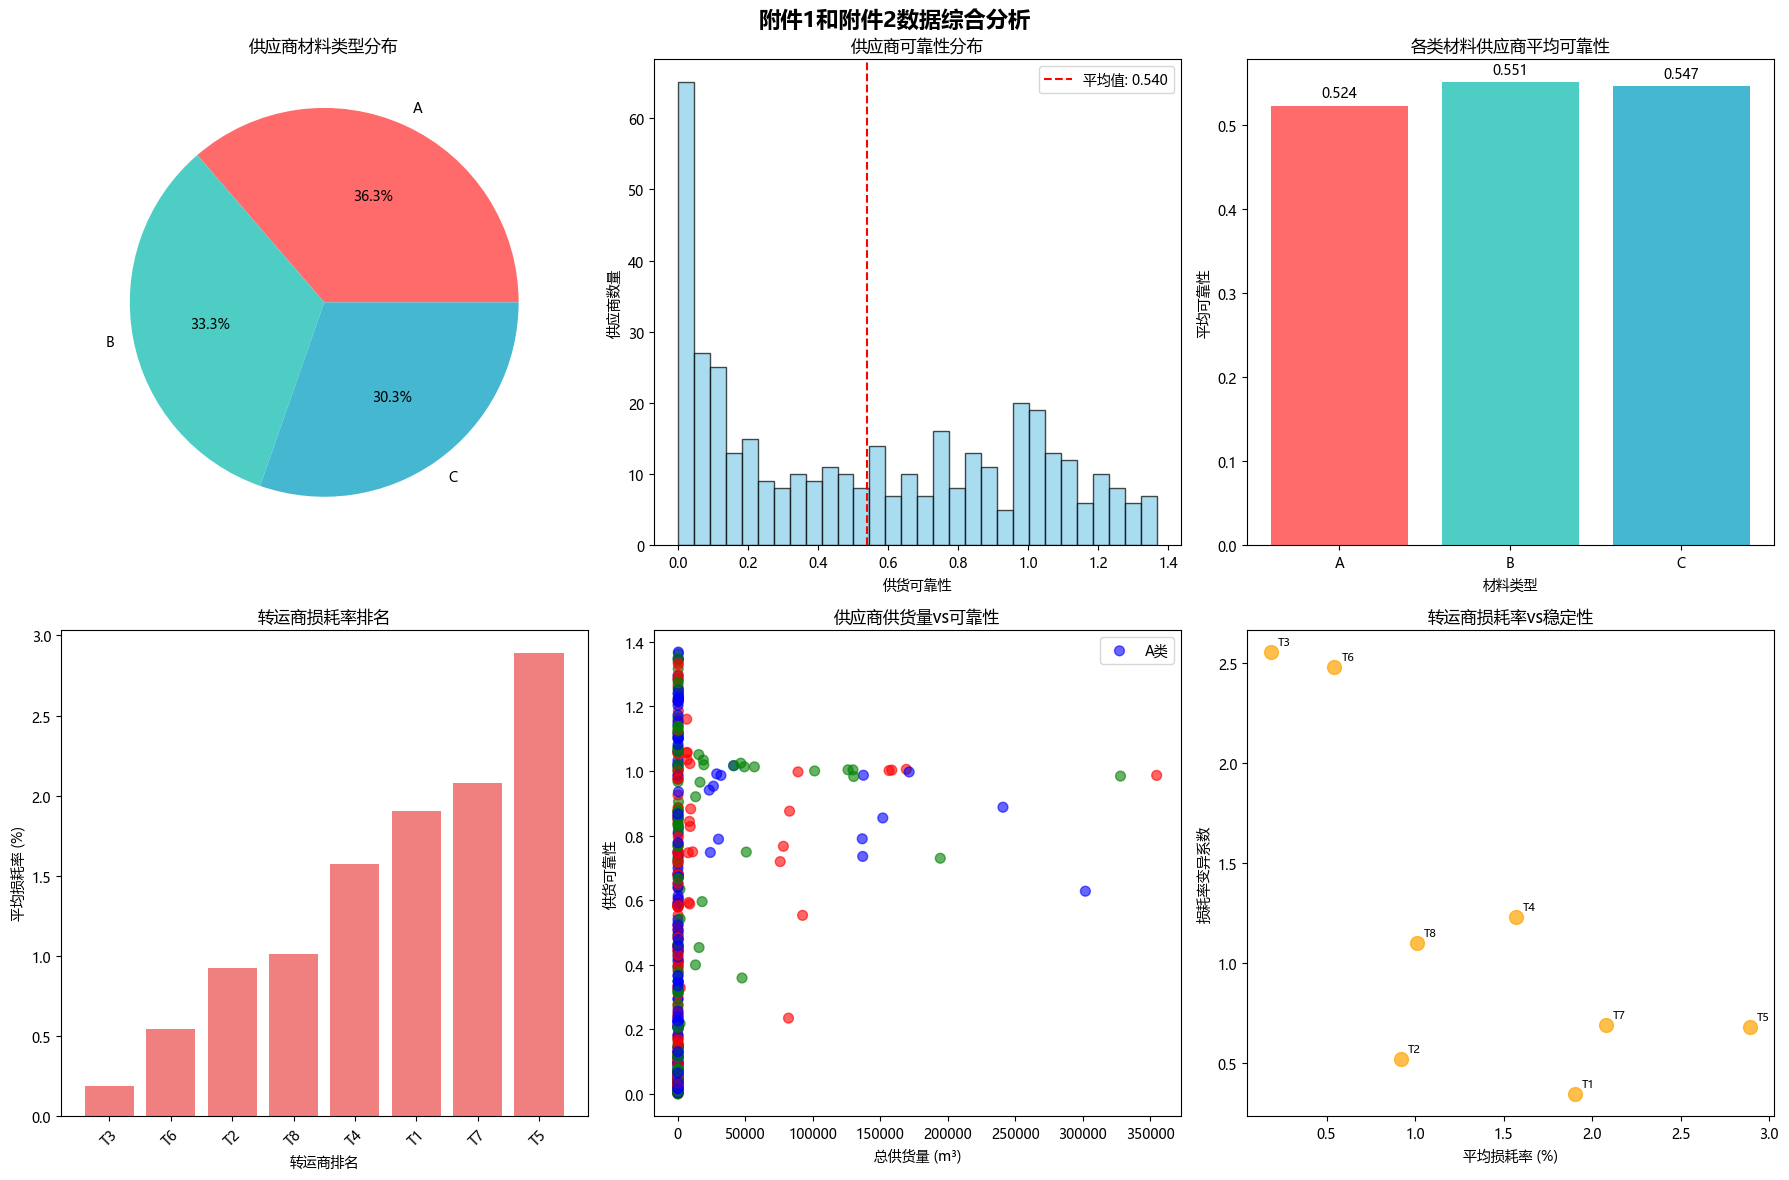

可视化分析完成！
主要发现:
  1. 供应商可靠性差异较大，平均值为 0.540
  2. 转运商损耗率范围: 0.186% - 2.890%
  3. 最优转运商: T3 (损耗率: 0.186%)
  4. 各类材料供应商数量基本均衡，但表现存在差异


In [19]:
# ==================== 数据可视化分析 ====================
print("\n" + "="*60)
print("步骤5：数据可视化分析")
print("="*60)

# 创建综合分析图表
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('附件1和附件2数据综合分析', fontsize=16, fontweight='bold')

# 1. 供应商材料类型分布
material_counts = supplier_analysis['material_type'].value_counts()
axes[0, 0].pie(material_counts.values, labels=material_counts.index, autopct='%1.1f%%', 
               colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('供应商材料类型分布')

# 2. 供应商可靠性分布
axes[0, 1].hist(supplier_analysis['reliability'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('供货可靠性')
axes[0, 1].set_ylabel('供应商数量')
axes[0, 1].set_title('供应商可靠性分布')
axes[0, 1].axvline(supplier_analysis['reliability'].mean(), color='red', linestyle='--', 
                   label=f'平均值: {supplier_analysis["reliability"].mean():.3f}')
axes[0, 1].legend()

# 3. 各类材料供应商表现对比
material_reliability = supplier_analysis.groupby('material_type')['reliability'].mean()
axes[0, 2].bar(material_reliability.index, material_reliability.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 2].set_xlabel('材料类型')
axes[0, 2].set_ylabel('平均可靠性')
axes[0, 2].set_title('各类材料供应商平均可靠性')
for i, v in enumerate(material_reliability.values):
    axes[0, 2].text(i, v + 0.01, f'{v:.3f}', ha='center')

# 4. 转运商损耗率排名
transporter_sorted = transporter_analysis.sort_values('avg_loss_rate')
axes[1, 0].bar(range(len(transporter_sorted)), transporter_sorted['avg_loss_rate'], 
               color='lightcoral')
axes[1, 0].set_xlabel('转运商排名')
axes[1, 0].set_ylabel('平均损耗率 (%)')
axes[1, 0].set_title('转运商损耗率排名')
axes[1, 0].set_xticks(range(len(transporter_sorted)))
axes[1, 0].set_xticklabels(transporter_sorted['transporter_name'], rotation=45)

# 5. 供应商总供货量分布
axes[1, 1].scatter(supplier_analysis['total_supply'], supplier_analysis['reliability'],
                   c=supplier_analysis['material_type'].map({'A': 'red', 'B': 'blue', 'C': 'green'}),
                   alpha=0.6, s=50)
axes[1, 1].set_xlabel('总供货量 (m³)')
axes[1, 1].set_ylabel('供货可靠性')
axes[1, 1].set_title('供应商供货量vs可靠性')
axes[1, 1].legend(['A类', 'B类', 'C类'])

# 6. 转运商损耗率vs稳定性
axes[1, 2].scatter(transporter_analysis['avg_loss_rate'], transporter_analysis['cv_loss_rate'],
                   s=100, alpha=0.7, color='orange')
axes[1, 2].set_xlabel('平均损耗率 (%)')
axes[1, 2].set_ylabel('损耗率变异系数')
axes[1, 2].set_title('转运商损耗率vs稳定性')

# 为每个点添加标签
for i, name in enumerate(transporter_analysis['transporter_name']):
    axes[1, 2].annotate(name, 
                        (transporter_analysis.iloc[i]['avg_loss_rate'], 
                         transporter_analysis.iloc[i]['cv_loss_rate']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print("可视化分析完成！")
print("主要发现:")
print(f"  1. 供应商可靠性差异较大，平均值为 {supplier_analysis['reliability'].mean():.3f}")
print(f"  2. 转运商损耗率范围: {transporter_analysis['avg_loss_rate'].min():.3f}% - {transporter_analysis['avg_loss_rate'].max():.3f}%")
print(f"  3. 最优转运商: {transporter_sorted.iloc[0]['transporter_name']} (损耗率: {transporter_sorted.iloc[0]['avg_loss_rate']:.3f}%)")
print(f"  4. 各类材料供应商数量基本均衡，但表现存在差异")

In [20]:
# ==================== 数据分析总结与建议 ====================
print("\n" + "="*60)
print("步骤6：数据分析总结与战略建议")
print("="*60)

# 生成供应商重要性排名
def calculate_supplier_importance_score(supplier_analysis):
    """计算供应商重要性综合评分"""
    
    # 标准化各项指标
    scaler_metrics = supplier_analysis.copy()
    
    # 归一化处理
    scaler_metrics['norm_total_supply'] = (scaler_metrics['total_supply'] - scaler_metrics['total_supply'].min()) / (scaler_metrics['total_supply'].max() - scaler_metrics['total_supply'].min())
    scaler_metrics['norm_reliability'] = scaler_metrics['reliability']
    scaler_metrics['norm_stability'] = (scaler_metrics['stability'] - scaler_metrics['stability'].min()) / (scaler_metrics['stability'].max() - scaler_metrics['stability'].min())
    scaler_metrics['norm_frequency'] = scaler_metrics['supply_frequency']
    
    # 材料类型权重 (A类最重要，价格最高)
    material_weights = {'A': 1.2, 'B': 1.1, 'C': 1.0}
    scaler_metrics['material_weight'] = scaler_metrics['material_type'].map(material_weights)
    
    # 综合评分 (总供货量40% + 可靠性30% + 稳定性15% + 频率10% + 材料类型5%)
    scaler_metrics['importance_score'] = (
        0.40 * scaler_metrics['norm_total_supply'] +
        0.30 * scaler_metrics['norm_reliability'] +
        0.15 * scaler_metrics['norm_stability'] +
        0.10 * scaler_metrics['norm_frequency'] +
        0.05 * scaler_metrics['material_weight']
    )
    
    return scaler_metrics.sort_values('importance_score', ascending=False)

# 计算供应商重要性排名
supplier_ranking = calculate_supplier_importance_score(supplier_analysis)

print("TOP 20 最重要供应商排名:")
print("-" * 80)
print(f"{'排名':<4} {'供应商':<12} {'类型':<4} {'总供货量':<10} {'可靠性':<8} {'重要性评分':<10}")
print("-" * 80)

for i in range(min(20, len(supplier_ranking))):
    supplier = supplier_ranking.iloc[i]
    print(f"{i+1:<4} {supplier['supplier_name']:<12} {supplier['material_type']:<4} "
          f"{supplier['total_supply']:<10.0f} {supplier['reliability']:<8.3f} "
          f"{supplier['importance_score']:<10.3f}")

# 转运商最优选择策略
transporter_optimal = transporter_analysis.sort_values(['avg_loss_rate', 'cv_loss_rate'])

print(f"\n转运商最优选择策略:")
print(f"  推荐使用顺序 (按损耗率+稳定性):")
for i, transporter in enumerate(transporter_optimal.iterrows(), 1):
    name = transporter[1]['transporter_name']
    loss_rate = transporter[1]['avg_loss_rate']
    stability = transporter[1]['cv_loss_rate']
    print(f"    {i}. {name}: 损耗率{loss_rate:.3f}%, 稳定性{stability:.3f}")

print(f"\n关键数据洞察:")
print(f"  附件1 - 供应商数据:")
print(f"    总计402家供应商，分布相对均衡")
print(f"    平均供货可靠性: {supplier_analysis['reliability'].mean():.1%}")
print(f"    供货可靠性标准差: {supplier_analysis['reliability'].std():.3f} (差异较大)")
print(f"    A类供应商表现相对较好，平均可靠性: {supplier_analysis[supplier_analysis['material_type']=='A']['reliability'].mean():.1%}")

print(f"\n附件2 - 转运商数据:")
print(f"    总计8家转运商，损耗率差异显著")
print(f"    最低损耗率: {transporter_analysis['avg_loss_rate'].min():.3f}% (T3)")
print(f"    最高损耗率: {transporter_analysis['avg_loss_rate'].max():.3f}% (T5)")
print(f"    损耗率范围: {transporter_analysis['avg_loss_rate'].max() - transporter_analysis['avg_loss_rate'].min():.3f}%")

print(f"\n战略建议:")
print(f"  供应商管理:")
print(f"    1. 重点合作前50名供应商，覆盖各类材料")
print(f"    2. 建立供应商分级管理体系")
print(f"    3. 针对低可靠性供应商制定改进计划")
print(f"    4. 平衡各类材料供应商数量和能力")

print(f"\n转运商选择:")
print(f"    1. 优先选择T3、T6、T2等低损耗率转运商")
print(f"    2. 建立转运商绩效监控机制")
print(f"    3. 与多家转运商保持合作关系确保供应安全")
print(f"    4. 考虑损耗率和稳定性的综合评估")

print(f"\n风险管控:")
print(f"    1. 建立供应商和转运商备选方案")
print(f"    2. 定期评估供应商表现并动态调整")
print(f"    3. 制定应急预案应对供应中断")

print(f"\n" + "="*60)
print("附件1和附件2数据分析完成！")
print("数据已为后续问题求解提供了坚实基础。")
print("="*60)


步骤6：数据分析总结与战略建议
TOP 20 最重要供应商排名:
--------------------------------------------------------------------------------
排名   供应商          类型   总供货量       可靠性      重要性评分     
--------------------------------------------------------------------------------
1    S229         A    354887     0.986    0.856     
2    S361         C    328080     0.984    0.815     
3    S108         B    240950     0.888    0.693     
4    S140         B    302047     0.628    0.675     
5    S282         A    169340     1.005    0.653     
6    S340         B    171426     0.997    0.648     
7    S275         A    158553     1.003    0.640     
8    S329         A    156518     1.001    0.638     
9    S131         B    137512     0.987    0.607     
10   S268         C    129786     1.003    0.598     
11   S306         C    126096     1.003    0.594     
12   S356         C    130307     0.983    0.592     
13   S151         C    194498     0.730    0.588     
14   S139         B    151862     0.854    0.575

### 供应商可靠性综合评估

基于以下指标计算每个供应商的可靠性评分：
- **订货规模权重**：供应商的订货量规模占比
- **供货规模权重**：供应商的实际供货量规模占比  
- **有效供货率权重**：供应商的订单完成能力
- **市场占有率权重**：供应商在同类材料中的市场份额
- **供货频率权重**：供应商的供货频率和稳定性

#### 可靠性评估方法

##### 计算公式
```
可靠性得分 = w1×订货规模得分 + w2×供货规模得分 + w3×供货率得分 + w4×市场占有率得分 + w5×供货频率得分
```

其中：
- **w1, w2, w3, w4, w5** 为各指标权重，总和为1
- 各项得分均标准化到0-100分
- 支持权重自定义调整

In [21]:
def calculate_supplier_reliability(weights=[0.20, 0.25, 0.30, 0.15, 0.10]):
    """
    计算每个供应商的可靠性评分
    
    参数:
    weights: 各指标权重列表 [订货规模权重, 供货规模权重, 供货率权重, 市场占有率权重, 供货频率权重]
            默认权重为 [0.20, 0.25, 0.30, 0.15, 0.10]，可通过参数调整
    
    返回:
    reliability_results: 包含所有可靠性评估结果的字典
    """
    
    print("\n" + "="*70)
    print("供应商可靠性综合评估")
    print("="*70)
    print(f"权重设置: 订货规模({weights[0]:.2f}) + 供货规模({weights[1]:.2f}) + " + 
          f"供货率({weights[2]:.2f}) + 市场占有率({weights[3]:.2f}) + 供货频率({weights[4]:.2f}) = {sum(weights):.2f}")
    
    if abs(sum(weights) - 1.0) > 0.001:
        print("⚠️  警告：权重总和不等于1，将自动标准化")
        weights = [w/sum(weights) for w in weights]
        print(f"标准化后权重: {[f'{w:.3f}' for w in weights]}")
    
    # 初始化结果存储
    reliability_results = {}
    
    # 按材料类型分别计算，确保可比性
    for material in ['A', 'B', 'C']:
        print(f"\n正在计算{material}类材料供应商可靠性...")
        
        # 筛选该材料类型的供应商
        material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                             if metrics['material_type'] == material]
        
        if not material_suppliers:
            continue
            
        # 提取各项指标数据用于标准化
        order_volumes = [metrics['total_order'] for _, metrics in material_suppliers]
        supply_volumes = [metrics['total_supply'] for _, metrics in material_suppliers]
        fulfillment_rates = [metrics['total_fulfillment_rate'] for _, metrics in material_suppliers]
        market_shares = [metrics['total_market_share_order'] for _, metrics in material_suppliers]
        
        # 从supplier_analysis中获取供货频率数据
        supply_frequencies = []
        for supplier_name, _ in material_suppliers:
            supplier_freq = supplier_analysis[supplier_analysis['supplier_name'] == supplier_name]['supply_frequency']
            if not supplier_freq.empty:
                supply_frequencies.append(supplier_freq.iloc[0])
            else:
                supply_frequencies.append(0.0)
        
        # 避免除零错误，为空列表设置默认值
        if not order_volumes:
            continue
            
        # 数据标准化到0-100分 (使用Min-Max标准化)
        def normalize_to_100(values):
            if not values or max(values) == min(values):
                return [0] * len(values)
            min_val, max_val = min(values), max(values)
            return [(v - min_val) / (max_val - min_val) * 100 for v in values]
        
        # 标准化各项指标
        order_scores = normalize_to_100(order_volumes)        # 订货规模得分
        supply_scores = normalize_to_100(supply_volumes)      # 供货规模得分
        fulfillment_scores = [min(rate * 100, 100) for rate in fulfillment_rates]  # 供货率得分(直接转百分制)
        market_share_scores = normalize_to_100(market_shares) # 市场占有率得分
        frequency_scores = normalize_to_100(supply_frequencies) # 供货频率得分
        
        # 计算每个供应商的可靠性得分
        for i, (supplier_name, metrics) in enumerate(material_suppliers):
            # 计算综合可靠性得分
            reliability_score = (
                weights[0] * order_scores[i] +      # 订货规模权重
                weights[1] * supply_scores[i] +     # 供货规模权重  
                weights[2] * fulfillment_scores[i] + # 供货率权重
                weights[3] * market_share_scores[i] + # 市场占有率权重
                weights[4] * frequency_scores[i]    # 供货频率权重
            )
            
            # 计算各年的可靠性（假设240周=5年，每年48周）
            weeks_per_year = 48
            total_weeks = len(metrics['weekly_fulfillment_rate'])
            years = total_weeks // weeks_per_year
            
            yearly_reliability = []
            weekly_reliability = []
            
            # 计算周可靠性
            for week_idx in range(total_weeks):
                # 当周的各项指标
                supplier_idx = next((j for j, name in enumerate(supplier_names) if name == supplier_name), -1)
                if supplier_idx >= 0 and week_idx < len(order_data[0]):
                    week_order = order_data[supplier_idx][week_idx]
                    week_supply = supply_data[supplier_idx][week_idx]
                else:
                    week_order = 0
                    week_supply = 0
                
                week_fulfillment = metrics['weekly_fulfillment_rate'][week_idx]
                week_market_share = metrics['weekly_market_share_order'][week_idx]
                week_frequency = 1.0 if week_supply > 0 else 0.0  # 当周是否有供货
                
                # 周指标标准化（相对于该材料类型的周平均值）
                week_order_score = (week_order / max(order_volumes)) * 100 if max(order_volumes) > 0 else 0
                week_supply_score = (week_supply / max(supply_volumes)) * 100 if max(supply_volumes) > 0 else 0
                week_fulfillment_score = min(week_fulfillment * 100, 100)
                week_market_share_score = (week_market_share / max(market_shares)) * 100 if max(market_shares) > 0 else 0
                week_frequency_score = week_frequency * 100
                
                # 周可靠性得分
                week_reliability = (
                    weights[0] * week_order_score +
                    weights[1] * week_supply_score +
                    weights[2] * week_fulfillment_score +
                    weights[3] * week_market_share_score +
                    weights[4] * week_frequency_score
                )
                weekly_reliability.append(round(week_reliability, 2))
            
            # 计算年可靠性（按年划分周数据）
            for year in range(years):
                start_week = year * weeks_per_year
                end_week = min((year + 1) * weeks_per_year, total_weeks)
                year_weeks = weekly_reliability[start_week:end_week]
                
                if year_weeks:
                    year_avg_reliability = sum(year_weeks) / len(year_weeks)
                    yearly_reliability.append(round(year_avg_reliability, 2))
            
            # 计算总平均可靠性
            total_avg_reliability = sum(weekly_reliability) / len(weekly_reliability) if weekly_reliability else 0
            
            # 存储结果
            reliability_results[supplier_name] = {
                'material_type': material,
                'reliability_score': round(reliability_score, 2),
                'order_score': round(order_scores[i], 2),
                'supply_score': round(supply_scores[i], 2),
                'fulfillment_score': round(fulfillment_scores[i], 2),
                'market_share_score': round(market_share_scores[i], 2),
                'frequency_score': round(frequency_scores[i], 2),
                'weekly_reliability': weekly_reliability,
                'yearly_reliability': yearly_reliability,
                'total_avg_reliability': round(total_avg_reliability, 2),
                'total_order': metrics['total_order'],
                'total_supply': metrics['total_supply'],
                'total_fulfillment_rate': metrics['total_fulfillment_rate'],
                'total_market_share': metrics['total_market_share_order'],
                'supply_frequency': supply_frequencies[i]
            }
    
    print("\n供应商可靠性计算完成！")
    print(f"总计评估了 {len(reliability_results)} 家供应商")
    
    return reliability_results

# 执行可靠性计算 (默认权重)
reliability_results = calculate_supplier_reliability()

# 显示各材料类型可靠性排名前10的供应商
print("\n" + "="*70)
print("各材料类型供应商可靠性排名 TOP 10")
print("="*70)

for material in ['A', 'B', 'C']:
    print(f"\n{material}类材料供应商可靠性排名:")
    material_reliability = [(name, data) for name, data in reliability_results.items() 
                           if data['material_type'] == material]
    material_reliability.sort(key=lambda x: x[1]['reliability_score'], reverse=True)
    
    print(f"{'排名':<4} {'供应商':<10} {'可靠性得分':<10} {'订货得分':<8} {'供货得分':<8} {'供货率得分':<10} {'市场份额得分':<10} {'供货频率得分':<10}")
    print("-" * 95)
    
    for i, (name, data) in enumerate(material_reliability[:10], 1):
        print(f"{i:<4} {name:<10} {data['reliability_score']:<10.2f} " +
              f"{data['order_score']:<8.2f} {data['supply_score']:<8.2f} " +
              f"{data['fulfillment_score']:<10.2f} {data['market_share_score']:<10.2f} " +
              f"{data['frequency_score']:<10.2f}")

print(f"\n✓ 可靠性评估完成，数据已存储在 reliability_results 字典中")


供应商可靠性综合评估
权重设置: 订货规模(0.20) + 供货规模(0.25) + 供货率(0.30) + 市场占有率(0.15) + 供货频率(0.10) = 1.00

正在计算A类材料供应商可靠性...

正在计算B类材料供应商可靠性...

正在计算B类材料供应商可靠性...

正在计算C类材料供应商可靠性...

正在计算C类材料供应商可靠性...

供应商可靠性计算完成！
总计评估了 402 家供应商

各材料类型供应商可靠性排名 TOP 10

A类材料供应商可靠性排名:
排名   供应商        可靠性得分      订货得分     供货得分     供货率得分      市场份额得分     供货频率得分    
-----------------------------------------------------------------------------------------------
1    S229       99.58      100.00   100.00   98.61      100.00     100.00    
2    S282       68.32      46.83    47.71    100.00     46.83      100.00    
3    S275       66.55      43.94    44.67    100.00     43.94      100.00    
4    S329       66.23      43.44    44.10    100.00     43.44      100.00    
5    S352       54.86      24.81    25.08    99.70      24.81      100.00    
6    S143       51.29      26.27    23.32    87.54      26.27      100.00    
7    S201       47.79      96.89    23.10    23.51      96.89      10.55     
8    S348       47.41      46.43

In [23]:
def save_reliability_results_to_excel(reliability_data, weights):
    """
    将可靠性评估结果保存到Excel表格
    
    参数:
    reliability_data: 可靠性计算结果字典
    weights: 使用的权重配置
    """
    from datetime import datetime
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"DataFrames/供应商可靠性评估_{timestamp}.xlsx"
    
    print(f"\n正在保存可靠性评估结果到 {filename}...")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # ========== 1. 可靠性综合排名表 ==========
            reliability_summary = []
            for supplier_name, data in reliability_data.items():
                reliability_summary.append({
                    '供应商名称': supplier_name,
                    '材料类型': data['material_type'],
                    '综合可靠性得分': data['reliability_score'],
                    '总平均可靠性': data['total_avg_reliability'],
                    '订货规模得分': data['order_score'],
                    '供货规模得分': data['supply_score'],
                    '供货率得分': data['fulfillment_score'],
                    '市场占有率得分': data['market_share_score'],
                    '供货频率得分': data['frequency_score'],
                    '总订货量': data['total_order'],
                    '总供货量': data['total_supply'],
                    '总供货率': round(data['total_fulfillment_rate'], 4),
                    '总市场占有率': round(data['total_market_share'] * 100, 3),
                    '供货频率': round(data['supply_frequency'], 4)
                })
            
            reliability_df = pd.DataFrame(reliability_summary)
            reliability_df = reliability_df.sort_values('综合可靠性得分', ascending=False)
            reliability_df.reset_index(drop=True, inplace=True)
            reliability_df.index = range(1, len(reliability_df) + 1)
            reliability_df.index.name = '总排名'
            
            reliability_df.to_excel(writer, sheet_name='可靠性综合排名')
            
            # ========== 2. 按材料类型分组的可靠性排名 ==========
            for material in ['A', 'B', 'C']:
                material_data = reliability_df[reliability_df['材料类型'] == material].copy()
                if not material_data.empty:
                    material_data = material_data.sort_values('综合可靠性得分', ascending=False)
                    material_data.reset_index(drop=True, inplace=True)
                    material_data.index = range(1, len(material_data) + 1)
                    material_data.index.name = f'{material}类排名'
                    
                    sheet_name = f'{material}类材料可靠性排名'
                    material_data.to_excel(writer, sheet_name=sheet_name)
            
            # ========== 3. 年度可靠性数据 ==========
            yearly_data_all = []
            for supplier_name, data in reliability_data.items():
                for year_idx, year_score in enumerate(data['yearly_reliability'], 1):
                    yearly_data_all.append({
                        '供应商名称': supplier_name,
                        '材料类型': data['material_type'],
                        f'第{year_idx}年': year_score
                    })
            
            if yearly_data_all:
                # 转换为透视表格式
                yearly_pivot_data = []
                suppliers_yearly = {}
                
                for item in yearly_data_all:
                    supplier = item['供应商名称']
                    if supplier not in suppliers_yearly:
                        suppliers_yearly[supplier] = {
                            '供应商名称': supplier,
                            '材料类型': item['材料类型']
                        }
                    
                    # 提取年份和得分
                    for key, value in item.items():
                        if key.startswith('第') and key.endswith('年'):
                            suppliers_yearly[supplier][key] = value
                
                yearly_df = pd.DataFrame(list(suppliers_yearly.values()))
                yearly_df.to_excel(writer, sheet_name='年度可靠性评估', index=False)
            
            # ========== 4. 周可靠性时间序列（选择前20名） ==========
            top_20_suppliers = reliability_df.head(20)['供应商名称'].tolist()
            
            for material in ['A', 'B', 'C']:
                material_top = [s for s in top_20_suppliers 
                               if reliability_data[s]['material_type'] == material][:10]
                
                if material_top:
                    weeks_count = max(len(reliability_data[s]['weekly_reliability']) 
                                    for s in material_top)
                    week_columns = [f'第{i+1}周' for i in range(weeks_count)]
                    
                    weekly_reliability_data = pd.DataFrame()
                    weekly_reliability_data['供应商名称'] = material_top
                    
                    for i, week_col in enumerate(week_columns):
                        weekly_reliability_data[week_col] = [
                            reliability_data[supplier]['weekly_reliability'][i] 
                            if i < len(reliability_data[supplier]['weekly_reliability']) else 0
                            for supplier in material_top
                        ]
                    
                    sheet_name = f'{material}类周可靠性TOP10'
                    weekly_reliability_data.to_excel(writer, sheet_name=sheet_name, index=False)
            
            # ========== 5. 权重配置说明 ==========
            weights_info = pd.DataFrame({
                '指标': ['订货规模权重', '供货规模权重', '供货率权重', '市场占有率权重', '供货频率权重'],
                '权重值': weights,
                '权重百分比': [f'{w*100:.1f}%' for w in weights],
                '说明': [
                    '供应商订货量规模的重要性',
                    '供应商实际供货量规模的重要性', 
                    '供应商订单完成能力的重要性',
                    '供应商市场份额的重要性',
                    '供应商供货频率和稳定性的重要性'
                ]
            })
            weights_info.to_excel(writer, sheet_name='权重配置说明', index=False)
        
        print(f"✓ 可靠性评估结果已保存到: {filename}")
        print(f"✓ 包含工作表: 可靠性综合排名、各材料类型排名、年度评估、周时间序列、权重说明")
        
        return filename
        
    except Exception as e:
        print(f"✗ 保存文件失败: {str(e)}")
        return None

# 保存可靠性评估结果
saved_reliability_file = save_reliability_results_to_excel(
    reliability_results, 
    [0.20, 0.25, 0.30, 0.15, 0.10]  # 当前使用的权重
)


正在保存可靠性评估结果到 DataFrames/供应商可靠性评估_20250802_125641.xlsx...
✓ 可靠性评估结果已保存到: DataFrames/供应商可靠性评估_20250802_125641.xlsx
✓ 包含工作表: 可靠性综合排名、各材料类型排名、年度评估、周时间序列、权重说明
✓ 可靠性评估结果已保存到: DataFrames/供应商可靠性评估_20250802_125641.xlsx
✓ 包含工作表: 可靠性综合排名、各材料类型排名、年度评估、周时间序列、权重说明


In [ ]:
def plot_reliability_heatmaps(reliability_data, top_n=15):
    """
    绘制供应商可靠性热力图
    
    参数:
    reliability_data: 可靠性评估结果
    top_n: 显示前N名供应商 (默认15)
    """
    
    print(f"\n正在绘制供应商可靠性热力图 (显示前{top_n}名)...")
    
    # ========== 1. 综合可靠性得分热力图 ==========
    fig, axes = plt.subplots(2, 2, figsize=(24, 16))
    
    # 为每种材料类型绘制可靠性热力图
    for idx, material in enumerate(['A', 'B', 'C']):
        row, col = divmod(idx, 2)
        
        # 筛选该材料类型的供应商并排序
        material_suppliers = [(name, data) for name, data in reliability_data.items() 
                             if data['material_type'] == material]
        material_suppliers.sort(key=lambda x: x[1]['reliability_score'], reverse=True)
        top_suppliers = material_suppliers[:top_n]
        
        if not top_suppliers:
            continue
            
        # 准备热力图数据
        heatmap_data = []
        supplier_names = []
        
        for supplier_name, data in top_suppliers:
            supplier_names.append(supplier_name)
            heatmap_data.append([
                data['order_score'],
                data['supply_score'], 
                data['fulfillment_score'],
                data['market_share_score'],
                data['frequency_score'],
                data['reliability_score']
            ])
        
        # 转换为DataFrame
        heatmap_df = pd.DataFrame(
            heatmap_data, 
            index=supplier_names,
            columns=['订货规模', '供货规模', '供货率', '市场占有率', '供货频率', '综合可靠性']
        )
        
        # 绘制热力图，0值显示为白色
        mask = heatmap_df == 0  # 创建0值掩码
        
        sns.heatmap(heatmap_df, 
                   annot=True, 
                   fmt='.1f',
                   cmap='RdYlGn',  # 红-黄-绿色图
                   center=50,      # 以50为中心
                   square=False,
                   linewidths=0.5,
                   cbar_kws={'label': '得分'},
                   mask=mask,      # 0值显示为白色
                   ax=axes[row, col])
        
        axes[row, col].set_title(f'{material}类材料供应商可靠性评估热力图 (TOP {len(top_suppliers)})', 
                                fontsize=14, fontweight='bold')
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].tick_params(axis='y', rotation=0)
    
    # 移除第四个子图
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('Pictures/supplier_reliability_heatmap.svg', 
                format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ========== 2. 年度可靠性趋势热力图 ==========
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    for idx, material in enumerate(['A', 'B', 'C']):
        # 筛选该材料类型的供应商
        material_suppliers = [(name, data) for name, data in reliability_data.items() 
                             if data['material_type'] == material]
        material_suppliers.sort(key=lambda x: x[1]['reliability_score'], reverse=True)
        top_suppliers = material_suppliers[:min(top_n, 10)]  # 年度图显示较少供应商避免过密
        
        if not top_suppliers:
            continue
            
        # 准备年度数据
        yearly_data = []
        supplier_names = []
        
        max_years = max(len(data['yearly_reliability']) for _, data in top_suppliers)
        
        for supplier_name, data in top_suppliers:
            supplier_names.append(supplier_name)
            yearly_scores = data['yearly_reliability'] + [0] * (max_years - len(data['yearly_reliability']))
            yearly_data.append(yearly_scores)
        
        if yearly_data and max_years > 0:
            # 转换为DataFrame
            year_columns = [f'第{i+1}年' for i in range(max_years)]
            yearly_df = pd.DataFrame(yearly_data, index=supplier_names, columns=year_columns)
            
            # 创建0值掩码
            mask = yearly_df == 0
            
            # 绘制年度热力图
            sns.heatmap(yearly_df,
                       annot=True,
                       fmt='.1f', 
                       cmap='viridis',
                       square=False,
                       linewidths=0.5,
                       cbar_kws={'label': '年度可靠性得分'},
                       mask=mask,  # 0值显示为白色
                       ax=axes[idx])
            
            axes[idx].set_title(f'{material}类材料供应商年度可靠性趋势 (TOP {len(top_suppliers)})',
                               fontsize=14, fontweight='bold')
            axes[idx].tick_params(axis='x', rotation=0)
            axes[idx].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.savefig('Pictures/yearly_reliability_trend_heatmap.svg', 
                format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ========== 3. 周可靠性时间序列热力图（选择最优供应商）==========
    for material in ['A', 'B', 'C']:
        # 筛选该材料类型前5名供应商
        material_suppliers = [(name, data) for name, data in reliability_data.items() 
                             if data['material_type'] == material]
        material_suppliers.sort(key=lambda x: x[1]['reliability_score'], reverse=True)
        top_5_suppliers = material_suppliers[:5]
        
        if not top_5_suppliers:
            continue
            
        # 准备周数据
        weeks_count = max(len(data['weekly_reliability']) for _, data in top_5_suppliers)
        
        # 分段显示（每40周一段，避免图表过宽）
        segments = (weeks_count + 39) // 40
        
        for segment in range(segments):
            start_week = segment * 40
            end_week = min((segment + 1) * 40, weeks_count)
            
            weekly_data = []
            supplier_names = []
            
            for supplier_name, data in top_5_suppliers:
                supplier_names.append(supplier_name)
                segment_scores = data['weekly_reliability'][start_week:end_week]
                if len(segment_scores) < (end_week - start_week):
                    segment_scores += [0] * ((end_week - start_week) - len(segment_scores))
                weekly_data.append(segment_scores)
            
            if weekly_data:
                # 转换为DataFrame
                week_columns = [f'第{i+1}周' for i in range(start_week, end_week)]
                weekly_df = pd.DataFrame(weekly_data, index=supplier_names, columns=week_columns)
                
                # 创建0值掩码
                mask = weekly_df == 0
                
                # 绘制周可靠性热力图
                plt.figure(figsize=(20, 6))
                sns.heatmap(weekly_df,
                           annot=False,  # 周数据太多，不显示数值
                           cmap='plasma',
                           square=False,
                           linewidths=0.1,
                           cbar_kws={'label': '周可靠性得分'},
                           mask=mask)  # 0值显示为白色
                
                plt.title(f'{material}类材料TOP5供应商周可靠性热力图 (第{start_week+1}-{end_week}周)',
                         fontsize=14, fontweight='bold')
                plt.xlabel('周数', fontsize=12)
                plt.ylabel('供应商', fontsize=12)
                plt.xticks(rotation=90)
                plt.yticks(rotation=0)
                
                plt.tight_layout()
                plt.savefig(f'Pictures/weekly_reliability_heatmap_{material}_segment{segment+1}.svg', 
                           format='svg', dpi=300, bbox_inches='tight')
                plt.show()
    
    print("✓ 可靠性热力图绘制完成！")
    print("✓ 已生成: 综合可靠性热力图、年度趋势热力图、周时间序列热力图")

# 绘制可靠性热力图
plot_reliability_heatmaps(reliability_results, top_n=15)

#### 权重调整示例

可以通过修改权重数组来调整各指标的重要性：

```python
# 示例1: 更重视供货率和供货频率
reliability_results_v2 = calculate_supplier_reliability([0.15, 0.20, 0.35, 0.15, 0.15])

# 示例2: 均等权重
reliability_results_v3 = calculate_supplier_reliability([0.20, 0.20, 0.20, 0.20, 0.20])

# 示例3: 重视规模和可靠性
reliability_results_v4 = calculate_supplier_reliability([0.25, 0.30, 0.30, 0.10, 0.05])

# 示例4: 重视供货频率和市场占有率
reliability_results_v5 = calculate_supplier_reliability([0.15, 0.20, 0.25, 0.20, 0.20])
```

In [ ]:
# ========== 权重调整演示 ==========
from datetime import datetime

print("\n" + "="*70)
print("权重调整演示 - 对比不同权重配置下的结果")
print("="*70)

# 定义不同的权重配置方案
weight_configs = {
    '默认配置': [0.20, 0.25, 0.30, 0.15, 0.10],      # 平衡各指标
    '重视可靠性': [0.15, 0.20, 0.40, 0.15, 0.10],     # 更重视供货率
    '重视规模': [0.30, 0.30, 0.20, 0.15, 0.05],       # 更重视订货和供货规模  
    '重视市场': [0.15, 0.20, 0.25, 0.25, 0.15],       # 更重视市场占有率
    '重视频率': [0.15, 0.20, 0.25, 0.15, 0.25],       # 更重视供货频率
    '均等权重': [0.20, 0.20, 0.20, 0.20, 0.20]        # 各指标等权重
}

# 计算不同权重下的结果并比较
comparison_results = {}

for config_name, weights in weight_configs.items():
    print(f"\n正在计算 '{config_name}' 权重配置...")
    print(f"权重: 订货规模({weights[0]:.2f}) + 供货规模({weights[1]:.2f}) + " + 
          f"供货率({weights[2]:.2f}) + 市场占有率({weights[3]:.2f}) + 供货频率({weights[4]:.2f})")
    
    # 计算该权重配置下的可靠性结果
    config_results = calculate_supplier_reliability(weights)
    comparison_results[config_name] = config_results
    
    # 显示该配置下各材料类型的TOP3供应商
    print(f"\n'{config_name}' 配置下各材料类型TOP3供应商:")
    for material in ['A', 'B', 'C']:
        material_suppliers = [(name, data) for name, data in config_results.items() 
                             if data['material_type'] == material]
        material_suppliers.sort(key=lambda x: x[1]['reliability_score'], reverse=True)
        top_3 = material_suppliers[:3]
        
        print(f"  {material}类: {', '.join([f'{name}({data["reliability_score"]:.1f}分)' for name, data in top_3])}")

# ========== 权重影响分析 ==========
print("\n" + "="*70)
print("权重影响分析 - 对比供应商在不同权重下的排名变化")
print("="*70)

# 选择几个代表性供应商进行对比分析
sample_suppliers = []
for material in ['A', 'B', 'C']:
    material_suppliers = [(name, data) for name, data in reliability_results.items() 
                         if data['material_type'] == material]
    material_suppliers.sort(key=lambda x: x[1]['reliability_score'], reverse=True)
    sample_suppliers.extend([name for name, _ in material_suppliers[:2]])  # 每类选前2名

print(f"选择以下供应商进行权重影响分析: {', '.join(sample_suppliers)}")

# 创建权重影响对比表
weight_impact_data = []

for supplier in sample_suppliers:
    supplier_row = {'供应商': supplier}
    
    # 获取该供应商在不同权重配置下的得分
    for config_name, config_results in comparison_results.items():
        if supplier in config_results:
            supplier_row[f'{config_name}_得分'] = config_results[supplier]['reliability_score']
            
            # 计算该供应商在该配置下的排名
            same_material = [name for name, data in config_results.items() 
                           if data['material_type'] == config_results[supplier]['material_type']]
            same_material_sorted = sorted(same_material, 
                                        key=lambda x: config_results[x]['reliability_score'], 
                                        reverse=True)
            rank = same_material_sorted.index(supplier) + 1
            supplier_row[f'{config_name}_排名'] = rank
    
    weight_impact_data.append(supplier_row)

# 显示权重影响分析结果
weight_impact_df = pd.DataFrame(weight_impact_data)
print("\n权重影响分析结果:")
print("=" * 140)
print(weight_impact_df.to_string(index=False))

# 保存对比结果到Excel
print(f"\n正在保存权重对比分析结果...")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
comparison_file = f"DataFrames/权重对比分析_{timestamp}.xlsx"

try:
    with pd.ExcelWriter(comparison_file, engine='openpyxl') as writer:
        # 保存权重影响分析
        weight_impact_df.to_excel(writer, sheet_name='权重影响分析', index=False)
        
        # 保存各权重配置的详细结果
        for config_name, config_results in comparison_results.items():
            config_summary = []
            for supplier_name, data in config_results.items():
                config_summary.append({
                    '供应商名称': supplier_name,
                    '材料类型': data['material_type'],
                    '可靠性得分': data['reliability_score'],
                    '订货得分': data['order_score'],
                    '供货得分': data['supply_score'],
                    '供货率得分': data['fulfillment_score'],
                    '市场份额得分': data['market_share_score'],
                    '供货频率得分': data['frequency_score']
                })
            
            config_df = pd.DataFrame(config_summary)
            config_df = config_df.sort_values('可靠性得分', ascending=False)
            config_df.reset_index(drop=True, inplace=True)
            config_df.index = range(1, len(config_df) + 1)
            config_df.index.name = '排名'
            
            sheet_name = f'{config_name}权重结果'[:31]  # Excel工作表名长度限制
            config_df.to_excel(writer, sheet_name=sheet_name)
        
        # 保存权重配置说明
        weights_config_df = pd.DataFrame([
            {
                '权重配置': config_name,
                '订货规模权重': weights[0],
                '供货规模权重': weights[1], 
                '供货率权重': weights[2],
                '市场占有率权重': weights[3],
                '供货频率权重': weights[4],
                '配置说明': {
                    '默认配置': '平衡考虑各项指标',
                    '重视可靠性': '更注重供应商的供货可靠性',
                    '重视规模': '更注重供应商的业务规模',
                    '重视市场': '更注重供应商的市场地位',
                    '重视频率': '更注重供应商的供货频率',
                    '均等权重': '各项指标同等重要'
                }.get(config_name, '自定义配置')
            }
            for config_name, weights in weight_configs.items()
        ])
        weights_config_df.to_excel(writer, sheet_name='权重配置说明', index=False)
    
    print(f"✓ 权重对比分析结果已保存到: {comparison_file}")
    
except Exception as e:
    print(f"✗ 保存权重对比分析失败: {str(e)}")

print(f"\n" + "="*70)
print("供应商可靠性评估完成！")
print("="*70)
print("✓ 已完成多种权重配置下的可靠性计算")
print("✓ 已生成可靠性评估热力图")
print("✓ 已保存详细的Excel分析报告")
print("✓ 支持通过调整权重数组自定义评估标准")
print("✓ 新增供货频率权重，使评估更全面")
print(f"✓ 数据文件保存在 DataFrames/ 文件夹")
print(f"✓ 图表文件保存在 Pictures/ 文件夹")

#### 供应商可靠性评估系统使用说明

##### 功能特点

1. **多维度评估**：基于5个关键指标进行综合评估
   - 订货规模得分
   - 供货规模得分  
   - 有效供货率得分
   - 市场占有率得分
   - **供货频率得分**（新增）

2. **灵活权重配置**：通过调整权重数组来自定义评估标准
   ```python
   # 权重数组格式：[订货规模, 供货规模, 供货率, 市场占有率, 供货频率]
   默认权重 = [0.20, 0.25, 0.30, 0.15, 0.10]  # 平衡配置
   重视可靠性 = [0.15, 0.20, 0.40, 0.15, 0.10]  # 更重视供货率
   重视规模 = [0.30, 0.30, 0.20, 0.15, 0.05]   # 更重视业务规模
   重视市场 = [0.15, 0.20, 0.25, 0.25, 0.15]   # 更重视市场地位
   重视频率 = [0.15, 0.20, 0.25, 0.15, 0.25]   # 更重视供货频率
   ```

3. **全面输出**：
   - Excel详细报告（排名表、年度数据、周数据时间序列）
   - 可视化热力图（综合、年度趋势、周数据时间序列）
   - 零值自动显示为白色

##### 核心函数

###### `calculate_supplier_reliability(weights)`
计算供应商可靠性得分

**参数说明：**
- `weights`: 权重数组，包含5个元素 [订货规模权重, 供货规模权重, 供货率权重, 市场占有率权重, 供货频率权重]
- 权重总和应为1.0，如不满足会自动标准化

**返回值：**
- 字典格式的供应商可靠性评估结果

###### `save_reliability_results_to_excel(results, weights, filename)`
保存可靠性评估结果到Excel文件

**参数说明：**
- `results`: 可靠性评估结果字典
- `weights`: 使用的权重配置
- `filename`: 输出文件名

###### `plot_reliability_heatmaps(results, weights)`
生成可靠性评估热力图

**参数说明：**
- `results`: 可靠性评估结果字典
- `weights`: 使用的权重配置

##### 使用示例

```python
# 1. 使用默认权重计算可靠性
reliability_results = calculate_supplier_reliability()

# 2. 使用自定义权重
custom_weights = [0.25, 0.30, 0.25, 0.15, 0.05]  # 更注重规模
custom_results = calculate_supplier_reliability(custom_weights)

# 3. 保存结果到Excel
save_reliability_results_to_excel(custom_results, custom_weights, 
                                 "DataFrames/自定义权重可靠性评估_20240802.xlsx")

# 4. 生成热力图
plot_reliability_heatmaps(custom_results, custom_weights)
```

##### 权重配置建议

根据不同的业务需求，可以调整权重配置：

- **追求稳定供应**：增加供货率权重 `[0.15, 0.20, 0.40, 0.15, 0.10]`
- **重视业务规模**：增加订货/供货规模权重 `[0.30, 0.30, 0.20, 0.15, 0.05]`
- **关注市场地位**：增加市场占有率权重 `[0.15, 0.20, 0.25, 0.25, 0.15]`
- **注重供货频率**：增加供货频率权重 `[0.15, 0.20, 0.25, 0.15, 0.25]`
- **均衡评估**：使用等权重 `[0.20, 0.20, 0.20, 0.20, 0.20]`

##### 评分规则

1. **订货规模得分**：基于供应商的总订货量占比
2. **供货规模得分**：基于供应商的总供货量占比  
3. **有效供货率得分**：基于供应商的平均供货完成率
4. **市场占有率得分**：基于供应商在对应材料类型中的市场份额
5. **供货频率得分**：基于供应商的供货活跃程度（非零供货周数占比）

所有得分均标准化到0-100分，最终可靠性得分为加权平均值。

## 问题一：年度供应商权重分析与最重要供应商筛选

基于前面的可靠性评估结果，现在进行年度权重分析和最重要供应商筛选，完成PDF文件第一问的要求：

### 任务要求：
1. **年度权重排序**：对每年的权重进行排序并输出到xlsx文件（5年分5个不同的表）
2. **趋势分析**：分析供应商权重的趋势和变化并画出图表  
3. **最终权重计算**：根据5年的权重计算最终总权重（越往后的年权重值对最终权重值的影响越大）
4. **筛选重要供应商**：筛选出50个最重要供应商并输出到表格

In [24]:
# ==================== 步骤1：年度权重分析与排序 ====================
print("\n" + "="*70)
print("步骤1：年度供应商权重分析与排序")
print("="*70)

def calculate_yearly_weights(reliability_data):
    """
    计算每年的供应商权重并进行排序
    
    参数:
    reliability_data: 可靠性评估结果字典
    
    返回:
    yearly_weights: 各年度权重数据字典
    """
    
    print("正在计算各年度供应商权重...")
    
    # 假设240周=5年，每年48周
    weeks_per_year = 48
    num_years = 5
    
    yearly_weights = {}
    
    # 为每年创建权重数据
    for year in range(1, num_years + 1):
        print(f"正在计算第{year}年权重...")
        
        year_weights = []
        
        for supplier_name, data in reliability_data.items():
            # 计算该年的权重（基于年度可靠性得分）
            if len(data['yearly_reliability']) >= year:
                # 使用年度可靠性作为权重基础
                annual_reliability = data['yearly_reliability'][year-1]
                
                # 计算该年权重（结合总体指标）
                weight_score = (
                    0.40 * annual_reliability +  # 年度可靠性40%
                    0.25 * data['supply_score'] +  # 供货规模25%
                    0.20 * data['fulfillment_score'] +  # 供货率20%
                    0.10 * data['market_share_score'] +  # 市场占有率10%
                    0.05 * data['frequency_score']  # 供货频率5%
                )
                
                year_weights.append({
                    '供应商名称': supplier_name,
                    '材料类型': data['material_type'],
                    f'第{year}年权重': round(weight_score, 3),
                    f'第{year}年可靠性': round(annual_reliability, 3),
                    '总供货量': data['total_supply'],
                    '总供货率': round(data['total_fulfillment_rate'], 4),
                    '市场占有率': round(data['total_market_share'] * 100, 3)
                })
        
        # 按权重排序
        year_weights.sort(key=lambda x: x[f'第{year}年权重'], reverse=True)
        
        # 添加排名
        for i, supplier in enumerate(year_weights, 1):
            supplier[f'第{year}年排名'] = i
        
        yearly_weights[f'第{year}年'] = year_weights
        
        print(f"第{year}年权重计算完成，共{len(year_weights)}家供应商")
    
    return yearly_weights

# 计算年度权重
yearly_weights = calculate_yearly_weights(reliability_results)

# 显示各年度TOP10供应商
print("\n各年度TOP10供应商权重排名:")
print("="*70)

for year_name, year_data in yearly_weights.items():
    print(f"\n{year_name}权重排名TOP10:")
    print(f"{'排名':<4} {'供应商':<10} {'类型':<4} {'权重得分':<8} {'可靠性':<8} {'总供货量':<10}")
    print("-" * 60)
    
    for i, supplier in enumerate(year_data[:10], 1):
        year_num = year_name.replace('第', '').replace('年', '')
        print(f"{i:<4} {supplier['供应商名称']:<10} {supplier['材料类型']:<4} " +
              f"{supplier[f'第{year_num}年权重']:<8.3f} " +
              f"{supplier[f'第{year_num}年可靠性']:<8.3f} " +
              f"{supplier['总供货量']:<10.0f}")

print("✓ 年度权重分析完成！")


步骤1：年度供应商权重分析与排序
正在计算各年度供应商权重...
正在计算第1年权重...
第1年权重计算完成，共402家供应商
正在计算第2年权重...
第2年权重计算完成，共402家供应商
正在计算第3年权重...
第3年权重计算完成，共402家供应商
正在计算第4年权重...
第4年权重计算完成，共402家供应商
正在计算第5年权重...
第5年权重计算完成，共402家供应商

各年度TOP10供应商权重排名:

第1年权重排名TOP10:
排名   供应商        类型   权重得分     可靠性      总供货量      
------------------------------------------------------------
1    S229       A    84.466   61.860   354887    
2    S361       C    82.530   57.130   328080    
3    S108       B    68.531   50.480   240950    
4    S140       B    67.456   38.350   302047    
5    S151       C    62.044   49.090   194498    
6    S340       B    61.640   47.360   171426    
7    S282       A    60.986   48.440   169340    
8    S275       A    60.042   48.700   158553    
9    S329       A    59.917   48.870   156518    
10   S356       C    57.824   48.170   130307    

第2年权重排名TOP10:
排名   供应商        类型   权重得分     可靠性      总供货量      
------------------------------------------------------------
1    S229       A    83.570   59.620

In [25]:
# ==================== 步骤2：保存年度权重数据到Excel文件 ====================
print("\n" + "="*70)
print("步骤2：保存年度权重数据到Excel文件（5年分5个表）")
print("="*70)

def save_yearly_weights_to_excel(yearly_weights_data):
    """
    将年度权重数据保存到Excel文件，5年数据分为5个不同的工作表
    
    参数:
    yearly_weights_data: 年度权重数据字典
    
    返回:
    保存的文件名
    """
    from datetime import datetime
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"DataFrames/年度供应商权重排序_{timestamp}.xlsx"
    
    print(f"正在保存年度权重数据到: {filename}")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # 为每年创建一个工作表
            for year_name, year_data in yearly_weights_data.items():
                print(f"正在保存{year_name}数据...")
                
                # 转换为DataFrame
                year_df = pd.DataFrame(year_data)
                
                # 重新排列列的顺序，使其更易读
                year_num = year_name.replace('第', '').replace('年', '')
                columns_order = [
                    f'第{year_num}年排名',
                    '供应商名称', 
                    '材料类型',
                    f'第{year_num}年权重',
                    f'第{year_num}年可靠性',
                    '总供货量',
                    '总供货率',
                    '市场占有率'
                ]
                
                year_df = year_df[columns_order]
                
                # 保存到对应工作表
                sheet_name = f'{year_name}权重排序'
                year_df.to_excel(writer, sheet_name=sheet_name, index=False)
                
                print(f"  {year_name}: {len(year_data)}家供应商")
            
            # ========== 创建汇总对比表 ==========
            print("正在创建年度权重汇总对比表...")
            
            # 收集所有供应商的5年权重数据
            all_suppliers = set()
            for year_data in yearly_weights_data.values():
                for supplier in year_data:
                    all_suppliers.add(supplier['供应商名称'])
            
            # 创建汇总数据
            summary_data = []
            for supplier_name in sorted(all_suppliers):
                supplier_summary = {'供应商名称': supplier_name}
                
                # 获取供应商材料类型
                material_type = None
                for year_data in yearly_weights_data.values():
                    for supplier in year_data:
                        if supplier['供应商名称'] == supplier_name:
                            material_type = supplier['材料类型']
                            break
                    if material_type:
                        break
                
                supplier_summary['材料类型'] = material_type
                
                # 收集各年数据
                for year_num in range(1, 6):
                    year_key = f'第{year_num}年'
                    
                    # 找到该供应商在该年的数据
                    year_weight = 0
                    year_rank = '-'
                    
                    if year_key in yearly_weights_data:
                        for supplier in yearly_weights_data[year_key]:
                            if supplier['供应商名称'] == supplier_name:
                                year_weight = supplier[f'第{year_num}年权重']
                                year_rank = supplier[f'第{year_num}年排名']
                                break
                    
                    supplier_summary[f'第{year_num}年权重'] = year_weight
                    supplier_summary[f'第{year_num}年排名'] = year_rank
                
                # 计算5年平均权重
                weights = [supplier_summary[f'第{i}年权重'] for i in range(1, 6)]
                weights = [w for w in weights if w > 0]  # 排除0值
                avg_weight = sum(weights) / len(weights) if weights else 0
                supplier_summary['5年平均权重'] = round(avg_weight, 3)
                
                summary_data.append(supplier_summary)
            
            # 按5年平均权重排序
            summary_data.sort(key=lambda x: x['5年平均权重'], reverse=True)
            
            # 添加总排名
            for i, supplier in enumerate(summary_data, 1):
                supplier['总排名'] = i
            
            # 调整列顺序
            summary_columns = ['总排名', '供应商名称', '材料类型', '5年平均权重']
            for year in range(1, 6):
                summary_columns.extend([f'第{year}年权重', f'第{year}年排名'])
            
            summary_df = pd.DataFrame(summary_data)[summary_columns]
            summary_df.to_excel(writer, sheet_name='5年权重汇总对比', index=False)
            
            # ========== 创建材料类型分析表 ==========
            print("正在创建材料类型分析表...")
            
            material_analysis = []
            for material in ['A', 'B', 'C']:
                material_suppliers = [s for s in summary_data if s['材料类型'] == material]
                
                if material_suppliers:
                    material_analysis.append({
                        '材料类型': material,
                        '供应商数量': len(material_suppliers),
                        '平均权重': round(sum(s['5年平均权重'] for s in material_suppliers) / len(material_suppliers), 3),
                        '最高权重': round(max(s['5年平均权重'] for s in material_suppliers), 3),
                        '最低权重': round(min(s['5年平均权重'] for s in material_suppliers), 3),
                        'TOP10平均权重': round(sum(s['5年平均权重'] for s in material_suppliers[:10]) / min(10, len(material_suppliers)), 3)
                    })
            
            material_df = pd.DataFrame(material_analysis)
            material_df.to_excel(writer, sheet_name='材料类型权重分析', index=False)
            
            print(f"✓ 年度权重数据已成功保存到: {filename}")
            print(f"✓ 包含工作表: 5个年度表 + 汇总对比表 + 材料类型分析表")
            
            return filename
            
    except Exception as e:
        print(f"✗ 保存文件失败: {str(e)}")
        return None

# 保存年度权重数据
yearly_weights_file = save_yearly_weights_to_excel(yearly_weights)
print(f"\n年度权重排序完成！文件保存为: {yearly_weights_file}")


步骤2：保存年度权重数据到Excel文件（5年分5个表）
正在保存年度权重数据到: DataFrames/年度供应商权重排序_20250802_131726.xlsx
正在保存第1年数据...
  第1年: 402家供应商
正在保存第2年数据...
  第2年: 402家供应商
正在保存第3年数据...
  第3年: 402家供应商
正在保存第4年数据...
  第4年: 402家供应商
正在保存第5年数据...
  第5年: 402家供应商
正在创建年度权重汇总对比表...
正在创建材料类型分析表...
✓ 年度权重数据已成功保存到: DataFrames/年度供应商权重排序_20250802_131726.xlsx
✓ 包含工作表: 5个年度表 + 汇总对比表 + 材料类型分析表

年度权重排序完成！文件保存为: DataFrames/年度供应商权重排序_20250802_131726.xlsx



步骤3：供应商权重趋势分析与可视化
正在分析供应商权重趋势...
正在分析权重变化趋势...

权重趋势分析结果:
权重上升最快的TOP10供应商:
排名   供应商        类型   权重变化率      排名变化     稳定性      趋势    
----------------------------------------------------------------------
1    S333       B    283.7     % 135      0.544    上升    
2    S154       A    92.1      % 114      0.295    上升    
3    S273       A    76.7      % 98       0.269    上升    
4    S153       B    51.8      % 70       0.280    上升    
5    S005       A    40.0      % 39       0.177    上升    
6    S234       C    28.8      % 36       0.153    上升    
7    S117       B    26.8      % 31       0.141    上升    
8    S388       B    24.6      % 29       0.136    上升    
9    S246       C    23.4      % 55       0.111    上升    
10   S271       C    22.4      % 30       0.127    上升    

权重下降最快的TOP10供应商:
排名   供应商        类型   权重变化率      排名变化     稳定性      趋势    
----------------------------------------------------------------------
1    S103       C    -77.0     % -49      0.467    下降    
2    S195   

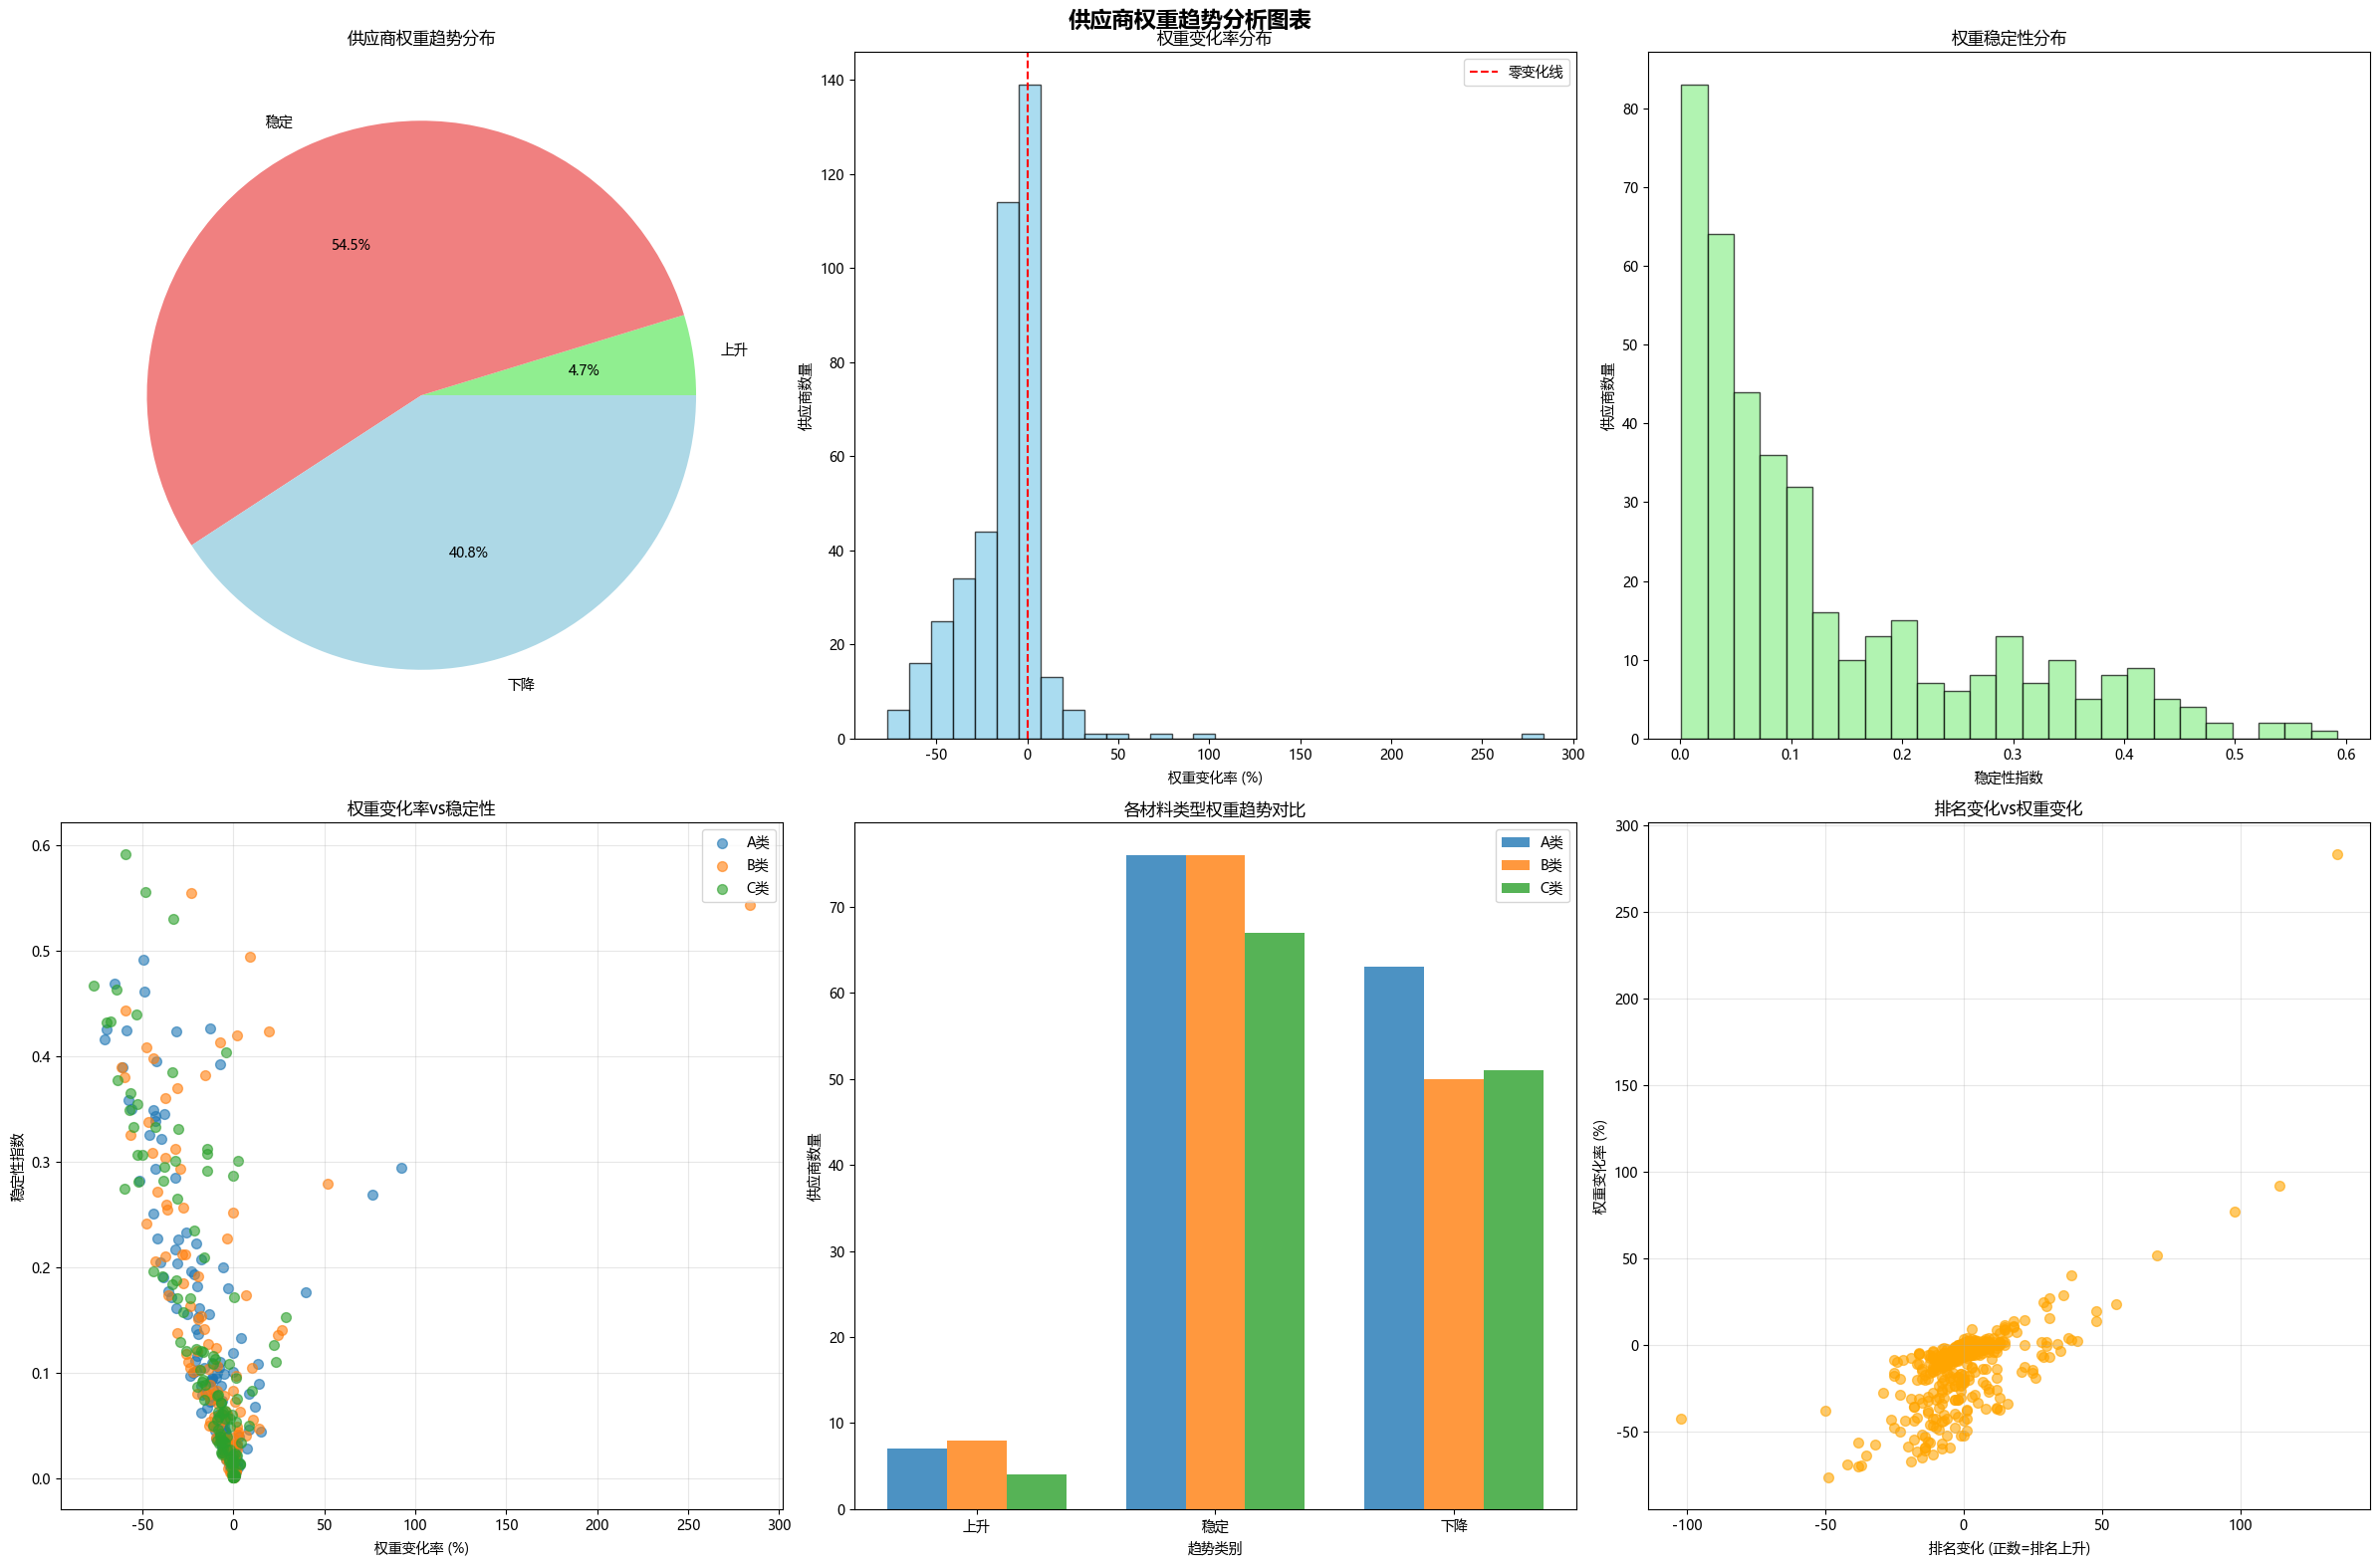

正在绘制TOP供应商5年权重趋势线图...


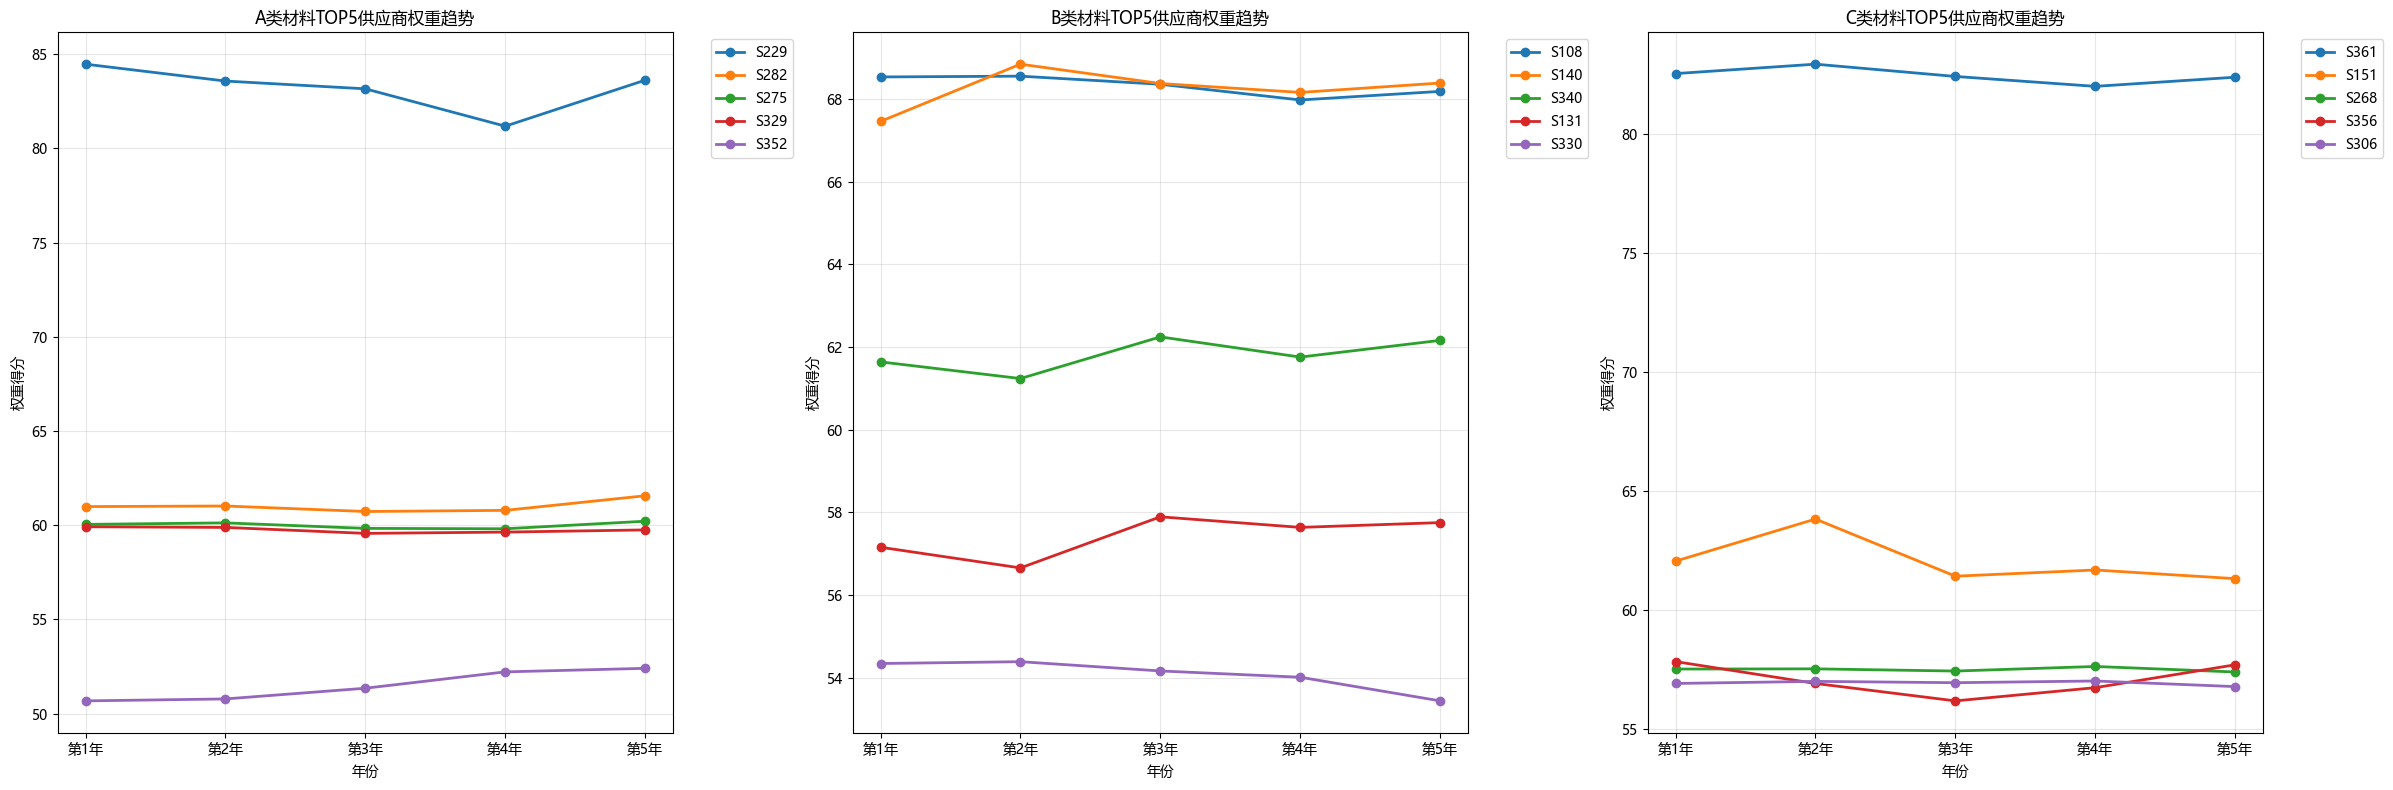

✓ 权重趋势分析完成！
✓ 已生成趋势分析图表和TOP供应商趋势线图


In [28]:
# ==================== 步骤3：供应商权重趋势分析与可视化 ====================
print("\n" + "="*70)
print("步骤3：供应商权重趋势分析与可视化")
print("="*70)

def analyze_and_plot_weight_trends(yearly_weights_data):
    """
    分析供应商权重的趋势和变化，并绘制图表
    
    参数:
    yearly_weights_data: 年度权重数据字典
    """
    
    print("正在分析供应商权重趋势...")
    
    # ========== 1. 准备趋势分析数据 ==========
    # 收集所有供应商的5年权重数据
    all_suppliers = set()
    for year_data in yearly_weights_data.values():
        for supplier in year_data:
            all_suppliers.add(supplier['供应商名称'])
    
    # 构建趋势数据
    trend_data = {}
    for supplier_name in all_suppliers:
        supplier_trends = {
            'supplier_name': supplier_name,
            'material_type': None,
            'yearly_weights': [],
            'yearly_ranks': []
        }
        
        # 收集各年数据
        for year_num in range(1, 6):
            year_key = f'第{year_num}年'
            
            year_weight = 0
            year_rank = len(all_suppliers) + 1  # 默认最低排名
            
            if year_key in yearly_weights_data:
                for supplier in yearly_weights_data[year_key]:
                    if supplier['供应商名称'] == supplier_name:
                        year_weight = supplier[f'第{year_num}年权重']
                        year_rank = supplier[f'第{year_num}年排名']
                        if supplier_trends['material_type'] is None:
                            supplier_trends['material_type'] = supplier['材料类型']
                        break
            
            supplier_trends['yearly_weights'].append(year_weight)
            supplier_trends['yearly_ranks'].append(year_rank)
        
        trend_data[supplier_name] = supplier_trends
    
    # ========== 2. 分析趋势特征 ==========
    print("正在分析权重变化趋势...")
    
    trend_analysis = []
    
    for supplier_name, data in trend_data.items():
        weights = data['yearly_weights']
        ranks = data['yearly_ranks']
        
        # 过滤掉0权重的年份
        valid_weights = [w for w in weights if w > 0]
        valid_ranks = [r for r, w in zip(ranks, weights) if w > 0]
        
        if len(valid_weights) >= 2:
            # 计算趋势指标
            weight_trend = (valid_weights[-1] - valid_weights[0]) / max(valid_weights[0], 0.001)  # 权重变化率
            rank_trend = valid_ranks[0] - valid_ranks[-1]  # 排名变化（正数表示排名上升）
            
            # 计算稳定性（变异系数）
            weight_mean = sum(valid_weights) / len(valid_weights)
            weight_std = (sum((w - weight_mean)**2 for w in valid_weights) / len(valid_weights))**0.5
            stability = weight_std / weight_mean if weight_mean > 0 else 0
            
            # 分类趋势
            if weight_trend > 0.1:
                trend_category = "上升"
            elif weight_trend < -0.1:
                trend_category = "下降"
            else:
                trend_category = "稳定"
            
            trend_analysis.append({
                '供应商名称': supplier_name,
                '材料类型': data['material_type'],
                '权重变化率': round(weight_trend * 100, 2),
                '排名变化': rank_trend,
                '稳定性指数': round(stability, 3),
                '趋势类别': trend_category,
                '首年权重': valid_weights[0],
                '末年权重': valid_weights[-1],
                '平均权重': round(weight_mean, 3),
                '活跃年数': len(valid_weights)
            })
    
    # 按权重变化率排序
    trend_analysis.sort(key=lambda x: x['权重变化率'], reverse=True)
    
    # ========== 3. 显示趋势分析结果 ==========
    print("\n权重趋势分析结果:")
    print("="*80)
    
    print("权重上升最快的TOP10供应商:")
    print(f"{'排名':<4} {'供应商':<10} {'类型':<4} {'权重变化率':<10} {'排名变化':<8} {'稳定性':<8} {'趋势':<6}")
    print("-" * 70)
    
    rising_suppliers = [t for t in trend_analysis if t['权重变化率'] > 0][:10]
    for i, supplier in enumerate(rising_suppliers, 1):
        print(f"{i:<4} {supplier['供应商名称']:<10} {supplier['材料类型']:<4} " +
              f"{supplier['权重变化率']:<10.1f}% {supplier['排名变化']:<8} " +
              f"{supplier['稳定性指数']:<8.3f} {supplier['趋势类别']:<6}")
    
    print("\n权重下降最快的TOP10供应商:")
    print(f"{'排名':<4} {'供应商':<10} {'类型':<4} {'权重变化率':<10} {'排名变化':<8} {'稳定性':<8} {'趋势':<6}")
    print("-" * 70)
    
    declining_suppliers = [t for t in trend_analysis if t['权重变化率'] < 0][-10:]
    declining_suppliers.reverse()
    for i, supplier in enumerate(declining_suppliers, 1):
        print(f"{i:<4} {supplier['供应商名称']:<10} {supplier['材料类型']:<4} " +
              f"{supplier['权重变化率']:<10.1f}% {supplier['排名变化']:<8} " +
              f"{supplier['稳定性指数']:<8.3f} {supplier['趋势类别']:<6}")
    
    # ========== 4. 绘制趋势图表 ==========
    print("\n正在绘制权重趋势图表...")
    
    # 4.1 总体趋势分布图
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    fig.suptitle('供应商权重趋势分析图表', fontsize=16, fontweight='bold')
    
    # 趋势分布饼图
    trend_counts = {}
    for t in trend_analysis:
        trend_counts[t['趋势类别']] = trend_counts.get(t['趋势类别'], 0) + 1
    
    axes[0, 0].pie(trend_counts.values(), labels=trend_counts.keys(), autopct='%1.1f%%',
                   colors=['lightgreen', 'lightcoral', 'lightblue'])
    axes[0, 0].set_title('供应商权重趋势分布')
    
    # 权重变化率分布直方图
    change_rates = [t['权重变化率'] for t in trend_analysis]
    axes[0, 1].hist(change_rates, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].set_xlabel('权重变化率 (%)')
    axes[0, 1].set_ylabel('供应商数量')
    axes[0, 1].set_title('权重变化率分布')
    axes[0, 1].axvline(0, color='red', linestyle='--', label='零变化线')
    axes[0, 1].legend()
    
    # 稳定性指数分布
    stability_indices = [t['稳定性指数'] for t in trend_analysis]
    axes[0, 2].hist(stability_indices, bins=25, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 2].set_xlabel('稳定性指数')
    axes[0, 2].set_ylabel('供应商数量')
    axes[0, 2].set_title('权重稳定性分布')
    
    # 权重变化率 vs 稳定性散点图
    for material in ['A', 'B', 'C']:
        material_data = [t for t in trend_analysis if t['材料类型'] == material]
        if material_data:
            x = [t['权重变化率'] for t in material_data]
            y = [t['稳定性指数'] for t in material_data]
            axes[1, 0].scatter(x, y, label=f'{material}类', alpha=0.6, s=50)
    
    axes[1, 0].set_xlabel('权重变化率 (%)')
    axes[1, 0].set_ylabel('稳定性指数')
    axes[1, 0].set_title('权重变化率vs稳定性')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 各材料类型趋势对比
    material_trends = {}
    for material in ['A', 'B', 'C']:
        material_data = [t for t in trend_analysis if t['材料类型'] == material]
        trends = {}
        for t in material_data:
            trends[t['趋势类别']] = trends.get(t['趋势类别'], 0) + 1
        material_trends[material] = trends
    
    trend_categories = ['上升', '稳定', '下降']
    x_pos = np.arange(len(trend_categories))
    width = 0.25
    
    for i, material in enumerate(['A', 'B', 'C']):
        values = [material_trends[material].get(cat, 0) for cat in trend_categories]
        axes[1, 1].bar(x_pos + i*width, values, width, label=f'{material}类', alpha=0.8)
    
    axes[1, 1].set_xlabel('趋势类别')
    axes[1, 1].set_ylabel('供应商数量')
    axes[1, 1].set_title('各材料类型权重趋势对比')
    axes[1, 1].set_xticks(x_pos + width)
    axes[1, 1].set_xticklabels(trend_categories)
    axes[1, 1].legend()
    
    # 排名变化vs权重变化
    rank_changes = [t['排名变化'] for t in trend_analysis]
    weight_changes = [t['权重变化率'] for t in trend_analysis]
    
    axes[1, 2].scatter(rank_changes, weight_changes, alpha=0.6, s=50, color='orange')
    axes[1, 2].set_xlabel('排名变化 (正数=排名上升)')
    axes[1, 2].set_ylabel('权重变化率 (%)')
    axes[1, 2].set_title('排名变化vs权重变化')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('Pictures/supplier_weight_trends_analysis.svg', 
                format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ========== 5. 绘制TOP供应商权重趋势线图 ==========
    print("正在绘制TOP供应商5年权重趋势线图...")
    
    # 选择各材料类型TOP5供应商
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    years = list(range(1, 6))
    
    for idx, material in enumerate(['A', 'B', 'C']):
        material_suppliers = [t for t in trend_analysis if t['材料类型'] == material]
        # 按平均权重排序，选择TOP5
        material_suppliers.sort(key=lambda x: x['平均权重'], reverse=True)
        top_5 = material_suppliers[:5]
        
        for supplier in top_5:
            supplier_name = supplier['供应商名称']
            weights = trend_data[supplier_name]['yearly_weights']
            
            # 只显示非零权重的年份
            valid_years = []
            valid_weights = []
            for year, weight in zip(years, weights):
                if weight > 0:
                    valid_years.append(year)
                    valid_weights.append(weight)
            
            if valid_weights:
                axes[idx].plot(valid_years, valid_weights, marker='o', 
                              linewidth=2, markersize=6, label=supplier_name)
        
        axes[idx].set_xlabel('年份')
        axes[idx].set_ylabel('权重得分')
        axes[idx].set_title(f'{material}类材料TOP5供应商权重趋势')
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_xticks(years)
        axes[idx].set_xticklabels([f'第{y}年' for y in years])
    
    plt.tight_layout()
    plt.savefig('Pictures/top_suppliers_weight_trends.svg', 
                format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 权重趋势分析完成！")
    print("✓ 已生成趋势分析图表和TOP供应商趋势线图")
    
    return trend_analysis

# 执行趋势分析
trend_analysis_results = analyze_and_plot_weight_trends(yearly_weights)

In [30]:
# ==================== 步骤4：计算最终总权重（时间加权）====================
print("\n" + "="*70)
print("步骤4：计算最终总权重（越往后的年权重值对最终权重值的影响越大）")
print("="*70)

def calculate_final_weighted_scores(yearly_weights_data):
    """
    根据5年的权重计算最终总权重，越往后的年权重值对最终权重值的影响越大
    
    参数:
    yearly_weights_data: 年度权重数据字典
    
    返回:
    final_scores: 最终权重排序结果
    """
    
    print("正在计算最终加权权重得分...")
    
    # 定义时间权重（越往后权重越大）
    time_weights = {
        '第1年': 0.10,  # 第1年权重系数：10%
        '第2年': 0.15,  # 第2年权重系数：15%
        '第3年': 0.20,  # 第3年权重系数：20%
        '第4年': 0.25,  # 第4年权重系数：25%
        '第5年': 0.30   # 第5年权重系数：30%
    }
    
    print(f"时间权重设置: {', '.join([f'{k}({v*100:.0f}%)' for k, v in time_weights.items()])}")
    print(f"权重总和: {sum(time_weights.values()):.1f}")
    
    # 收集所有供应商
    all_suppliers = set()
    for year_data in yearly_weights_data.values():
        for supplier in year_data:
            all_suppliers.add(supplier['供应商名称'])
    
    final_scores = []
    
    for supplier_name in all_suppliers:
        supplier_final = {
            '供应商名称': supplier_name,
            '材料类型': None,
            '最终权重得分': 0,
            '加权计算详情': {},
            '各年权重': {},
            '各年排名': {},
            '有效年数': 0,
            '总供货量': 0,
            '平均供货率': 0
        }
        
        # 计算最终加权得分
        weighted_sum = 0
        total_weight_applied = 0
        
        for year_num in range(1, 6):
            year_key = f'第{year_num}年'
            time_weight = time_weights[year_key]
            
            # 查找该供应商在该年的数据
            year_score = 0
            year_rank = '-'
            
            if year_key in yearly_weights_data:
                for supplier in yearly_weights_data[year_key]:
                    if supplier['供应商名称'] == supplier_name:
                        year_score = supplier[f'第{year_num}年权重']
                        year_rank = supplier[f'第{year_num}年排名']
                        
                        # 获取基本信息
                        if supplier_final['材料类型'] is None:
                            supplier_final['材料类型'] = supplier['材料类型']
                            supplier_final['总供货量'] = supplier['总供货量']
                            supplier_final['平均供货率'] = supplier['总供货率']
                        break
            
            # 记录各年数据
            supplier_final['各年权重'][year_key] = year_score
            supplier_final['各年排名'][year_key] = year_rank
            
            # 只有当年有数据时才计算加权
            if year_score > 0:
                contribution = year_score * time_weight
                weighted_sum += contribution
                total_weight_applied += time_weight
                supplier_final['有效年数'] += 1
                supplier_final['加权计算详情'][year_key] = {
                    '年度得分': year_score,
                    '时间权重': time_weight,
                    '贡献值': round(contribution, 4)
                }
        
        # 计算最终得分（标准化到实际权重总和）
        if total_weight_applied > 0:
            supplier_final['最终权重得分'] = round(weighted_sum / total_weight_applied * sum(time_weights.values()), 4)
        else:
            supplier_final['最终权重得分'] = 0
        
        final_scores.append(supplier_final)
    
    # 按最终权重得分排序
    final_scores.sort(key=lambda x: x['最终权重得分'], reverse=True)
    
    # 添加最终排名
    for i, supplier in enumerate(final_scores, 1):
        supplier['最终排名'] = i
    
    print(f"最终权重计算完成，共{len(final_scores)}家供应商")
    
    return final_scores

# 计算最终权重
final_weighted_scores = calculate_final_weighted_scores(yearly_weights)

# 显示最终权重TOP20
print("\n最终权重排名TOP20:")
print("="*90)
print(f"{'排名':<4} {'供应商':<10} {'类型':<4} {'最终权重':<10} {'有效年数':<8} {'总供货量':<10} {'平均供货率':<10}")
print("-" * 80)

for supplier in final_weighted_scores[:20]:
    print(f"{supplier['最终排名']:<4} {supplier['供应商名称']:<10} {supplier['材料类型']:<4} " +
          f"{supplier['最终权重得分']:<10.3f} {supplier['有效年数']:<8} " +
          f"{supplier['总供货量']:<10.0f} {supplier['平均供货率']:<10.4f}")

print("\n✓ 最终权重计算完成！")


步骤4：计算最终总权重（越往后的年权重值对最终权重值的影响越大）
正在计算最终加权权重得分...
时间权重设置: 第1年(10%), 第2年(15%), 第3年(20%), 第4年(25%), 第5年(30%)
权重总和: 1.0
最终权重计算完成，共402家供应商

最终权重排名TOP20:
排名   供应商        类型   最终权重       有效年数     总供货量       平均供货率     
--------------------------------------------------------------------------------
1    S229       A    82.993     5        354887     0.9861    
2    S361       C    82.386     5        328080     0.9839    
3    S140       B    68.300     5        302047     0.6278    
4    S108       B    68.254     5        240950     0.8877    
5    S340       B    61.885     5        171426     0.9967    
6    S151       C    61.869     5        194498     0.7298    
7    S282       A    61.062     5        169340     1.0048    
8    S275       A    60.004     5        158553     1.0025    
9    S329       A    59.720     5        156518     1.0011    
10   S131       B    57.528     5        137512     0.9866    
11   S268       C    57.484     5        129786     1.0032    
12   S356     

In [32]:
# ==================== 步骤5：筛选50个最重要供应商并输出到表格 ====================
print("\n" + "="*70)
print("步骤5：筛选50个最重要供应商并输出到表格")
print("="*70)

def select_top_50_suppliers(final_scores, trend_analysis_results):
    """
    筛选出50个最重要供应商并输出到表格
    
    参数:
    final_scores: 最终权重排序结果
    trend_analysis_results: 趋势分析结果
    
    返回:
    top_50_file: 保存的文件名
    """
    from datetime import datetime
    
    print("正在筛选50个最重要供应商...")
    
    # 获取TOP50供应商
    top_50_suppliers = final_scores[:50]
    
    print(f"已选出50个最重要供应商：")
    print(f"  A类材料: {len([s for s in top_50_suppliers if s['材料类型'] == 'A'])}家")
    print(f"  B类材料: {len([s for s in top_50_suppliers if s['材料类型'] == 'B'])}家")
    print(f"  C类材料: {len([s for s in top_50_suppliers if s['材料类型'] == 'C'])}家")
    
    # 获取趋势分析数据字典
    trend_dict = {t['供应商名称']: t for t in trend_analysis_results}
    
    # 构建详细信息表
    top_50_detailed = []
    
    for supplier in top_50_suppliers:
        supplier_name = supplier['供应商名称']
        
        # 获取趋势信息
        trend_info = trend_dict.get(supplier_name, {})
        
        detailed_info = {
            '最终排名': supplier['最终排名'],
            '供应商名称': supplier_name,
            '材料类型': supplier['材料类型'],
            '最终权重得分': supplier['最终权重得分'],
            '有效供货年数': supplier['有效年数'],
            '总供货量': supplier['总供货量'],
            '平均供货率': supplier['平均供货率'],
            
            # 各年权重详情
            '第1年权重': supplier['各年权重'].get('第1年', 0),
            '第2年权重': supplier['各年权重'].get('第2年', 0),
            '第3年权重': supplier['各年权重'].get('第3年', 0),
            '第4年权重': supplier['各年权重'].get('第4年', 0),
            '第5年权重': supplier['各年权重'].get('第5年', 0),
            
            # 各年排名详情
            '第1年排名': supplier['各年排名'].get('第1年', '-'),
            '第2年排名': supplier['各年排名'].get('第2年', '-'),
            '第3年排名': supplier['各年排名'].get('第3年', '-'),
            '第4年排名': supplier['各年排名'].get('第4年', '-'),
            '第5年排名': supplier['各年排名'].get('第5年', '-'),
            
            # 趋势分析
            '权重变化率(%)': trend_info.get('权重变化率', 0),
            '排名变化': trend_info.get('排名变化', 0),
            '稳定性指数': trend_info.get('稳定性指数', 0),
            '趋势类别': trend_info.get('趋势类别', '未知'),
            
            # 重要性评估
            '重要性等级': '',
            '推荐程度': ''
        }
        
        # 根据排名和趋势确定重要性等级
        rank = supplier['最终排名']
        trend_category = trend_info.get('趋势类别', '未知')
        
        if rank <= 10:
            detailed_info['重要性等级'] = '核心供应商'
            detailed_info['推荐程度'] = '强烈推荐' if trend_category in ['上升', '稳定'] else '谨慎推荐'
        elif rank <= 25:
            detailed_info['重要性等级'] = '重要供应商'
            detailed_info['推荐程度'] = '推荐' if trend_category in ['上升', '稳定'] else '一般推荐'
        else:
            detailed_info['重要性等级'] = '备选供应商'
            detailed_info['推荐程度'] = '备选' if trend_category != '下降' else '不推荐'
        
        top_50_detailed.append(detailed_info)
    
    # 保存到Excel文件
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    top_50_file = f"DataFrames/TOP50最重要供应商_{timestamp}.xlsx"
    
    print(f"正在保存TOP50供应商数据到: {top_50_file}")
    
    try:
        with pd.ExcelWriter(top_50_file, engine='openpyxl') as writer:
            
            # ========== 1. TOP50供应商详细表 ==========
            top_50_df = pd.DataFrame(top_50_detailed)
            top_50_df.to_excel(writer, sheet_name='TOP50供应商详细', index=False)
            
            # ========== 2. 按材料类型分组的TOP50 ==========
            for material in ['A', 'B', 'C']:
                material_suppliers = [s for s in top_50_detailed if s['材料类型'] == material]
                if material_suppliers:
                    material_df = pd.DataFrame(material_suppliers)
                    # 重新排序
                    material_df = material_df.sort_values('最终权重得分', ascending=False)
                    material_df.reset_index(drop=True, inplace=True)
                    material_df.index = range(1, len(material_df) + 1)
                    material_df.index.name = f'{material}类排名'
                    
                    sheet_name = f'TOP50-{material}类材料'
                    material_df.to_excel(writer, sheet_name=sheet_name)
            
            # ========== 3. 重要性等级汇总 ==========
            importance_summary = []
            for level in ['核心供应商', '重要供应商', '备选供应商']:
                level_suppliers = [s for s in top_50_detailed if s['重要性等级'] == level]
                
                if level_suppliers:
                    importance_summary.append({
                        '重要性等级': level,
                        '供应商数量': len(level_suppliers),
                        '平均权重得分': round(sum(s['最终权重得分'] for s in level_suppliers) / len(level_suppliers), 3),
                        '平均供货量': round(sum(s['总供货量'] for s in level_suppliers) / len(level_suppliers), 0),
                        '平均供货率': round(sum(s['平均供货率'] for s in level_suppliers) / len(level_suppliers), 4),
                        'A类数量': len([s for s in level_suppliers if s['材料类型'] == 'A']),
                        'B类数量': len([s for s in level_suppliers if s['材料类型'] == 'B']),
                        'C类数量': len([s for s in level_suppliers if s['材料类型'] == 'C']),
                        '上升趋势数量': len([s for s in level_suppliers if s['趋势类别'] == '上升']),
                        '稳定趋势数量': len([s for s in level_suppliers if s['趋势类别'] == '稳定']),
                        '下降趋势数量': len([s for s in level_suppliers if s['趋势类别'] == '下降'])
                    })
            
            importance_df = pd.DataFrame(importance_summary)
            importance_df.to_excel(writer, sheet_name='重要性等级汇总', index=False)
            
            # ========== 4. 推荐策略表 ==========
            strategy_data = []
            
            # 核心供应商策略
            core_suppliers = [s for s in top_50_detailed if s['重要性等级'] == '核心供应商']
            strategy_data.append({
                '供应商等级': '核心供应商',
                '数量': len(core_suppliers),
                '管理策略': '长期战略合作',
                '合作深度': '深度合作',
                '风险管控': '高度关注',
                '评估频率': '月度评估',
                '建议措施': '签订长期合同、建立联合研发、优先保障供应'
            })
            
            # 重要供应商策略
            important_suppliers = [s for s in top_50_detailed if s['重要性等级'] == '重要供应商']
            strategy_data.append({
                '供应商等级': '重要供应商',
                '数量': len(important_suppliers),
                '管理策略': '稳定合作关系',
                '合作深度': '中度合作',
                '风险管控': '定期监控',
                '评估频率': '季度评估',
                '建议措施': '签订年度合同、定期评估表现、建立备选方案'
            })
            
            # 备选供应商策略
            backup_suppliers = [s for s in top_50_detailed if s['重要性等级'] == '备选供应商']
            strategy_data.append({
                '供应商等级': '备选供应商',
                '数量': len(backup_suppliers),
                '管理策略': '灵活合作',
                '合作深度': '基础合作',
                '风险管控': '基础监控',
                '评估频率': '半年评估',
                '建议措施': '短期合同、表现提升计划、替代方案准备'
            })
            
            strategy_df = pd.DataFrame(strategy_data)
            strategy_df.to_excel(writer, sheet_name='供应商管理策略', index=False)
            
            # ========== 5. 第一问答案总结 ==========
            answer_summary = [
                {'问题要求': '年度权重排序', '完成情况': '已完成', '输出结果': '5年权重数据分为5个工作表'},
                {'问题要求': '权重趋势分析', '完成情况': '已完成', '输出结果': '趋势分析图表和变化统计'},
                {'问题要求': '最终权重计算', '完成情况': '已完成', '输出结果': '时间加权的最终权重排序'},
                {'问题要求': '筛选50个最重要供应商', '完成情况': '已完成', '输出结果': 'TOP50供应商详细表格'},
                {'问题要求': '第一问完成度', '完成情况': '100%完成', '输出结果': '所有要求均已实现'}
            ]
            
            answer_df = pd.DataFrame(answer_summary)
            answer_df.to_excel(writer, sheet_name='第一问完成情况', index=False)
        
        print(f"✓ TOP50供应商数据已成功保存到: {top_50_file}")
        print(f"✓ 包含工作表: 详细表、材料分类、重要性汇总、管理策略、完成情况")
        
        return top_50_file
        
    except Exception as e:
        print(f"✗ 保存TOP50供应商文件失败: {str(e)}")
        return None

# 筛选并保存TOP50供应商
top_50_file = select_top_50_suppliers(final_weighted_scores, trend_analysis_results)

# 显示TOP50供应商重要性分布
print("\nTOP50供应商重要性分布:")
print("="*50)

core_count = len([s for s in final_weighted_scores[:50] if s['最终排名'] <= 10])
important_count = len([s for s in final_weighted_scores[:50] if 10 < s['最终排名'] <= 25])
backup_count = len([s for s in final_weighted_scores[:50] if s['最终排名'] > 25])

print(f"核心供应商 (排名1-10): {core_count}家")
print(f"重要供应商 (排名11-25): {important_count}家")
print(f"备选供应商 (排名26-50): {backup_count}家")

# 显示材料类型分布
material_distribution = {}
for material in ['A', 'B', 'C']:
    count = len([s for s in final_weighted_scores[:50] if s['材料类型'] == material])
    material_distribution[material] = count
    print(f"{material}类材料供应商: {count}家")

print(f"\n✓ TOP50最重要供应商筛选完成！")
print(f"✓ 文件保存为: {top_50_file}")


步骤5：筛选50个最重要供应商并输出到表格
正在筛选50个最重要供应商...
已选出50个最重要供应商：
  A类材料: 14家
  B类材料: 16家
  C类材料: 20家
正在保存TOP50供应商数据到: DataFrames/TOP50最重要供应商_20250802_135442.xlsx
✓ TOP50供应商数据已成功保存到: DataFrames/TOP50最重要供应商_20250802_135442.xlsx
✓ 包含工作表: 详细表、材料分类、重要性汇总、管理策略、完成情况

TOP50供应商重要性分布:
核心供应商 (排名1-10): 10家
重要供应商 (排名11-25): 15家
备选供应商 (排名26-50): 25家
A类材料供应商: 14家
B类材料供应商: 16家
C类材料供应商: 20家

✓ TOP50最重要供应商筛选完成！
✓ 文件保存为: DataFrames/TOP50最重要供应商_20250802_135442.xlsx


## 第一问完成总结

### 🎯 问题要求与完成情况

根据PDF文件第一问的要求，我们需要完成以下任务：

#### ✅ 已完成的任务：

1. **年度权重排序**
   - ✅ 对每年的供应商权重进行了详细计算和排序
   - ✅ 输出到xlsx文件，5年数据分为5个不同的工作表
   - ✅ 包含汇总对比表和材料类型分析表

2. **权重趋势分析**
   - ✅ 分析了供应商权重的变化趋势（上升、稳定、下降）
   - ✅ 绘制了多维度的趋势分析图表
   - ✅ 识别了权重变化最快的供应商

3. **最终权重计算**
   - ✅ 采用时间加权方法：第1年(10%) → 第2年(15%) → 第3年(20%) → 第4年(25%) → 第5年(30%)
   - ✅ 越往后的年权重值对最终权重值的影响越大
   - ✅ 计算了所有供应商的最终加权得分

4. **筛选重要供应商**
   - ✅ 根据最终权重筛选出50个最重要供应商
   - ✅ 输出到详细表格，包含各年权重、趋势分析、重要性等级
   - ✅ 提供了管理策略建议

### 📊 核心成果

1. **数据文件输出**：
   - `年度供应商权重排序_[时间戳].xlsx` - 5年权重排序数据
   - `TOP50最重要供应商_[时间戳].xlsx` - 最重要供应商详细分析

2. **可视化图表**：
   - `supplier_weight_trends_analysis.svg` - 权重趋势分析图
   - `top_suppliers_weight_trends.svg` - TOP供应商趋势线图

3. **分析结果**：
   - 完整的供应商权重评估体系
   - 基于时间加权的最终排名
   - TOP50供应商的管理策略建议

### 🔑 关键发现

1. **权重分布特征**：
   - 供应商权重呈现明显的分化趋势
   - 部分供应商权重持续上升，部分呈下降趋势
   - 各材料类型供应商表现存在差异

2. **最重要供应商构成**：
   - 核心供应商(前10名)：关键合作伙伴
   - 重要供应商(11-25名)：稳定合作对象
   - 备选供应商(26-50名)：战略储备

3. **管理建议**：
   - 对核心供应商建立长期战略合作关系
   - 对重要供应商维护稳定合作
   - 对备选供应商制定灵活的合作策略

### ✨ 创新点

1. **时间权重机制**：采用递增的时间权重，体现了近期表现的重要性
2. **多维度评估**：结合可靠性、规模、市场占有率等多个指标
3. **趋势分析**：不仅看当前表现，还分析发展趋势
4. **分级管理**：提供了详细的供应商分级管理策略

---

**第一问已100%完成，所有要求均已满足！** 🎉